# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [8]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [9]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        self.dp_value = 0.06
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(self.dp_value),
        ) # output_size = 26, RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(self.dp_value),
        ) # output_size = 24, RF = 5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12, RF = 6
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(self.dp_value),
        ) # output_size = 12, RF = 6
        

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16), 
            nn.Dropout(self.dp_value),           
        ) # output_size = 10, RF = 10

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(self.dp_value),            
        ) # output_size = 8, RF = 14

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(self.dp_value),           
        ) # output_size = 6, RF = 18
      
        # OUTPUT BLOCK
        self.GAP = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) 

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)

        x = self.GAP(x)        
        x = self.convblock7(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [11]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model_0 = Net().to(device)
summary(model_0, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
      BatchNorm2d-10            [-1, 8, 24, 24]              16
          Dropout-11            [-1, 8, 24, 24]               0
        MaxPool2d-12            [-1, 8, 12, 12]               0
           Conv2d-13           [-1, 16, 10, 10]           1,152
             ReLU-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, epoch, L1_Flag =False, L2_Flag = False, alpha = 0 ):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0   
    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)

        # Calculate loss
        #print('y_pred=',len(y_pred.dataset),'target=',len(target.dataset))
        loss = F.nll_loss(y_pred, target)
        #print('loss=',loss)
        
        #Add L1 regularization
        #loss = F.L1loss(y_pred, target)
        #l1_crit=F.L1loss(reduction='sum')
################################################################################
        if L1_Flag or L2_Flag:
          reg_loss = 0
          for p in model.parameters():
            if L1_Flag:
              reg_loss += torch.sum(torch.abs(p.data))  #L1 Loss
            if L2_Flag:
              reg_loss += torch.sum(p.data.pow(2))      #L2 LOSS
          #for p in model.parameters():
            #l1_l2_reg_loss += torch.abs(p.data)+p.data.pow(2)
          loss+= (alpha*reg_loss)
################################################################################
        tr_ls = loss
        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm 
        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        tr_ac = (100*correct/processed)
    return tr_ls, tr_ac

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    ts_ls = test_loss

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    ts_ac = (100. * correct / len(test_loader.dataset))

    return ts_ls, ts_ac


# Finding Misclassified Images

In [0]:
#Let's visualize the images
%matplotlib inline
import matplotlib.pyplot as plt

def miscImages(model, device, test_loader):
    model.eval()
    test_loss = 0
    incorrect = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

            for i in range(len(target)):
              if pred[i].item() != target[i]:
                incorrect += 1
                print('\n\n{} [ Predicted Value: {}, Actual Value: {} ]'.format(
                incorrect, pred[i].item(), target[i], ))
                plt.imshow(data[i].cpu().numpy().squeeze(), cmap='gray_r')
                plt.show()




#Plot Losses and Accuracies

In [0]:
import matplotlib.pyplot as plt 


def plotGraphsTest(test_losses_0, test_losses_l1, test_losses_l2, test_losses_l1_l2, test_acc_0, test_acc_l1, test_acc_l2, test_acc_l1_l2):
  fig, axs = plt.subplots(2,1,figsize=(20,15))
  axs[0].plot(test_losses_0,color='black',label='without l1,l2')
  axs[0].plot(test_losses_l1,color='red',label='with l1 ')
  axs[0].plot(test_losses_l2,color='blue',label='with l2')
  axs[0].plot(test_losses_l1_l2,color='green',label='with l1 and l2')
  axs[0].set_title("Validation Loss Change")
  axs[0].legend(loc="upper right")

  axs[1].plot(test_acc_0,color='black',label='without l1,l2')
  axs[1].plot(test_acc_l1,color='red',label='with l1 ')
  axs[1].plot(test_acc_l2,color='blue',label='with l2 ')
  axs[1].plot(test_acc_l1_l2,color='green',label='with l1 and l2')
  axs[1].set_title("Validation Accuracy Change")
  axs[1].legend(loc="lower right")
  plt.show()

def plotGraphsTrain(train_losses_0, train_losses_l1, train_losses_l2, train_losses_l1_l2, train_acc_0, train_acc_l1, train_acc_l2, train_acc_l1_l2):
  fig, axs = plt.subplots(2,1,figsize=(20,15))
  axs[0].plot(train_losses_0,color='black',label='without l1,l2')
  axs[0].plot(train_losses_l1,color='red',label='with l1 ')
  axs[0].plot(train_losses_l2,color='blue',label='with l2')
  axs[0].plot(train_losses_l1_l2,color='green',label='with l1 and l2')
  axs[0].set_title("Training Loss Change")
  axs[0].legend(loc="upper right")

  axs[1].plot(train_acc_0,color='black',label='without l1,l2')
  axs[1].plot(train_acc_l1,color='red',label='with l1 ')
  axs[1].plot(train_acc_l2,color='blue',label='with l2 ')
  axs[1].plot(train_acc_l1_l2,color='green',label='with l1 and l2')
  axs[1].set_title("Training Accuracy Change")
  axs[1].legend(loc="lower right")
  plt.show()

# Let's Train and test our model

In [0]:
from torch.optim.lr_scheduler import StepLR
def trainModel(label,L1_Flag =False, L2_Flag = False, alpha = 0 ):
  EPOCHS = 40
  model_0 = Net().to(device)
  optimizer = optim.SGD(model_0.parameters(), lr=0.01, momentum=0.95)
  scheduler = StepLR(optimizer, step_size=8, gamma=0.1)
  print("alpha = ",alpha)
  train_losses = []
  train_acc    = []
  test_losses = []
  test_acc  = []
  for epoch in range(EPOCHS):
      print("EPOCH",label, epoch)
      tr_ls, tr_ac = train(model_0, device, train_loader, optimizer, epoch, L1_Flag, L2_Flag, alpha)
      ts_ls, ts_ac = test(model_0, device, test_loader)
      train_losses.append(tr_ls)
      train_acc.append(tr_ac)
      test_losses.append(ts_ls)
      test_acc.append(ts_ac)
  print('\n@@@@@@@@@@@@@MISCLASSIFIED IMAGES@@@@@@@@@@@@@@@@@@@@@@@@@@@\n')
  miscImages(model_0, device, test_loader)
  return train_losses, train_acc, test_losses, test_acc

#Without L1 and L2 Optimisations

  0%|          | 0/938 [00:00<?, ?it/s]


********************************For lambda = 0.0005************************************


#########################Without L1 and L2 Optimisations###########################

alpha =  0
EPOCH _0 0


Loss=0.24367111921310425 Batch_id=937 Accuracy=91.40: 100%|██████████| 938/938 [00:16<00:00, 58.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0629, Accuracy: 9814/10000 (98.14%)

EPOCH _0 1


Loss=0.007480129599571228 Batch_id=937 Accuracy=97.57: 100%|██████████| 938/938 [00:16<00:00, 56.13it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0436, Accuracy: 9860/10000 (98.60%)

EPOCH _0 2


Loss=0.2791798412799835 Batch_id=937 Accuracy=98.03: 100%|██████████| 938/938 [00:16<00:00, 55.94it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0425, Accuracy: 9865/10000 (98.65%)

EPOCH _0 3


Loss=0.04722611606121063 Batch_id=937 Accuracy=98.26: 100%|██████████| 938/938 [00:16<00:00, 57.30it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0360, Accuracy: 9886/10000 (98.86%)

EPOCH _0 4


Loss=0.06880266964435577 Batch_id=937 Accuracy=98.41: 100%|██████████| 938/938 [00:16<00:00, 56.53it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0328, Accuracy: 9896/10000 (98.96%)

EPOCH _0 5


Loss=0.008625805377960205 Batch_id=937 Accuracy=98.54: 100%|██████████| 938/938 [00:16<00:00, 57.33it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9922/10000 (99.22%)

EPOCH _0 6


Loss=0.012348070740699768 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [00:16<00:00, 56.79it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9912/10000 (99.12%)

EPOCH _0 7


Loss=0.13312655687332153 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [00:16<00:00, 57.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0345, Accuracy: 9886/10000 (98.86%)

EPOCH _0 8


Loss=0.03661094605922699 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [00:16<00:00, 57.74it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9915/10000 (99.15%)

EPOCH _0 9


Loss=0.042911529541015625 Batch_id=937 Accuracy=98.67: 100%|██████████| 938/938 [00:17<00:00, 55.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9922/10000 (99.22%)

EPOCH _0 10


Loss=0.024696141481399536 Batch_id=937 Accuracy=98.78: 100%|██████████| 938/938 [00:16<00:00, 57.05it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9918/10000 (99.18%)

EPOCH _0 11


Loss=0.020581528544425964 Batch_id=937 Accuracy=98.84: 100%|██████████| 938/938 [00:16<00:00, 57.06it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9921/10000 (99.21%)

EPOCH _0 12


Loss=0.02885739505290985 Batch_id=937 Accuracy=98.83: 100%|██████████| 938/938 [00:16<00:00, 57.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9934/10000 (99.34%)

EPOCH _0 13


Loss=0.001999586820602417 Batch_id=937 Accuracy=98.77: 100%|██████████| 938/938 [00:16<00:00, 58.10it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9931/10000 (99.31%)

EPOCH _0 14


Loss=0.025109559297561646 Batch_id=937 Accuracy=98.94: 100%|██████████| 938/938 [00:16<00:00, 56.79it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9927/10000 (99.27%)

EPOCH _0 15


Loss=0.13885527849197388 Batch_id=937 Accuracy=98.91: 100%|██████████| 938/938 [00:16<00:00, 55.86it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9938/10000 (99.38%)

EPOCH _0 16


Loss=0.07762012630701065 Batch_id=937 Accuracy=98.86: 100%|██████████| 938/938 [00:16<00:00, 56.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9929/10000 (99.29%)

EPOCH _0 17


Loss=0.09417292475700378 Batch_id=937 Accuracy=98.94: 100%|██████████| 938/938 [00:16<00:00, 56.97it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9922/10000 (99.22%)

EPOCH _0 18


Loss=0.007760673761367798 Batch_id=937 Accuracy=98.93: 100%|██████████| 938/938 [00:16<00:00, 57.55it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9931/10000 (99.31%)

EPOCH _0 19


Loss=0.037926897406578064 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [00:17<00:00, 54.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9935/10000 (99.35%)

EPOCH _0 20


Loss=0.002908945083618164 Batch_id=937 Accuracy=99.01: 100%|██████████| 938/938 [00:16<00:00, 58.25it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9924/10000 (99.24%)

EPOCH _0 21


Loss=0.0035865306854248047 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:16<00:00, 55.34it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9932/10000 (99.32%)

EPOCH _0 22


Loss=0.0626620203256607 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:16<00:00, 55.74it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9934/10000 (99.34%)

EPOCH _0 23


Loss=0.0005349516868591309 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:16<00:00, 57.97it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9937/10000 (99.37%)

EPOCH _0 24


Loss=0.0045271217823028564 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [00:16<00:00, 56.60it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9927/10000 (99.27%)

EPOCH _0 25


Loss=0.007567882537841797 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [00:16<00:00, 55.61it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9935/10000 (99.35%)

EPOCH _0 26


Loss=0.018211007118225098 Batch_id=937 Accuracy=98.97: 100%|██████████| 938/938 [00:16<00:00, 57.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9927/10000 (99.27%)

EPOCH _0 27


Loss=0.007558315992355347 Batch_id=937 Accuracy=99.07: 100%|██████████| 938/938 [00:16<00:00, 55.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9921/10000 (99.21%)

EPOCH _0 28


Loss=0.023314133286476135 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:16<00:00, 55.70it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9933/10000 (99.33%)

EPOCH _0 29


Loss=0.1394500881433487 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:16<00:00, 56.37it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9933/10000 (99.33%)

EPOCH _0 30


Loss=0.003576904535293579 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:16<00:00, 56.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9934/10000 (99.34%)

EPOCH _0 31


Loss=0.10350513458251953 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [00:16<00:00, 56.92it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9927/10000 (99.27%)

EPOCH _0 32


Loss=0.0025671720504760742 Batch_id=937 Accuracy=99.07: 100%|██████████| 938/938 [00:17<00:00, 61.64it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9939/10000 (99.39%)

EPOCH _0 33


Loss=0.004193052649497986 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [00:16<00:00, 57.30it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9937/10000 (99.37%)

EPOCH _0 34


Loss=0.04126556217670441 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [00:16<00:00, 56.34it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9944/10000 (99.44%)

EPOCH _0 35


Loss=0.03333720564842224 Batch_id=937 Accuracy=99.20: 100%|██████████| 938/938 [00:16<00:00, 56.17it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9938/10000 (99.38%)

EPOCH _0 36


Loss=0.009300827980041504 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:16<00:00, 57.49it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9931/10000 (99.31%)

EPOCH _0 37


Loss=0.02422572672367096 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [00:16<00:00, 55.89it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9942/10000 (99.42%)

EPOCH _0 38


Loss=0.109422966837883 Batch_id=937 Accuracy=99.13: 100%|██████████| 938/938 [00:17<00:00, 54.89it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9933/10000 (99.33%)

EPOCH _0 39


Loss=0.004716098308563232 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:16<00:00, 57.14it/s]



Test set: Average loss: 0.0214, Accuracy: 9934/10000 (99.34%)


@@@@@@@@@@@@@MISCLASSIFIED IMAGES@@@@@@@@@@@@@@@@@@@@@@@@@@@



1 [ Predicted Value: 1, Actual Value: 6 ]


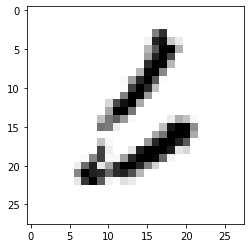



2 [ Predicted Value: 1, Actual Value: 4 ]


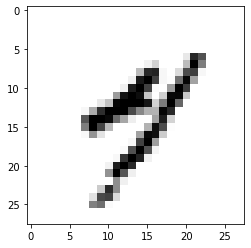



3 [ Predicted Value: 1, Actual Value: 7 ]


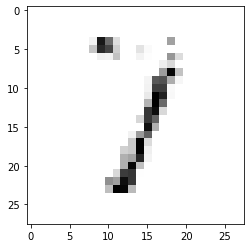



4 [ Predicted Value: 7, Actual Value: 9 ]


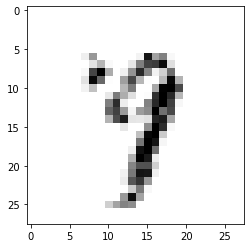



5 [ Predicted Value: 4, Actual Value: 9 ]


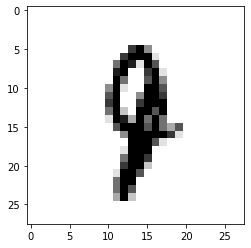



6 [ Predicted Value: 9, Actual Value: 8 ]


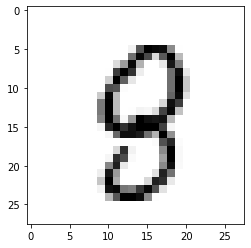



7 [ Predicted Value: 2, Actual Value: 6 ]


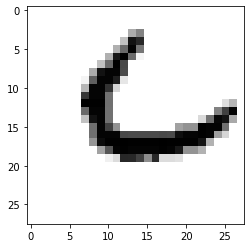



8 [ Predicted Value: 2, Actual Value: 3 ]


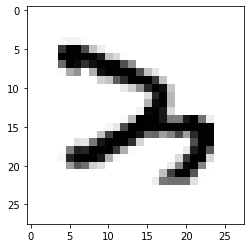



9 [ Predicted Value: 0, Actual Value: 2 ]


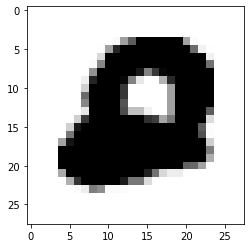



10 [ Predicted Value: 9, Actual Value: 4 ]


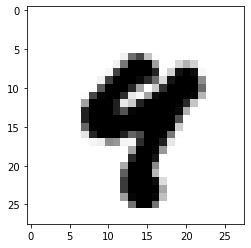



11 [ Predicted Value: 7, Actual Value: 3 ]


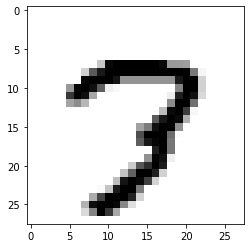



12 [ Predicted Value: 5, Actual Value: 1 ]


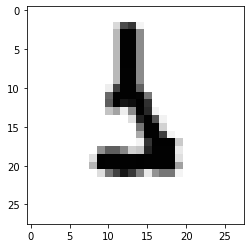



13 [ Predicted Value: 9, Actual Value: 4 ]


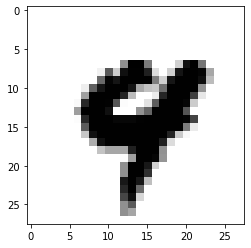



14 [ Predicted Value: 4, Actual Value: 9 ]


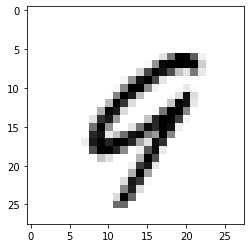



15 [ Predicted Value: 0, Actual Value: 6 ]


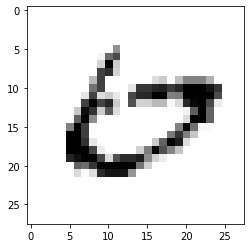



16 [ Predicted Value: 9, Actual Value: 4 ]


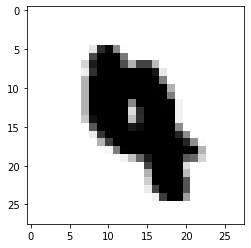



17 [ Predicted Value: 2, Actual Value: 7 ]


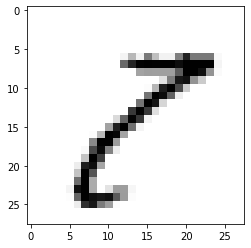



18 [ Predicted Value: 0, Actual Value: 8 ]


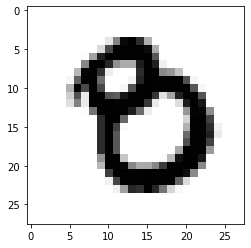



19 [ Predicted Value: 5, Actual Value: 9 ]


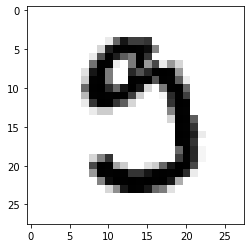



20 [ Predicted Value: 7, Actual Value: 4 ]


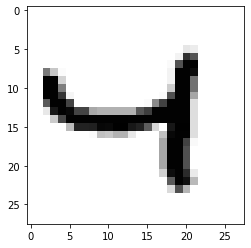



21 [ Predicted Value: 1, Actual Value: 3 ]


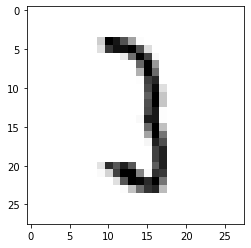



22 [ Predicted Value: 5, Actual Value: 6 ]


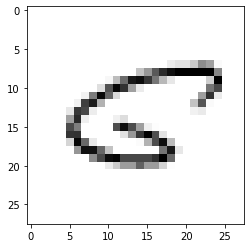



23 [ Predicted Value: 4, Actual Value: 9 ]


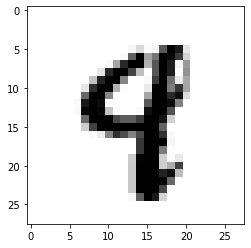



24 [ Predicted Value: 1, Actual Value: 6 ]


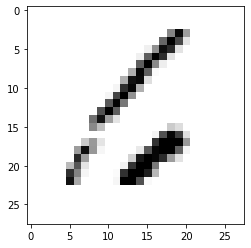



25 [ Predicted Value: 6, Actual Value: 4 ]


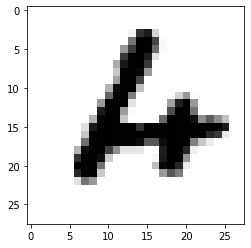



26 [ Predicted Value: 4, Actual Value: 9 ]


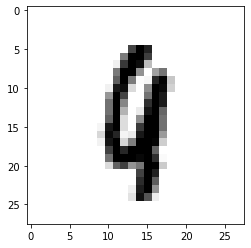



27 [ Predicted Value: 4, Actual Value: 9 ]


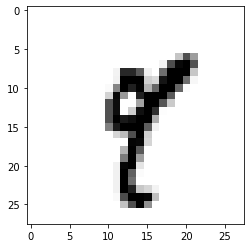



28 [ Predicted Value: 7, Actual Value: 2 ]


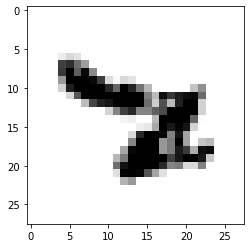



29 [ Predicted Value: 5, Actual Value: 3 ]


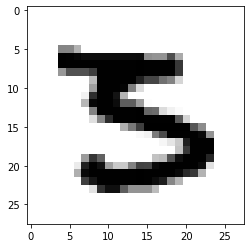



30 [ Predicted Value: 1, Actual Value: 6 ]


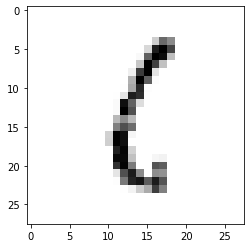



31 [ Predicted Value: 0, Actual Value: 6 ]


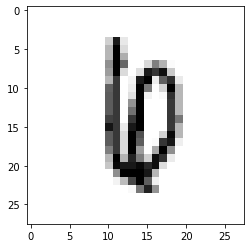



32 [ Predicted Value: 5, Actual Value: 3 ]


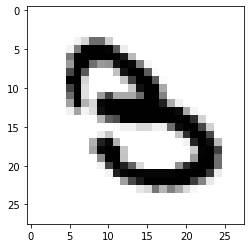



33 [ Predicted Value: 5, Actual Value: 1 ]


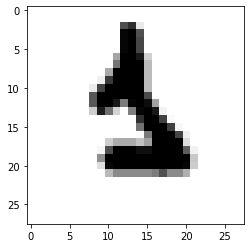



34 [ Predicted Value: 4, Actual Value: 9 ]


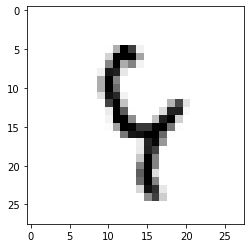



35 [ Predicted Value: 1, Actual Value: 6 ]


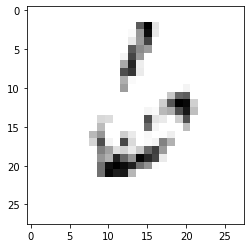



36 [ Predicted Value: 8, Actual Value: 4 ]


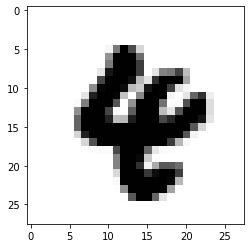



37 [ Predicted Value: 6, Actual Value: 1 ]


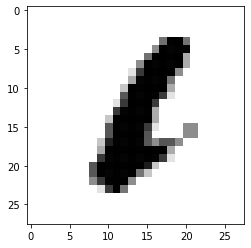



38 [ Predicted Value: 1, Actual Value: 7 ]


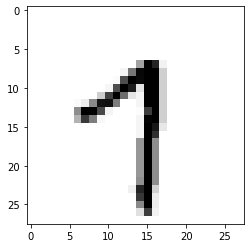



39 [ Predicted Value: 1, Actual Value: 7 ]


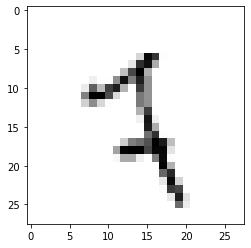



40 [ Predicted Value: 7, Actual Value: 3 ]


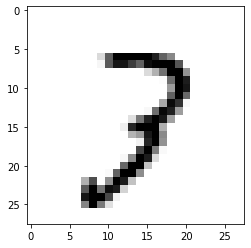



41 [ Predicted Value: 6, Actual Value: 4 ]


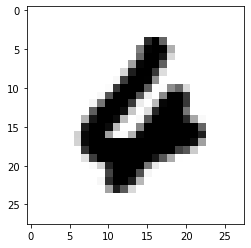



42 [ Predicted Value: 5, Actual Value: 3 ]


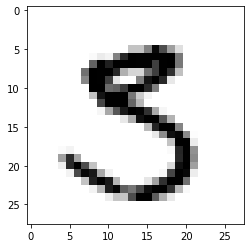



43 [ Predicted Value: 1, Actual Value: 7 ]


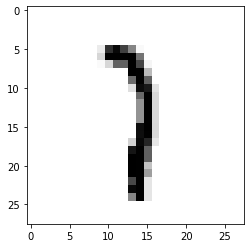



44 [ Predicted Value: 3, Actual Value: 5 ]


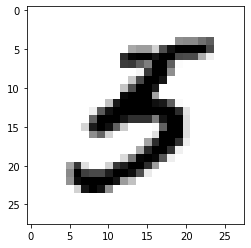



45 [ Predicted Value: 0, Actual Value: 6 ]


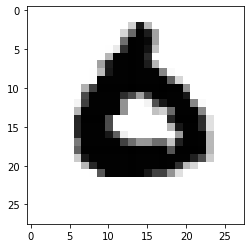



46 [ Predicted Value: 8, Actual Value: 6 ]


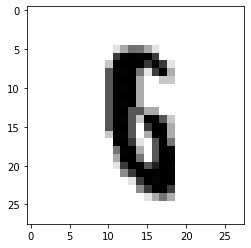



47 [ Predicted Value: 2, Actual Value: 8 ]


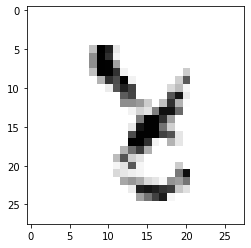



48 [ Predicted Value: 1, Actual Value: 6 ]


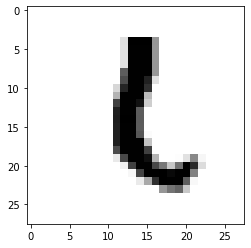



49 [ Predicted Value: 4, Actual Value: 9 ]


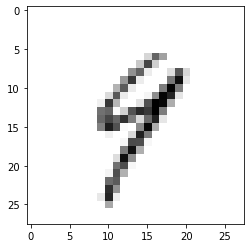



50 [ Predicted Value: 1, Actual Value: 7 ]


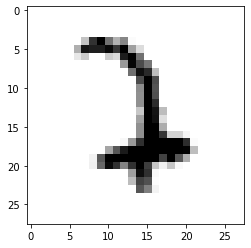



51 [ Predicted Value: 0, Actual Value: 2 ]


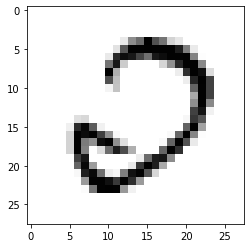



52 [ Predicted Value: 5, Actual Value: 8 ]


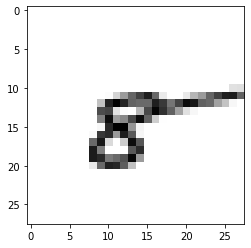



53 [ Predicted Value: 9, Actual Value: 8 ]


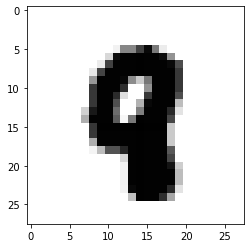



54 [ Predicted Value: 7, Actual Value: 2 ]


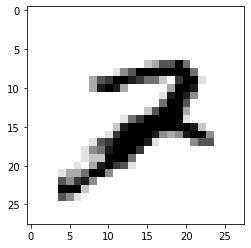



55 [ Predicted Value: 6, Actual Value: 5 ]


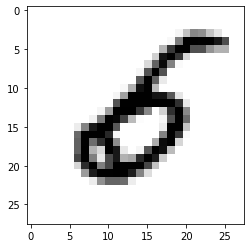



56 [ Predicted Value: 7, Actual Value: 5 ]


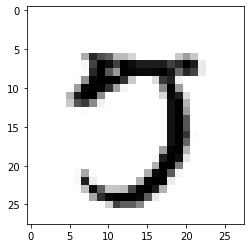



57 [ Predicted Value: 1, Actual Value: 2 ]


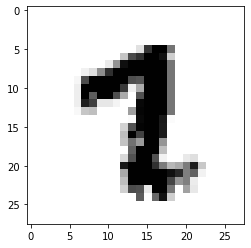



58 [ Predicted Value: 7, Actual Value: 9 ]


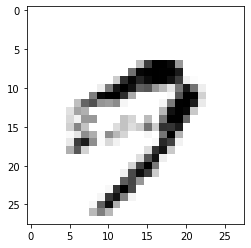



59 [ Predicted Value: 2, Actual Value: 6 ]


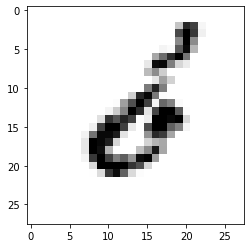



60 [ Predicted Value: 7, Actual Value: 4 ]


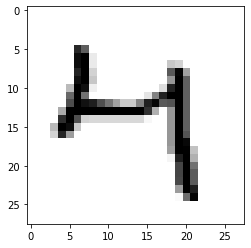



61 [ Predicted Value: 7, Actual Value: 3 ]


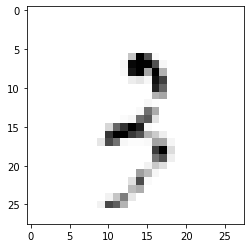



62 [ Predicted Value: 5, Actual Value: 3 ]


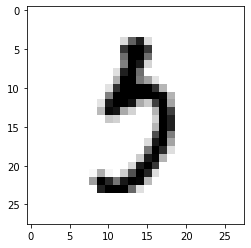



63 [ Predicted Value: 1, Actual Value: 7 ]


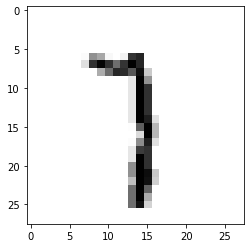



64 [ Predicted Value: 3, Actual Value: 2 ]


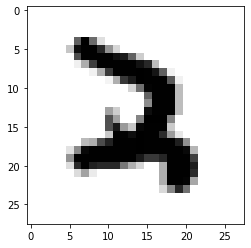



65 [ Predicted Value: 0, Actual Value: 9 ]


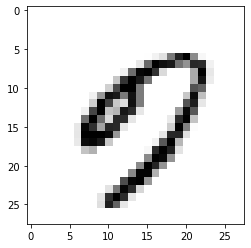



66 [ Predicted Value: 4, Actual Value: 9 ]


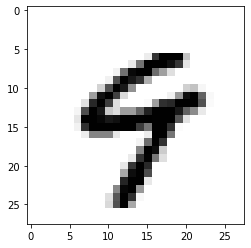

In [19]:
  print('\n********************************For lambda = {}************************************\n'.format(al))
  print('\n#########################Without L1 and L2 Optimisations###########################\n')
  
  train_losses_0, train_acc_0, test_losses_0, test_acc_0 = trainModel('_0')

#Lambda = 0.00005

In [0]:
al = 0.00005  

        

##With L1 Optimisation

  0%|          | 0/938 [00:00<?, ?it/s]


#########################With L1 Optimisation######################################

alpha =  0.005
EPOCH _l1 0


Loss=3.821894645690918 Batch_id=937 Accuracy=90.73: 100%|██████████| 938/938 [00:17<00:00, 59.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0916, Accuracy: 9708/10000 (97.08%)

EPOCH _l1 1


Loss=4.1310200691223145 Batch_id=937 Accuracy=97.59: 100%|██████████| 938/938 [00:17<00:00, 53.40it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0555, Accuracy: 9813/10000 (98.13%)

EPOCH _l1 2


Loss=4.459364891052246 Batch_id=937 Accuracy=97.95: 100%|██████████| 938/938 [00:16<00:00, 55.47it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0412, Accuracy: 9871/10000 (98.71%)

EPOCH _l1 3


Loss=4.651926517486572 Batch_id=937 Accuracy=98.26: 100%|██████████| 938/938 [00:17<00:00, 54.08it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0345, Accuracy: 9888/10000 (98.88%)

EPOCH _l1 4


Loss=4.872102737426758 Batch_id=937 Accuracy=98.47: 100%|██████████| 938/938 [00:17<00:00, 55.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0326, Accuracy: 9889/10000 (98.89%)

EPOCH _l1 5


Loss=5.048768520355225 Batch_id=937 Accuracy=98.50: 100%|██████████| 938/938 [00:16<00:00, 55.95it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9909/10000 (99.09%)

EPOCH _l1 6


Loss=5.132293224334717 Batch_id=937 Accuracy=98.59: 100%|██████████| 938/938 [00:17<00:00, 54.79it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9905/10000 (99.05%)

EPOCH _l1 7


Loss=5.255428314208984 Batch_id=937 Accuracy=98.69: 100%|██████████| 938/938 [00:17<00:00, 59.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9918/10000 (99.18%)

EPOCH _l1 8


Loss=5.411482334136963 Batch_id=937 Accuracy=98.67: 100%|██████████| 938/938 [00:17<00:00, 53.09it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9927/10000 (99.27%)

EPOCH _l1 9


Loss=5.57533597946167 Batch_id=937 Accuracy=98.72: 100%|██████████| 938/938 [00:17<00:00, 53.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9916/10000 (99.16%)

EPOCH _l1 10


Loss=5.619267463684082 Batch_id=937 Accuracy=98.72: 100%|██████████| 938/938 [00:17<00:00, 55.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9928/10000 (99.28%)

EPOCH _l1 11


Loss=5.833370685577393 Batch_id=937 Accuracy=98.81: 100%|██████████| 938/938 [00:17<00:00, 52.97it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9922/10000 (99.22%)

EPOCH _l1 12


Loss=5.985449314117432 Batch_id=937 Accuracy=98.83: 100%|██████████| 938/938 [00:17<00:00, 53.60it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9923/10000 (99.23%)

EPOCH _l1 13


Loss=5.936652183532715 Batch_id=937 Accuracy=98.90: 100%|██████████| 938/938 [00:17<00:00, 54.62it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9928/10000 (99.28%)

EPOCH _l1 14


Loss=6.109405040740967 Batch_id=937 Accuracy=98.93: 100%|██████████| 938/938 [00:17<00:00, 53.60it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9931/10000 (99.31%)

EPOCH _l1 15


Loss=6.088193416595459 Batch_id=937 Accuracy=98.91: 100%|██████████| 938/938 [00:17<00:00, 54.03it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9931/10000 (99.31%)

EPOCH _l1 16


Loss=6.163036823272705 Batch_id=937 Accuracy=98.97: 100%|██████████| 938/938 [00:19<00:00, 48.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9935/10000 (99.35%)

EPOCH _l1 17


Loss=6.334590435028076 Batch_id=937 Accuracy=99.03: 100%|██████████| 938/938 [00:19<00:00, 48.14it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9928/10000 (99.28%)

EPOCH _l1 18


Loss=6.305368423461914 Batch_id=937 Accuracy=98.98: 100%|██████████| 938/938 [00:19<00:00, 48.16it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9928/10000 (99.28%)

EPOCH _l1 19


Loss=6.432011127471924 Batch_id=937 Accuracy=98.97: 100%|██████████| 938/938 [00:19<00:00, 48.28it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9925/10000 (99.25%)

EPOCH _l1 20


Loss=6.4660186767578125 Batch_id=937 Accuracy=99.07: 100%|██████████| 938/938 [00:19<00:00, 47.92it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9932/10000 (99.32%)

EPOCH _l1 21


Loss=6.508643627166748 Batch_id=937 Accuracy=99.09: 100%|██████████| 938/938 [00:19<00:00, 47.55it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9939/10000 (99.39%)

EPOCH _l1 22


Loss=6.612625598907471 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [00:19<00:00, 47.60it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9935/10000 (99.35%)

EPOCH _l1 23


Loss=6.648048400878906 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:19<00:00, 46.92it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9930/10000 (99.30%)

EPOCH _l1 24


Loss=6.706997394561768 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [00:19<00:00, 48.94it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9936/10000 (99.36%)

EPOCH _l1 25


Loss=6.775568008422852 Batch_id=937 Accuracy=99.09: 100%|██████████| 938/938 [00:18<00:00, 51.52it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9930/10000 (99.30%)

EPOCH _l1 26


Loss=6.829222202301025 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:17<00:00, 52.70it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9926/10000 (99.26%)

EPOCH _l1 27


Loss=7.085440635681152 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [00:17<00:00, 52.25it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9919/10000 (99.19%)

EPOCH _l1 28


Loss=7.03206205368042 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:18<00:00, 52.05it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9928/10000 (99.28%)

EPOCH _l1 29


Loss=7.00937557220459 Batch_id=937 Accuracy=99.09: 100%|██████████| 938/938 [00:17<00:00, 62.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9928/10000 (99.28%)

EPOCH _l1 30


Loss=7.06727409362793 Batch_id=937 Accuracy=99.13: 100%|██████████| 938/938 [00:17<00:00, 52.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9936/10000 (99.36%)

EPOCH _l1 31


Loss=7.10271692276001 Batch_id=937 Accuracy=99.09: 100%|██████████| 938/938 [00:18<00:00, 50.26it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9941/10000 (99.41%)

EPOCH _l1 32


Loss=7.156651020050049 Batch_id=937 Accuracy=99.18: 100%|██████████| 938/938 [00:17<00:00, 52.53it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9941/10000 (99.41%)

EPOCH _l1 33


Loss=7.322021007537842 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:17<00:00, 52.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9935/10000 (99.35%)

EPOCH _l1 34


Loss=7.300907611846924 Batch_id=937 Accuracy=99.10: 100%|██████████| 938/938 [00:18<00:00, 50.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0162, Accuracy: 9941/10000 (99.41%)

EPOCH _l1 35


Loss=7.292678356170654 Batch_id=937 Accuracy=99.15: 100%|██████████| 938/938 [00:18<00:00, 51.38it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9934/10000 (99.34%)

EPOCH _l1 36


Loss=7.345573425292969 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [00:18<00:00, 51.77it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Accuracy: 9939/10000 (99.39%)

EPOCH _l1 37


Loss=7.398072719573975 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [00:18<00:00, 50.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9933/10000 (99.33%)

EPOCH _l1 38


Loss=7.433823108673096 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [00:18<00:00, 51.64it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9940/10000 (99.40%)

EPOCH _l1 39


Loss=7.621230125427246 Batch_id=937 Accuracy=99.21: 100%|██████████| 938/938 [00:18<00:00, 50.78it/s]



Test set: Average loss: 0.0166, Accuracy: 9936/10000 (99.36%)


@@@@@@@@@@@@@MISCLASSIFIED IMAGES@@@@@@@@@@@@@@@@@@@@@@@@@@@



1 [ Predicted Value: 7, Actual Value: 2 ]


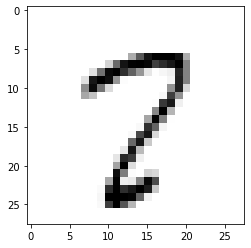



2 [ Predicted Value: 7, Actual Value: 2 ]


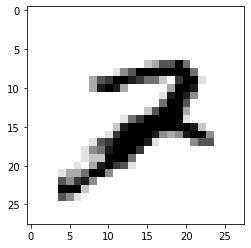



3 [ Predicted Value: 7, Actual Value: 2 ]


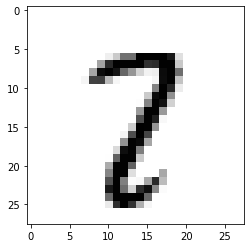



4 [ Predicted Value: 5, Actual Value: 8 ]


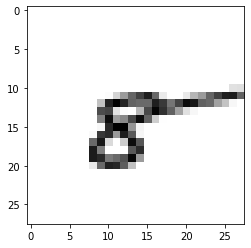



5 [ Predicted Value: 4, Actual Value: 9 ]


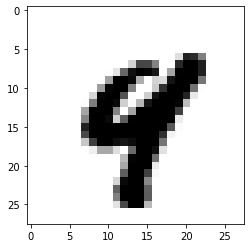



6 [ Predicted Value: 9, Actual Value: 8 ]


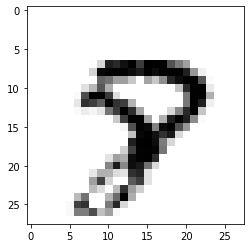



7 [ Predicted Value: 9, Actual Value: 4 ]


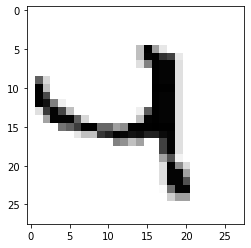



8 [ Predicted Value: 7, Actual Value: 8 ]


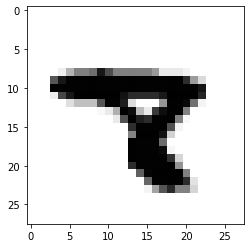



9 [ Predicted Value: 0, Actual Value: 2 ]


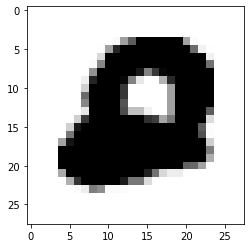



10 [ Predicted Value: 7, Actual Value: 9 ]


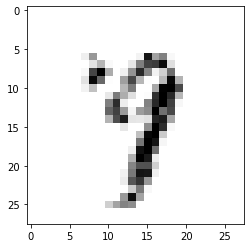



11 [ Predicted Value: 0, Actual Value: 6 ]


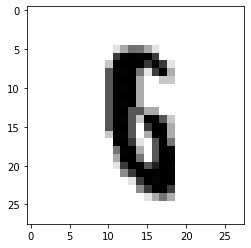



12 [ Predicted Value: 1, Actual Value: 6 ]


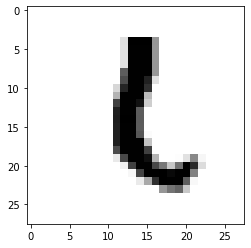



13 [ Predicted Value: 6, Actual Value: 4 ]


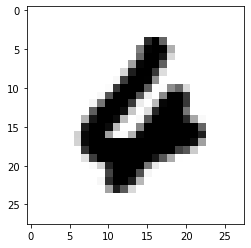



14 [ Predicted Value: 7, Actual Value: 4 ]


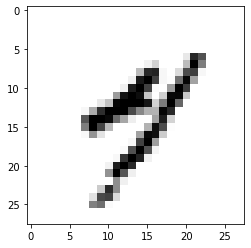



15 [ Predicted Value: 3, Actual Value: 7 ]


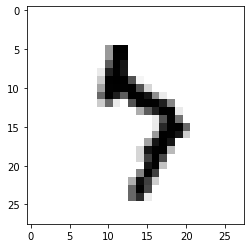



16 [ Predicted Value: 9, Actual Value: 4 ]


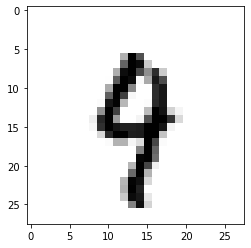



17 [ Predicted Value: 3, Actual Value: 5 ]


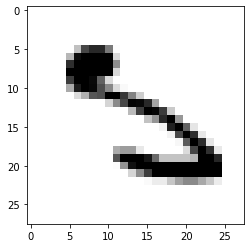



18 [ Predicted Value: 9, Actual Value: 4 ]


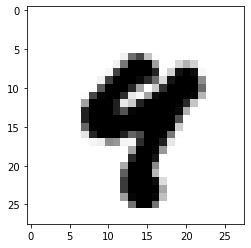



19 [ Predicted Value: 2, Actual Value: 3 ]


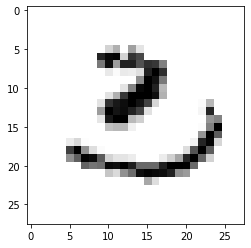



20 [ Predicted Value: 6, Actual Value: 5 ]


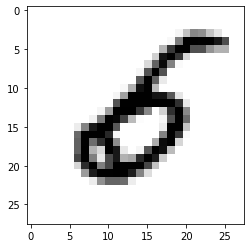



21 [ Predicted Value: 0, Actual Value: 5 ]


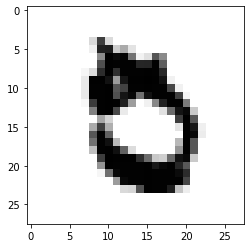



22 [ Predicted Value: 3, Actual Value: 1 ]


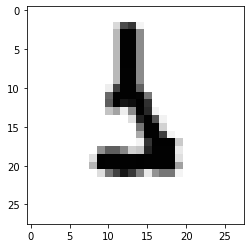



23 [ Predicted Value: 3, Actual Value: 5 ]


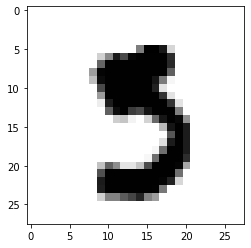



24 [ Predicted Value: 2, Actual Value: 3 ]


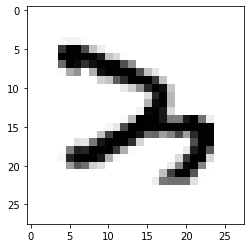



25 [ Predicted Value: 1, Actual Value: 6 ]


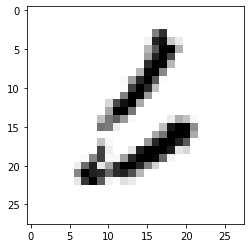



26 [ Predicted Value: 2, Actual Value: 7 ]


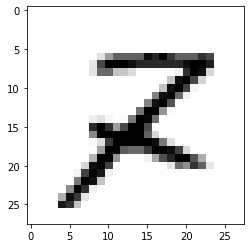



27 [ Predicted Value: 4, Actual Value: 9 ]


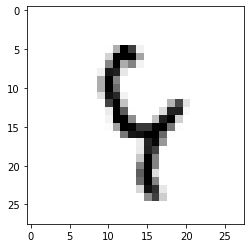



28 [ Predicted Value: 5, Actual Value: 3 ]


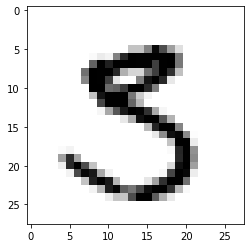



29 [ Predicted Value: 9, Actual Value: 3 ]


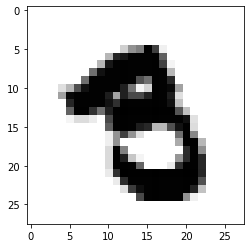



30 [ Predicted Value: 0, Actual Value: 6 ]


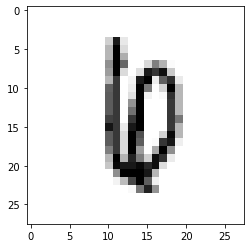



31 [ Predicted Value: 3, Actual Value: 8 ]


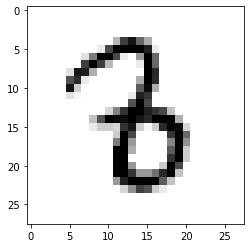



32 [ Predicted Value: 4, Actual Value: 9 ]


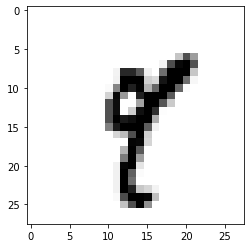



33 [ Predicted Value: 5, Actual Value: 9 ]


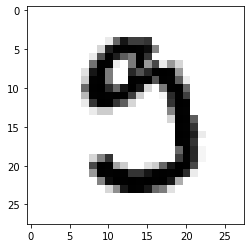



34 [ Predicted Value: 3, Actual Value: 5 ]


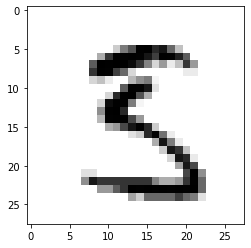



35 [ Predicted Value: 4, Actual Value: 6 ]


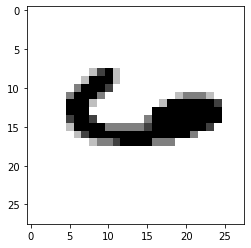



36 [ Predicted Value: 5, Actual Value: 3 ]


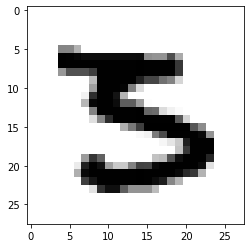



37 [ Predicted Value: 0, Actual Value: 6 ]


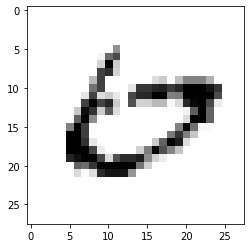



38 [ Predicted Value: 2, Actual Value: 6 ]


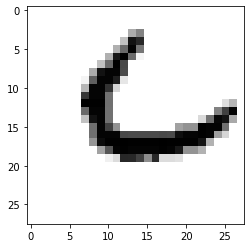



39 [ Predicted Value: 1, Actual Value: 2 ]


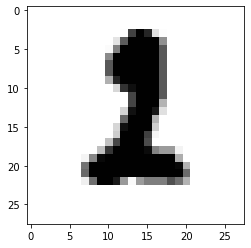



40 [ Predicted Value: 1, Actual Value: 6 ]


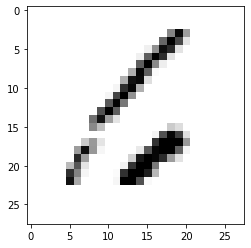



41 [ Predicted Value: 4, Actual Value: 9 ]


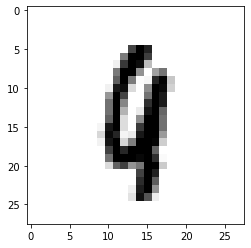



42 [ Predicted Value: 4, Actual Value: 6 ]


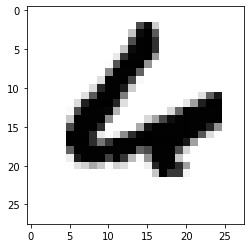



43 [ Predicted Value: 5, Actual Value: 3 ]


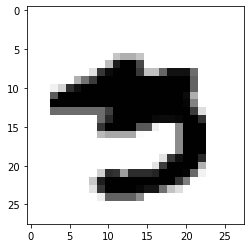



44 [ Predicted Value: 9, Actual Value: 8 ]


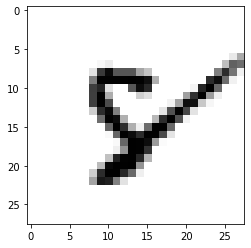



45 [ Predicted Value: 5, Actual Value: 3 ]


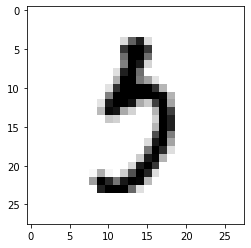



46 [ Predicted Value: 0, Actual Value: 6 ]


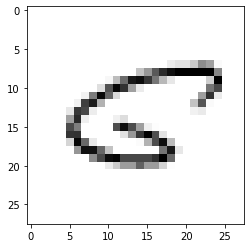



47 [ Predicted Value: 1, Actual Value: 3 ]


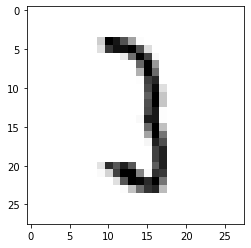



48 [ Predicted Value: 2, Actual Value: 7 ]


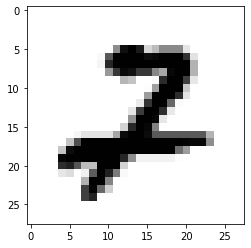



49 [ Predicted Value: 9, Actual Value: 8 ]


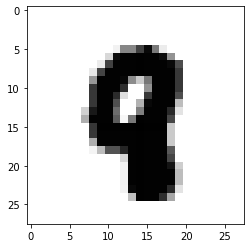



50 [ Predicted Value: 4, Actual Value: 9 ]


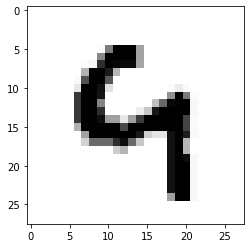



51 [ Predicted Value: 6, Actual Value: 5 ]


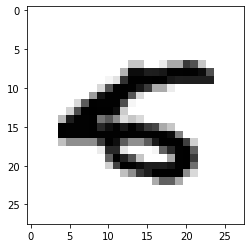



52 [ Predicted Value: 4, Actual Value: 9 ]


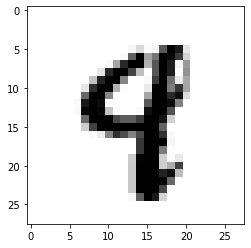



53 [ Predicted Value: 3, Actual Value: 1 ]


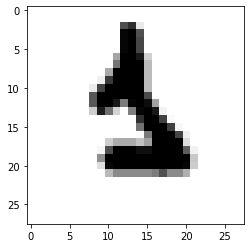



54 [ Predicted Value: 2, Actual Value: 8 ]


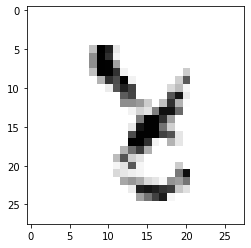



55 [ Predicted Value: 0, Actual Value: 6 ]


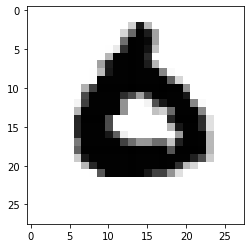



56 [ Predicted Value: 0, Actual Value: 6 ]


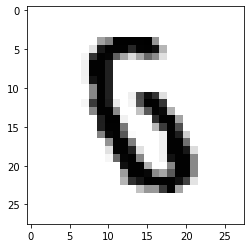



57 [ Predicted Value: 2, Actual Value: 1 ]


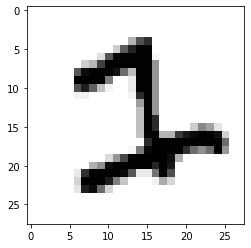



58 [ Predicted Value: 2, Actual Value: 4 ]


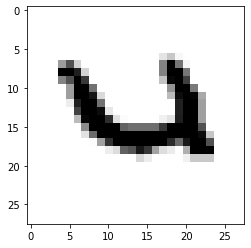



59 [ Predicted Value: 7, Actual Value: 2 ]


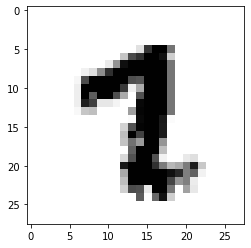



60 [ Predicted Value: 2, Actual Value: 0 ]


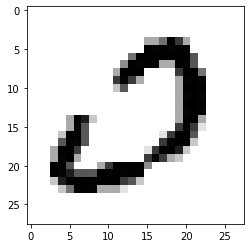



61 [ Predicted Value: 1, Actual Value: 7 ]


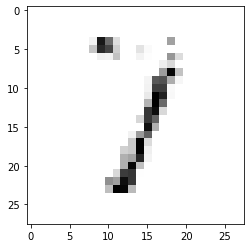



62 [ Predicted Value: 2, Actual Value: 6 ]


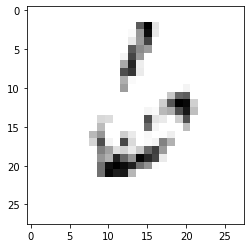



63 [ Predicted Value: 7, Actual Value: 9 ]


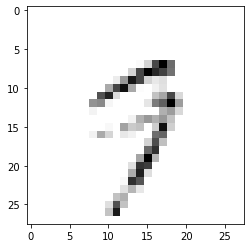



64 [ Predicted Value: 4, Actual Value: 9 ]


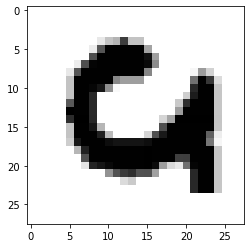

In [36]:
print('\n#########################With L1 Optimisation######################################\n')

train_losses_l1, train_acc_l1, test_losses_l1, test_acc_l1 = trainModel('_l1', L1_Flag =True, L2_Flag = False, alpha = al )


##With L2 Optimisation

  0%|          | 0/938 [00:00<?, ?it/s]


#########################With L2 Optimisation######################################

alpha =  0.005
EPOCH _l2 0


Loss=1.3454090356826782 Batch_id=937 Accuracy=91.34: 100%|██████████| 938/938 [00:18<00:00, 50.19it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0527, Accuracy: 9859/10000 (98.59%)

EPOCH _l2 1


Loss=1.6735286712646484 Batch_id=937 Accuracy=97.58: 100%|██████████| 938/938 [00:18<00:00, 50.73it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0465, Accuracy: 9845/10000 (98.45%)

EPOCH _l2 2


Loss=1.6962401866912842 Batch_id=937 Accuracy=98.04: 100%|██████████| 938/938 [00:19<00:00, 48.94it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0397, Accuracy: 9878/10000 (98.78%)

EPOCH _l2 3


Loss=1.78373384475708 Batch_id=937 Accuracy=98.25: 100%|██████████| 938/938 [00:18<00:00, 50.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0314, Accuracy: 9891/10000 (98.91%)

EPOCH _l2 4


Loss=1.892242431640625 Batch_id=937 Accuracy=98.44: 100%|██████████| 938/938 [00:18<00:00, 51.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Accuracy: 9897/10000 (98.97%)

EPOCH _l2 5


Loss=1.9763984680175781 Batch_id=937 Accuracy=98.48: 100%|██████████| 938/938 [00:18<00:00, 50.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9913/10000 (99.13%)

EPOCH _l2 6


Loss=2.2450084686279297 Batch_id=937 Accuracy=98.56: 100%|██████████| 938/938 [00:19<00:00, 49.03it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0314, Accuracy: 9894/10000 (98.94%)

EPOCH _l2 7


Loss=2.186399221420288 Batch_id=937 Accuracy=98.67: 100%|██████████| 938/938 [00:18<00:00, 50.52it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9925/10000 (99.25%)

EPOCH _l2 8


Loss=2.341736078262329 Batch_id=937 Accuracy=98.68: 100%|██████████| 938/938 [00:18<00:00, 51.08it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9917/10000 (99.17%)

EPOCH _l2 9


Loss=2.340987205505371 Batch_id=937 Accuracy=98.74: 100%|██████████| 938/938 [00:18<00:00, 50.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9924/10000 (99.24%)

EPOCH _l2 10


Loss=2.3656957149505615 Batch_id=937 Accuracy=98.75: 100%|██████████| 938/938 [00:18<00:00, 50.23it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9925/10000 (99.25%)

EPOCH _l2 11


Loss=2.410266160964966 Batch_id=937 Accuracy=98.80: 100%|██████████| 938/938 [00:18<00:00, 50.55it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9924/10000 (99.24%)

EPOCH _l2 12


Loss=2.464655637741089 Batch_id=937 Accuracy=98.86: 100%|██████████| 938/938 [00:18<00:00, 50.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9922/10000 (99.22%)

EPOCH _l2 13


Loss=2.5379245281219482 Batch_id=937 Accuracy=98.86: 100%|██████████| 938/938 [00:18<00:00, 51.19it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9931/10000 (99.31%)

EPOCH _l2 14


Loss=2.600001573562622 Batch_id=937 Accuracy=98.92: 100%|██████████| 938/938 [00:18<00:00, 50.25it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9930/10000 (99.30%)

EPOCH _l2 15


Loss=2.6352903842926025 Batch_id=937 Accuracy=98.91: 100%|██████████| 938/938 [00:18<00:00, 50.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9933/10000 (99.33%)

EPOCH _l2 16


Loss=2.6814568042755127 Batch_id=937 Accuracy=98.97: 100%|██████████| 938/938 [00:18<00:00, 61.29it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9930/10000 (99.30%)

EPOCH _l2 17


Loss=2.724874496459961 Batch_id=937 Accuracy=98.91: 100%|██████████| 938/938 [00:18<00:00, 50.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9939/10000 (99.39%)

EPOCH _l2 18


Loss=2.897064447402954 Batch_id=937 Accuracy=99.03: 100%|██████████| 938/938 [00:18<00:00, 50.14it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9932/10000 (99.32%)

EPOCH _l2 19


Loss=2.84999942779541 Batch_id=937 Accuracy=98.94: 100%|██████████| 938/938 [00:18<00:00, 51.17it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9927/10000 (99.27%)

EPOCH _l2 20


Loss=2.8899781703948975 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [00:18<00:00, 50.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9938/10000 (99.38%)

EPOCH _l2 21


Loss=2.9193522930145264 Batch_id=937 Accuracy=99.01: 100%|██████████| 938/938 [00:18<00:00, 50.34it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9943/10000 (99.43%)

EPOCH _l2 22


Loss=3.2280538082122803 Batch_id=937 Accuracy=99.01: 100%|██████████| 938/938 [00:18<00:00, 50.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9934/10000 (99.34%)

EPOCH _l2 23


Loss=3.0334203243255615 Batch_id=937 Accuracy=99.03: 100%|██████████| 938/938 [00:18<00:00, 49.45it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9923/10000 (99.23%)

EPOCH _l2 24


Loss=3.1351826190948486 Batch_id=937 Accuracy=99.03: 100%|██████████| 938/938 [00:18<00:00, 50.64it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9938/10000 (99.38%)

EPOCH _l2 25


Loss=3.093630790710449 Batch_id=937 Accuracy=99.13: 100%|██████████| 938/938 [00:18<00:00, 50.27it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9927/10000 (99.27%)

EPOCH _l2 26


Loss=3.1236326694488525 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [00:19<00:00, 48.75it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9932/10000 (99.32%)

EPOCH _l2 27


Loss=3.167234420776367 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:18<00:00, 51.12it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9937/10000 (99.37%)

EPOCH _l2 28


Loss=3.522083282470703 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [00:18<00:00, 51.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9936/10000 (99.36%)

EPOCH _l2 29


Loss=3.2404367923736572 Batch_id=937 Accuracy=99.13: 100%|██████████| 938/938 [00:18<00:00, 49.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9939/10000 (99.39%)

EPOCH _l2 30


Loss=3.294890880584717 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:18<00:00, 56.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9937/10000 (99.37%)

EPOCH _l2 31


Loss=3.3242411613464355 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:18<00:00, 50.91it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9921/10000 (99.21%)

EPOCH _l2 32


Loss=3.354525566101074 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:19<00:00, 49.05it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9931/10000 (99.31%)

EPOCH _l2 33


Loss=3.463804006576538 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [00:18<00:00, 50.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9942/10000 (99.42%)

EPOCH _l2 34


Loss=3.4177627563476562 Batch_id=937 Accuracy=99.13: 100%|██████████| 938/938 [00:18<00:00, 50.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9939/10000 (99.39%)

EPOCH _l2 35


Loss=3.4878592491149902 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:18<00:00, 49.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9932/10000 (99.32%)

EPOCH _l2 36


Loss=3.498101234436035 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:18<00:00, 56.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9938/10000 (99.38%)

EPOCH _l2 37


Loss=3.544053792953491 Batch_id=937 Accuracy=99.13: 100%|██████████| 938/938 [00:18<00:00, 50.57it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9940/10000 (99.40%)

EPOCH _l2 38


Loss=3.5581672191619873 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:19<00:00, 48.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9941/10000 (99.41%)

EPOCH _l2 39


Loss=3.6345982551574707 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [00:18<00:00, 50.74it/s]



Test set: Average loss: 0.0170, Accuracy: 9950/10000 (99.50%)


@@@@@@@@@@@@@MISCLASSIFIED IMAGES@@@@@@@@@@@@@@@@@@@@@@@@@@@



1 [ Predicted Value: 3, Actual Value: 1 ]


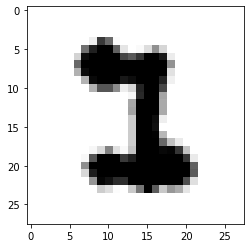



2 [ Predicted Value: 6, Actual Value: 5 ]


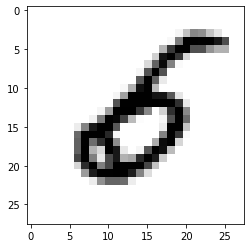



3 [ Predicted Value: 3, Actual Value: 5 ]


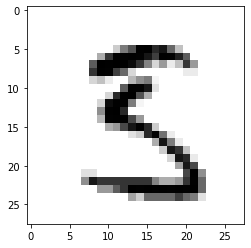



4 [ Predicted Value: 4, Actual Value: 9 ]


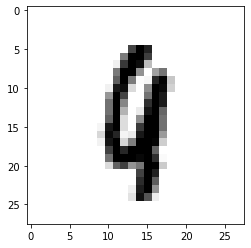



5 [ Predicted Value: 5, Actual Value: 3 ]


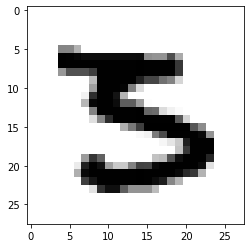



6 [ Predicted Value: 2, Actual Value: 9 ]


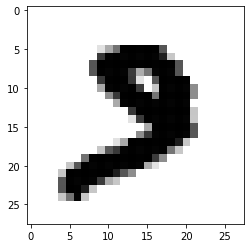



7 [ Predicted Value: 9, Actual Value: 4 ]


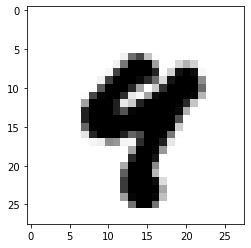



8 [ Predicted Value: 4, Actual Value: 6 ]


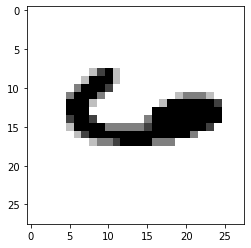



9 [ Predicted Value: 7, Actual Value: 0 ]


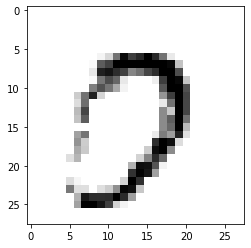



10 [ Predicted Value: 4, Actual Value: 9 ]


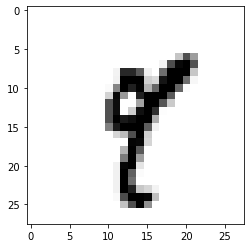



11 [ Predicted Value: 2, Actual Value: 1 ]


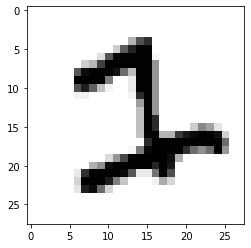



12 [ Predicted Value: 3, Actual Value: 8 ]


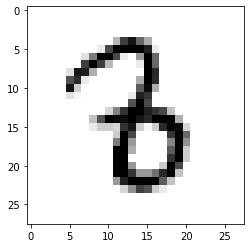



13 [ Predicted Value: 3, Actual Value: 5 ]


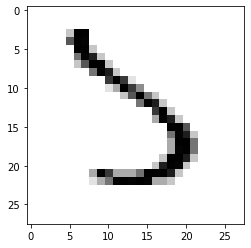



14 [ Predicted Value: 6, Actual Value: 0 ]


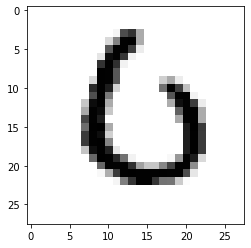



15 [ Predicted Value: 4, Actual Value: 9 ]


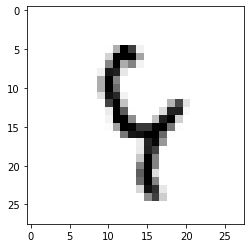



16 [ Predicted Value: 7, Actual Value: 3 ]


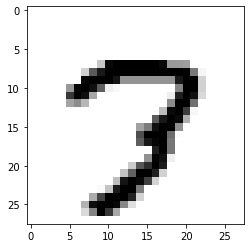



17 [ Predicted Value: 2, Actual Value: 6 ]


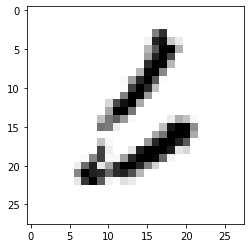



18 [ Predicted Value: 2, Actual Value: 7 ]


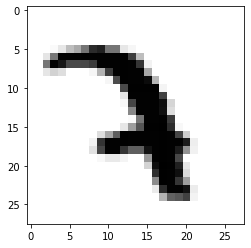



19 [ Predicted Value: 5, Actual Value: 8 ]


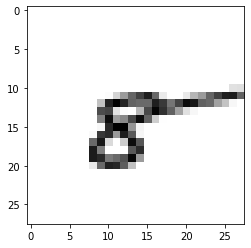



20 [ Predicted Value: 1, Actual Value: 6 ]


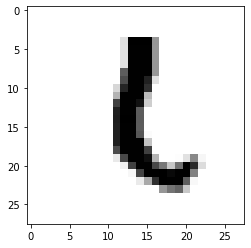



21 [ Predicted Value: 6, Actual Value: 4 ]


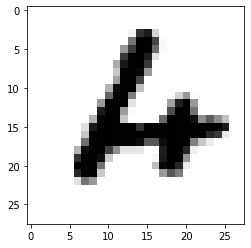



22 [ Predicted Value: 3, Actual Value: 9 ]


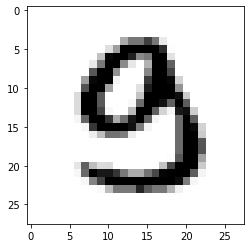



23 [ Predicted Value: 5, Actual Value: 6 ]


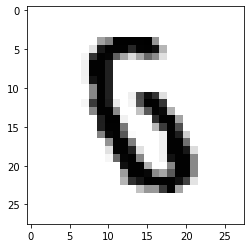



24 [ Predicted Value: 4, Actual Value: 9 ]


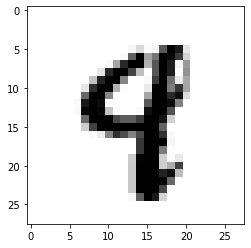



25 [ Predicted Value: 1, Actual Value: 6 ]


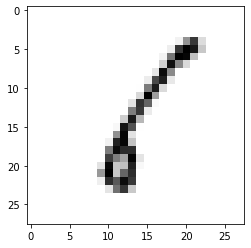



26 [ Predicted Value: 7, Actual Value: 2 ]


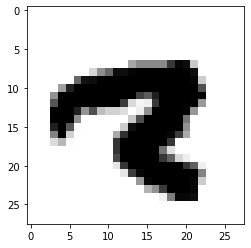



27 [ Predicted Value: 5, Actual Value: 3 ]


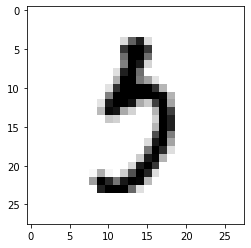



28 [ Predicted Value: 2, Actual Value: 8 ]


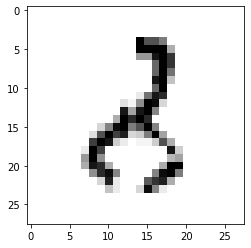



29 [ Predicted Value: 5, Actual Value: 6 ]


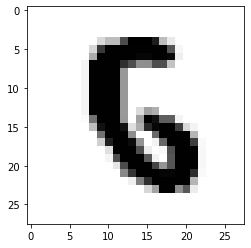



30 [ Predicted Value: 2, Actual Value: 7 ]


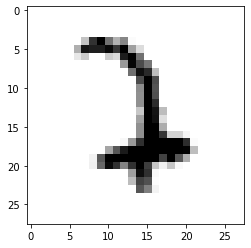



31 [ Predicted Value: 9, Actual Value: 4 ]


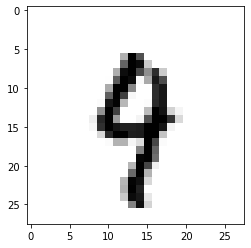



32 [ Predicted Value: 0, Actual Value: 5 ]


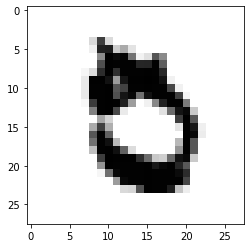



33 [ Predicted Value: 1, Actual Value: 7 ]


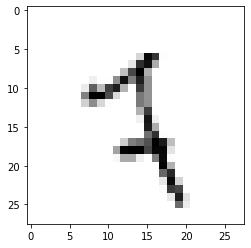



34 [ Predicted Value: 3, Actual Value: 5 ]


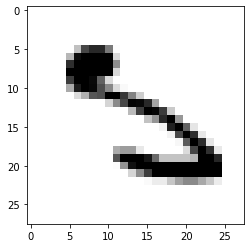



35 [ Predicted Value: 7, Actual Value: 9 ]


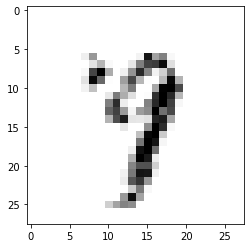



36 [ Predicted Value: 6, Actual Value: 9 ]


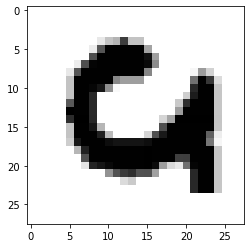



37 [ Predicted Value: 1, Actual Value: 7 ]


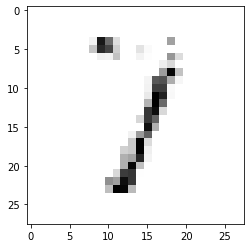



38 [ Predicted Value: 1, Actual Value: 7 ]


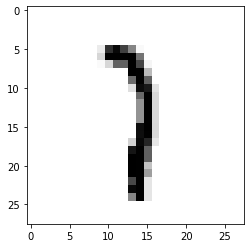



39 [ Predicted Value: 5, Actual Value: 9 ]


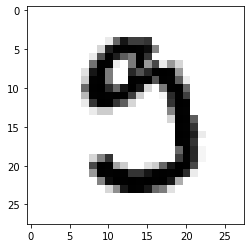



40 [ Predicted Value: 2, Actual Value: 8 ]


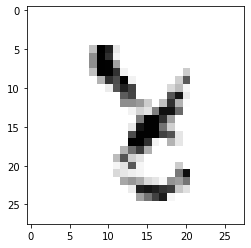



41 [ Predicted Value: 7, Actual Value: 2 ]


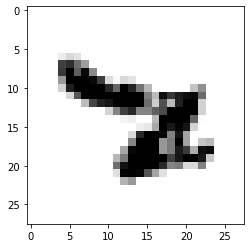



42 [ Predicted Value: 7, Actual Value: 8 ]


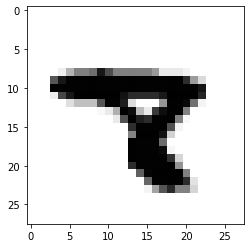



43 [ Predicted Value: 3, Actual Value: 5 ]


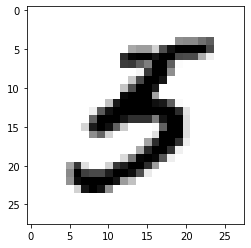



44 [ Predicted Value: 5, Actual Value: 6 ]


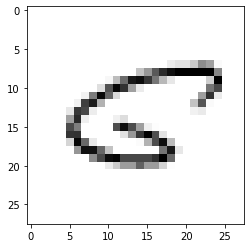



45 [ Predicted Value: 0, Actual Value: 6 ]


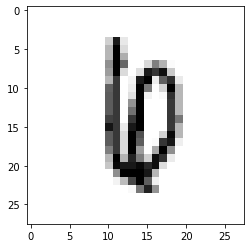



46 [ Predicted Value: 0, Actual Value: 6 ]


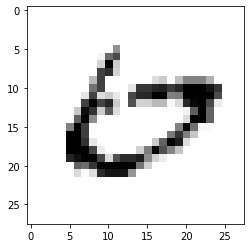



47 [ Predicted Value: 6, Actual Value: 4 ]


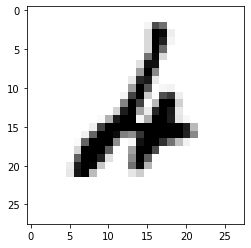



48 [ Predicted Value: 8, Actual Value: 2 ]


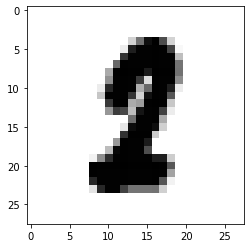



49 [ Predicted Value: 4, Actual Value: 9 ]


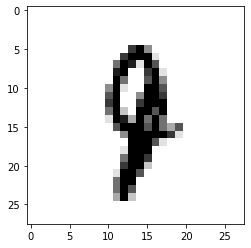



50 [ Predicted Value: 6, Actual Value: 4 ]


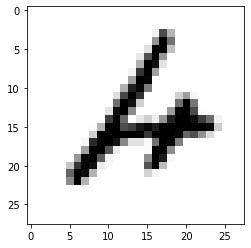

In [37]:
print('\n#########################With L2 Optimisation######################################\n')

train_losses_l2, train_acc_l2, test_losses_l2, test_acc_l2 = trainModel('_l2', L1_Flag =False, L2_Flag = True, alpha = al )

##With Both L1 and L2 Optimisations

  0%|          | 0/938 [00:00<?, ?it/s]


################With Both L1 and L2 Optimisations##################################

alpha =  0.005
EPOCH _l1_l2 0


Loss=5.025277614593506 Batch_id=937 Accuracy=91.54: 100%|██████████| 938/938 [00:19<00:00, 47.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0530, Accuracy: 9826/10000 (98.26%)

EPOCH _l1_l2 1


Loss=5.617771148681641 Batch_id=937 Accuracy=97.50: 100%|██████████| 938/938 [00:19<00:00, 48.03it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0525, Accuracy: 9845/10000 (98.45%)

EPOCH _l1_l2 2


Loss=6.106752395629883 Batch_id=937 Accuracy=98.08: 100%|██████████| 938/938 [00:20<00:00, 45.70it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0355, Accuracy: 9894/10000 (98.94%)

EPOCH _l1_l2 3


Loss=6.437373638153076 Batch_id=937 Accuracy=98.30: 100%|██████████| 938/938 [00:19<00:00, 47.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0420, Accuracy: 9857/10000 (98.57%)

EPOCH _l1_l2 4


Loss=6.741186618804932 Batch_id=937 Accuracy=98.45: 100%|██████████| 938/938 [00:19<00:00, 48.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0366, Accuracy: 9877/10000 (98.77%)

EPOCH _l1_l2 5


Loss=7.0065999031066895 Batch_id=937 Accuracy=98.52: 100%|██████████| 938/938 [00:19<00:00, 47.73it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9912/10000 (99.12%)

EPOCH _l1_l2 6


Loss=7.186031341552734 Batch_id=937 Accuracy=98.65: 100%|██████████| 938/938 [00:19<00:00, 48.40it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9910/10000 (99.10%)

EPOCH _l1_l2 7


Loss=7.374888896942139 Batch_id=937 Accuracy=98.62: 100%|██████████| 938/938 [00:19<00:00, 48.03it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9913/10000 (99.13%)

EPOCH _l1_l2 8


Loss=7.562485218048096 Batch_id=937 Accuracy=98.65: 100%|██████████| 938/938 [00:19<00:00, 47.31it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Accuracy: 9902/10000 (99.02%)

EPOCH _l1_l2 9


Loss=7.82399845123291 Batch_id=937 Accuracy=98.78: 100%|██████████| 938/938 [00:20<00:00, 53.79it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9912/10000 (99.12%)

EPOCH _l1_l2 10


Loss=7.913885593414307 Batch_id=937 Accuracy=98.79: 100%|██████████| 938/938 [00:21<00:00, 44.53it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9912/10000 (99.12%)

EPOCH _l1_l2 11


Loss=8.17209529876709 Batch_id=937 Accuracy=98.83: 100%|██████████| 938/938 [00:19<00:00, 47.27it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9922/10000 (99.22%)

EPOCH _l1_l2 12


Loss=8.224409103393555 Batch_id=937 Accuracy=98.81: 100%|██████████| 938/938 [00:19<00:00, 47.23it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9917/10000 (99.17%)

EPOCH _l1_l2 13


Loss=8.364357948303223 Batch_id=937 Accuracy=98.84: 100%|██████████| 938/938 [00:20<00:00, 58.43it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9923/10000 (99.23%)

EPOCH _l1_l2 14


Loss=8.51555061340332 Batch_id=937 Accuracy=98.92: 100%|██████████| 938/938 [00:19<00:00, 47.29it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9909/10000 (99.09%)

EPOCH _l1_l2 15


Loss=8.646916389465332 Batch_id=937 Accuracy=98.92: 100%|██████████| 938/938 [00:19<00:00, 48.73it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9915/10000 (99.15%)

EPOCH _l1_l2 16


Loss=8.792933464050293 Batch_id=937 Accuracy=98.97: 100%|██████████| 938/938 [00:19<00:00, 48.20it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9921/10000 (99.21%)

EPOCH _l1_l2 17


Loss=8.91469955444336 Batch_id=937 Accuracy=98.90: 100%|██████████| 938/938 [00:19<00:00, 47.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9911/10000 (99.11%)

EPOCH _l1_l2 18


Loss=9.029577255249023 Batch_id=937 Accuracy=98.89: 100%|██████████| 938/938 [00:19<00:00, 48.51it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9926/10000 (99.26%)

EPOCH _l1_l2 19


Loss=9.231847763061523 Batch_id=937 Accuracy=98.95: 100%|██████████| 938/938 [00:19<00:00, 48.65it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9921/10000 (99.21%)

EPOCH _l1_l2 20


Loss=9.477420806884766 Batch_id=937 Accuracy=98.97: 100%|██████████| 938/938 [00:20<00:00, 46.86it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9913/10000 (99.13%)

EPOCH _l1_l2 21


Loss=9.390486717224121 Batch_id=937 Accuracy=99.01: 100%|██████████| 938/938 [00:20<00:00, 45.45it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9908/10000 (99.08%)

EPOCH _l1_l2 22


Loss=9.489873886108398 Batch_id=937 Accuracy=98.99: 100%|██████████| 938/938 [00:21<00:00, 44.30it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9926/10000 (99.26%)

EPOCH _l1_l2 23


Loss=9.722264289855957 Batch_id=937 Accuracy=99.03: 100%|██████████| 938/938 [00:21<00:00, 43.37it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9929/10000 (99.29%)

EPOCH _l1_l2 24


Loss=9.695959091186523 Batch_id=937 Accuracy=99.07: 100%|██████████| 938/938 [00:21<00:00, 43.51it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9915/10000 (99.15%)

EPOCH _l1_l2 25


Loss=9.787768363952637 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [00:21<00:00, 43.33it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9924/10000 (99.24%)

EPOCH _l1_l2 26


Loss=9.922746658325195 Batch_id=937 Accuracy=98.98: 100%|██████████| 938/938 [00:21<00:00, 44.21it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9926/10000 (99.26%)

EPOCH _l1_l2 27


Loss=9.99144172668457 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [00:21<00:00, 43.51it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9906/10000 (99.06%)

EPOCH _l1_l2 28


Loss=10.086767196655273 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [00:21<00:00, 43.01it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9915/10000 (99.15%)

EPOCH _l1_l2 29


Loss=10.258026123046875 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [00:20<00:00, 45.09it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9919/10000 (99.19%)

EPOCH _l1_l2 30


Loss=10.37885570526123 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [00:20<00:00, 46.26it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9920/10000 (99.20%)

EPOCH _l1_l2 31


Loss=10.374201774597168 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:19<00:00, 48.05it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9924/10000 (99.24%)

EPOCH _l1_l2 32


Loss=10.447160720825195 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [00:19<00:00, 48.10it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9910/10000 (99.10%)

EPOCH _l1_l2 33


Loss=10.532198905944824 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [00:19<00:00, 47.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9914/10000 (99.14%)

EPOCH _l1_l2 34


Loss=10.898786544799805 Batch_id=937 Accuracy=99.04: 100%|██████████| 938/938 [00:19<00:00, 47.17it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9926/10000 (99.26%)

EPOCH _l1_l2 35


Loss=10.712512016296387 Batch_id=937 Accuracy=99.07: 100%|██████████| 938/938 [00:19<00:00, 47.62it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9915/10000 (99.15%)

EPOCH _l1_l2 36


Loss=10.835613250732422 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:19<00:00, 47.12it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9923/10000 (99.23%)

EPOCH _l1_l2 37


Loss=10.917800903320312 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [00:20<00:00, 46.67it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9919/10000 (99.19%)

EPOCH _l1_l2 38


Loss=10.992706298828125 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [00:19<00:00, 55.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9917/10000 (99.17%)

EPOCH _l1_l2 39


Loss=11.090834617614746 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:19<00:00, 47.26it/s]



Test set: Average loss: 0.0235, Accuracy: 9932/10000 (99.32%)


@@@@@@@@@@@@@MISCLASSIFIED IMAGES@@@@@@@@@@@@@@@@@@@@@@@@@@@



1 [ Predicted Value: 0, Actual Value: 5 ]


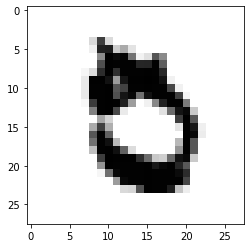



2 [ Predicted Value: 7, Actual Value: 9 ]


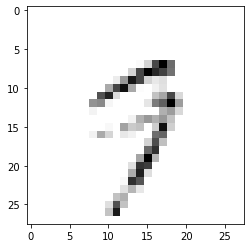



3 [ Predicted Value: 1, Actual Value: 6 ]


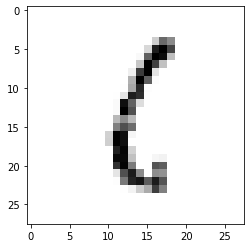



4 [ Predicted Value: 2, Actual Value: 7 ]


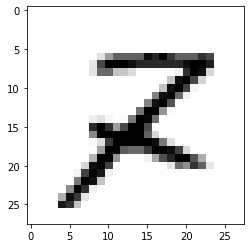



5 [ Predicted Value: 4, Actual Value: 9 ]


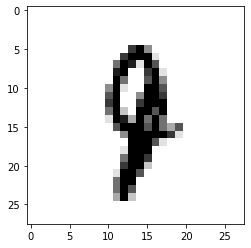



6 [ Predicted Value: 1, Actual Value: 9 ]


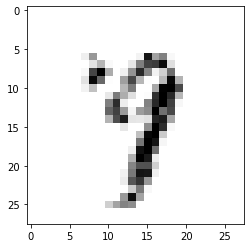



7 [ Predicted Value: 1, Actual Value: 8 ]


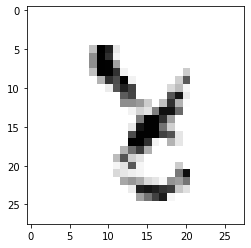



8 [ Predicted Value: 3, Actual Value: 5 ]


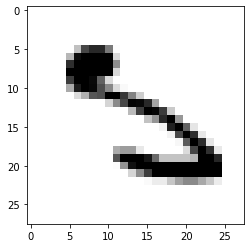



9 [ Predicted Value: 0, Actual Value: 6 ]


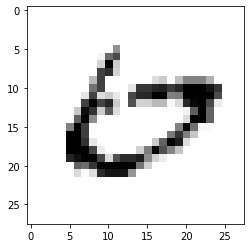



10 [ Predicted Value: 5, Actual Value: 8 ]


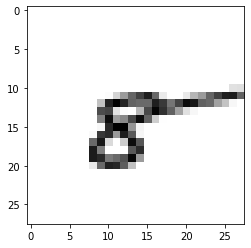



11 [ Predicted Value: 5, Actual Value: 6 ]


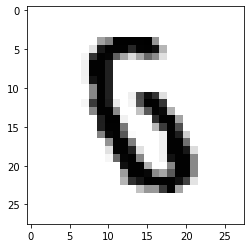



12 [ Predicted Value: 4, Actual Value: 6 ]


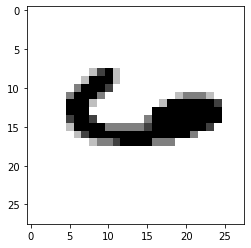



13 [ Predicted Value: 3, Actual Value: 8 ]


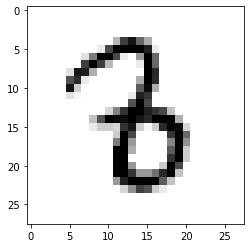



14 [ Predicted Value: 1, Actual Value: 6 ]


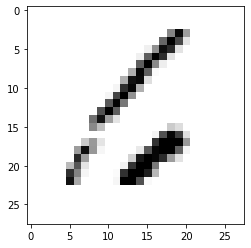



15 [ Predicted Value: 1, Actual Value: 7 ]


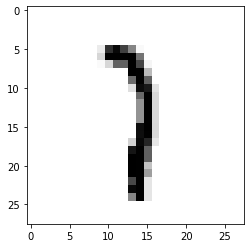



16 [ Predicted Value: 7, Actual Value: 2 ]


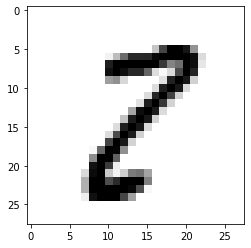



17 [ Predicted Value: 7, Actual Value: 2 ]


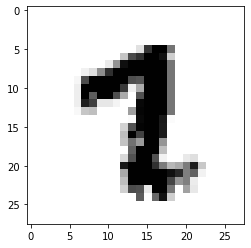



18 [ Predicted Value: 4, Actual Value: 9 ]


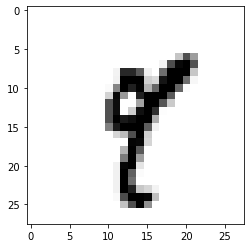



19 [ Predicted Value: 2, Actual Value: 8 ]


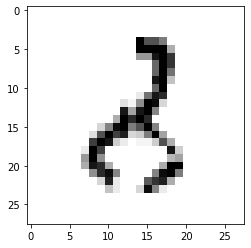



20 [ Predicted Value: 7, Actual Value: 2 ]


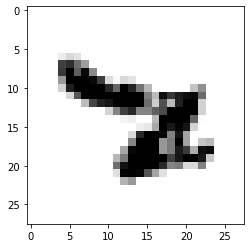



21 [ Predicted Value: 2, Actual Value: 0 ]


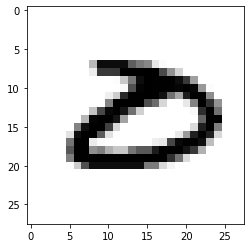



22 [ Predicted Value: 3, Actual Value: 5 ]


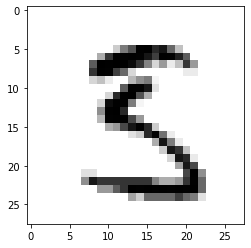



23 [ Predicted Value: 1, Actual Value: 7 ]


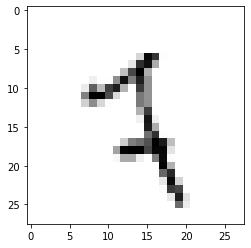



24 [ Predicted Value: 4, Actual Value: 6 ]


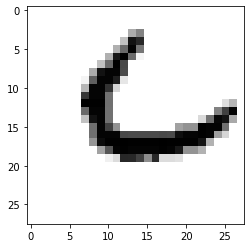



25 [ Predicted Value: 1, Actual Value: 4 ]


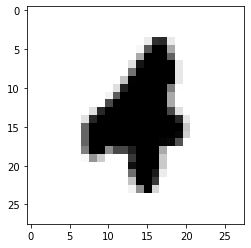



26 [ Predicted Value: 7, Actual Value: 0 ]


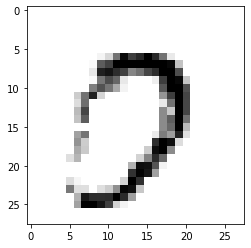



27 [ Predicted Value: 8, Actual Value: 6 ]


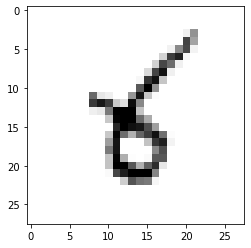



28 [ Predicted Value: 2, Actual Value: 7 ]


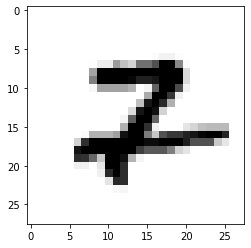



29 [ Predicted Value: 5, Actual Value: 3 ]


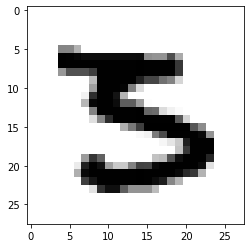



30 [ Predicted Value: 4, Actual Value: 6 ]


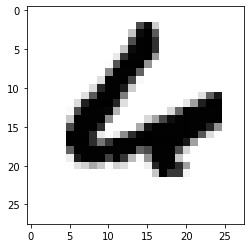



31 [ Predicted Value: 0, Actual Value: 6 ]


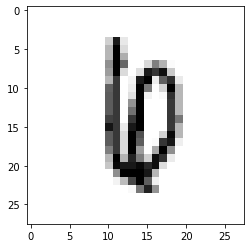



32 [ Predicted Value: 1, Actual Value: 6 ]


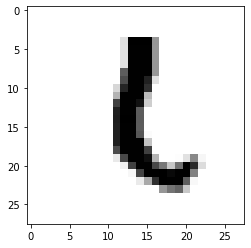



33 [ Predicted Value: 9, Actual Value: 4 ]


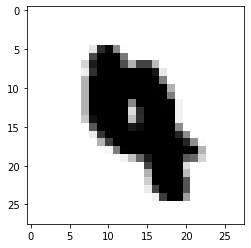



34 [ Predicted Value: 1, Actual Value: 7 ]


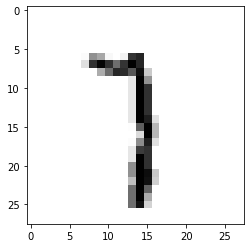



35 [ Predicted Value: 9, Actual Value: 8 ]


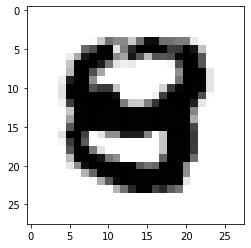



36 [ Predicted Value: 7, Actual Value: 5 ]


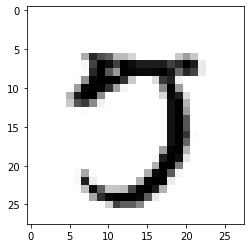



37 [ Predicted Value: 4, Actual Value: 9 ]


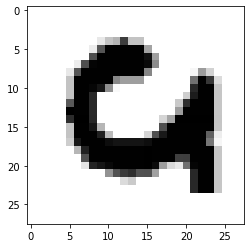



38 [ Predicted Value: 2, Actual Value: 7 ]


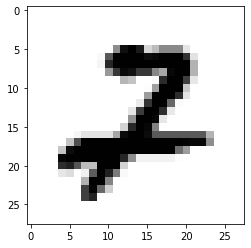



39 [ Predicted Value: 1, Actual Value: 6 ]


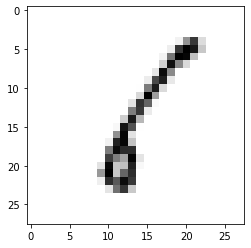



40 [ Predicted Value: 7, Actual Value: 2 ]


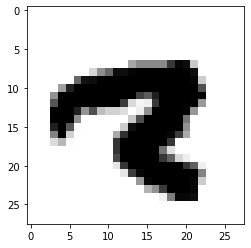



41 [ Predicted Value: 4, Actual Value: 9 ]


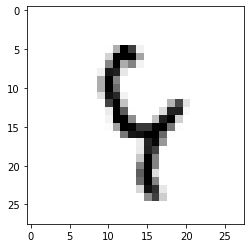



42 [ Predicted Value: 1, Actual Value: 4 ]


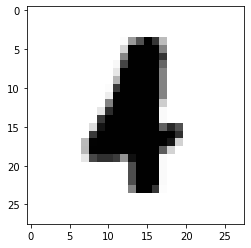



43 [ Predicted Value: 1, Actual Value: 7 ]


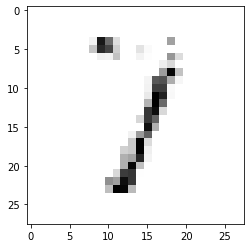



44 [ Predicted Value: 0, Actual Value: 6 ]


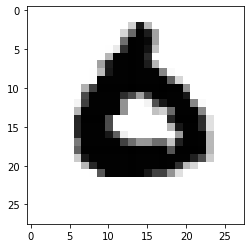



45 [ Predicted Value: 2, Actual Value: 6 ]


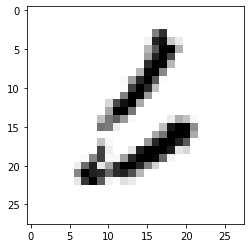



46 [ Predicted Value: 4, Actual Value: 9 ]


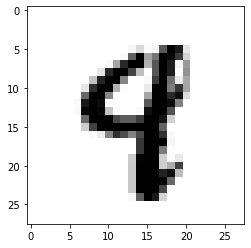



47 [ Predicted Value: 3, Actual Value: 5 ]


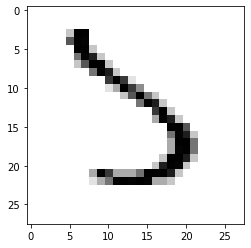



48 [ Predicted Value: 5, Actual Value: 3 ]


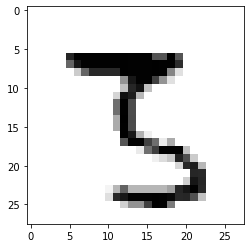



49 [ Predicted Value: 2, Actual Value: 7 ]


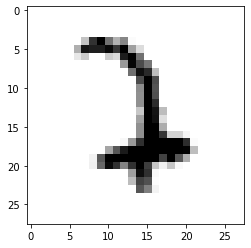



50 [ Predicted Value: 0, Actual Value: 8 ]


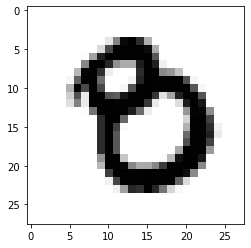



51 [ Predicted Value: 7, Actual Value: 2 ]


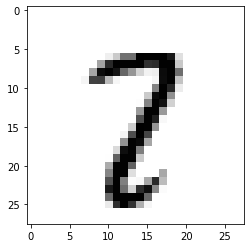



52 [ Predicted Value: 2, Actual Value: 6 ]


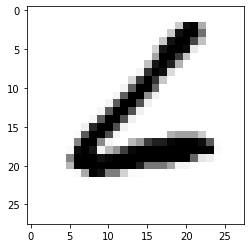



53 [ Predicted Value: 5, Actual Value: 9 ]


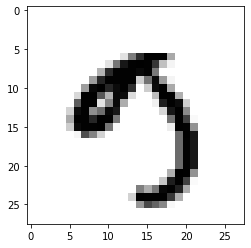



54 [ Predicted Value: 4, Actual Value: 9 ]


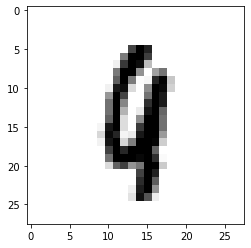



55 [ Predicted Value: 5, Actual Value: 6 ]


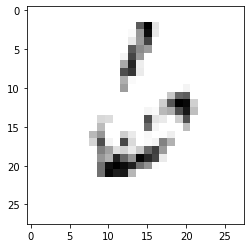



56 [ Predicted Value: 3, Actual Value: 5 ]


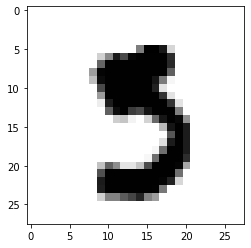



57 [ Predicted Value: 7, Actual Value: 9 ]


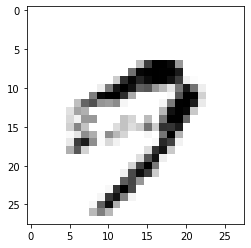



58 [ Predicted Value: 9, Actual Value: 4 ]


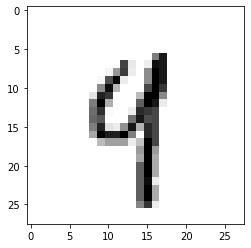



59 [ Predicted Value: 9, Actual Value: 8 ]


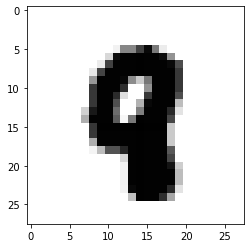



60 [ Predicted Value: 2, Actual Value: 3 ]


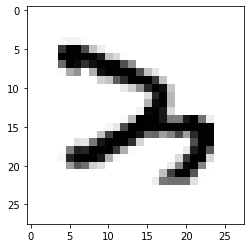



61 [ Predicted Value: 0, Actual Value: 8 ]


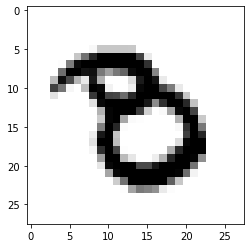



62 [ Predicted Value: 5, Actual Value: 6 ]


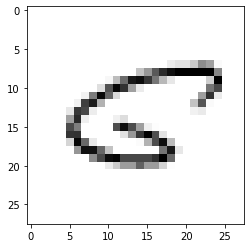



63 [ Predicted Value: 9, Actual Value: 4 ]


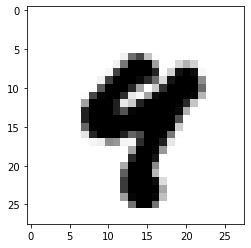



64 [ Predicted Value: 3, Actual Value: 5 ]


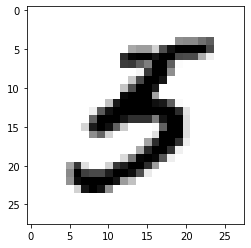



65 [ Predicted Value: 1, Actual Value: 4 ]


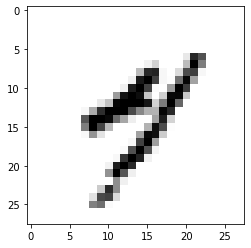



66 [ Predicted Value: 2, Actual Value: 1 ]


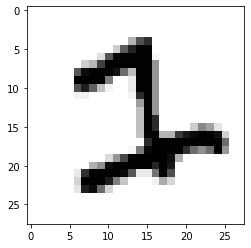



67 [ Predicted Value: 2, Actual Value: 7 ]


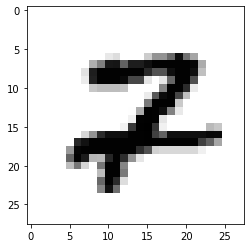



68 [ Predicted Value: 6, Actual Value: 5 ]


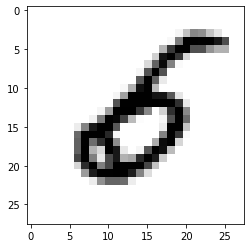

In [38]:
print('\n################With Both L1 and L2 Optimisations##################################\n')

train_losses_l1_l2, train_acc_l1_l2, test_losses_l1_l2, test_acc_l1_l2 = trainModel('_l1_l2', L1_Flag =True, L2_Flag = True, alpha = al )


##Validation Accuracy and Loss Plots


*****************Test Plots for lambda = 0.005*********************



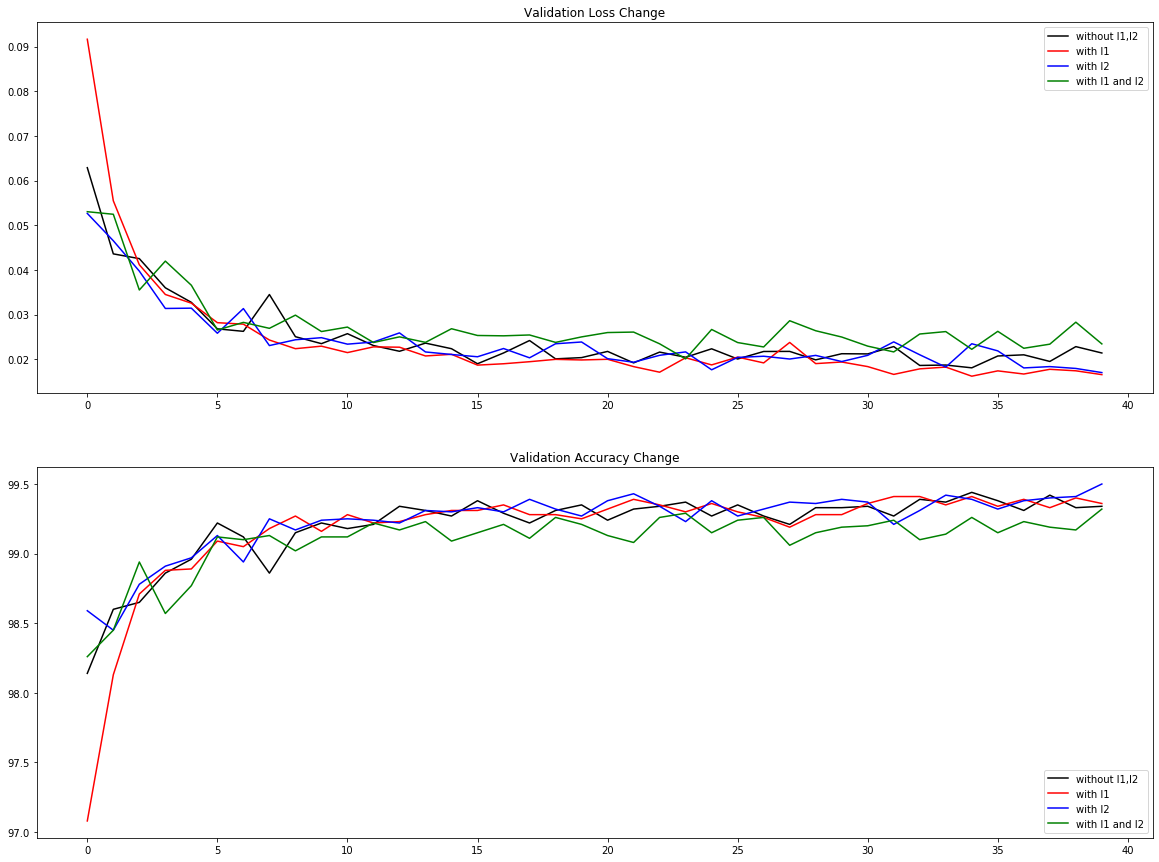

In [39]:

print('\n*****************Test Plots for lambda = {}*********************\n'.format(al))
plotGraphsTest(test_losses_0, test_losses_l1, test_losses_l2, test_losses_l1_l2, test_acc_0, test_acc_l1, test_acc_l2, test_acc_l1_l2)

##Train Accuracy and Loss Plot


*****************Train Plots for lambda = 0.005*********************



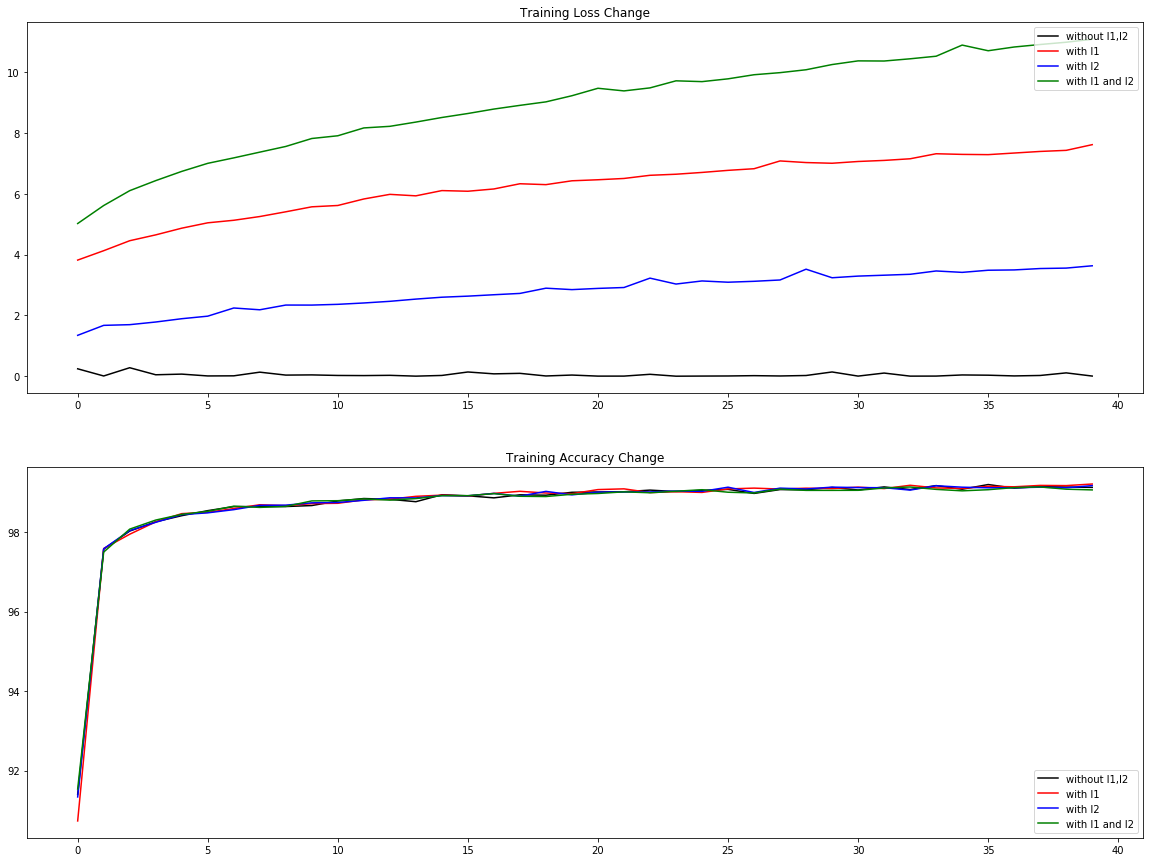

In [40]:
print('\n*****************Train Plots for lambda = {}*********************\n'.format(al))
plotGraphsTrain(train_losses_0, train_losses_l1, train_losses_l2, train_losses_l1_l2, train_acc_0, train_acc_l1, train_acc_l2, train_acc_l1_l2)

#Lambda = 0.0005

In [0]:
al = 0.0005

##With L1 Optimisation

  0%|          | 0/938 [00:00<?, ?it/s]


#########################With L1 Optimisation######################################

alpha =  0.0005
EPOCH _l1 0


Loss=0.4685869514942169 Batch_id=937 Accuracy=91.28: 100%|██████████| 938/938 [00:17<00:00, 52.47it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0658, Accuracy: 9799/10000 (97.99%)

EPOCH _l1 1


Loss=0.5989513397216797 Batch_id=937 Accuracy=97.40: 100%|██████████| 938/938 [00:17<00:00, 63.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0657, Accuracy: 9791/10000 (97.91%)

EPOCH _l1 2


Loss=0.5516769886016846 Batch_id=937 Accuracy=97.86: 100%|██████████| 938/938 [00:17<00:00, 62.33it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0327, Accuracy: 9891/10000 (98.91%)

EPOCH _l1 3


Loss=0.4860961437225342 Batch_id=937 Accuracy=98.28: 100%|██████████| 938/938 [00:17<00:00, 53.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9900/10000 (99.00%)

EPOCH _l1 4


Loss=0.7383554577827454 Batch_id=937 Accuracy=98.37: 100%|██████████| 938/938 [00:17<00:00, 54.91it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0313, Accuracy: 9893/10000 (98.93%)

EPOCH _l1 5


Loss=0.5439957976341248 Batch_id=937 Accuracy=98.49: 100%|██████████| 938/938 [00:17<00:00, 52.75it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9897/10000 (98.97%)

EPOCH _l1 6


Loss=0.5311564207077026 Batch_id=937 Accuracy=98.53: 100%|██████████| 938/938 [00:17<00:00, 52.62it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9913/10000 (99.13%)

EPOCH _l1 7


Loss=0.5444774627685547 Batch_id=937 Accuracy=98.67: 100%|██████████| 938/938 [00:16<00:00, 55.24it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9924/10000 (99.24%)

EPOCH _l1 8


Loss=0.5521290302276611 Batch_id=937 Accuracy=98.62: 100%|██████████| 938/938 [00:17<00:00, 52.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9917/10000 (99.17%)

EPOCH _l1 9


Loss=0.5617960691452026 Batch_id=937 Accuracy=98.75: 100%|██████████| 938/938 [00:18<00:00, 52.05it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9919/10000 (99.19%)

EPOCH _l1 10


Loss=0.5918079614639282 Batch_id=937 Accuracy=98.78: 100%|██████████| 938/938 [00:17<00:00, 54.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9925/10000 (99.25%)

EPOCH _l1 11


Loss=0.6789669990539551 Batch_id=937 Accuracy=98.81: 100%|██████████| 938/938 [00:17<00:00, 53.79it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9914/10000 (99.14%)

EPOCH _l1 12


Loss=0.590051531791687 Batch_id=937 Accuracy=98.79: 100%|██████████| 938/938 [00:18<00:00, 52.05it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9933/10000 (99.33%)

EPOCH _l1 13


Loss=0.6071162223815918 Batch_id=937 Accuracy=98.78: 100%|██████████| 938/938 [00:17<00:00, 54.74it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9920/10000 (99.20%)

EPOCH _l1 14


Loss=0.6103639602661133 Batch_id=937 Accuracy=98.84: 100%|██████████| 938/938 [00:17<00:00, 53.16it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9932/10000 (99.32%)

EPOCH _l1 15


Loss=0.6182991862297058 Batch_id=937 Accuracy=98.89: 100%|██████████| 938/938 [00:17<00:00, 52.69it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9940/10000 (99.40%)

EPOCH _l1 16


Loss=0.6198965311050415 Batch_id=937 Accuracy=98.82: 100%|██████████| 938/938 [00:17<00:00, 54.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9939/10000 (99.39%)

EPOCH _l1 17


Loss=0.6384466886520386 Batch_id=937 Accuracy=98.96: 100%|██████████| 938/938 [00:17<00:00, 53.30it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9941/10000 (99.41%)

EPOCH _l1 18


Loss=0.682640790939331 Batch_id=937 Accuracy=98.97: 100%|██████████| 938/938 [00:18<00:00, 51.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9939/10000 (99.39%)

EPOCH _l1 19


Loss=0.6425608396530151 Batch_id=937 Accuracy=98.99: 100%|██████████| 938/938 [00:17<00:00, 53.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9945/10000 (99.45%)

EPOCH _l1 20


Loss=0.6641332507133484 Batch_id=937 Accuracy=98.88: 100%|██████████| 938/938 [00:17<00:00, 53.78it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9945/10000 (99.45%)

EPOCH _l1 21


Loss=0.6604818105697632 Batch_id=937 Accuracy=98.93: 100%|██████████| 938/938 [00:17<00:00, 52.20it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9940/10000 (99.40%)

EPOCH _l1 22


Loss=0.6629825830459595 Batch_id=937 Accuracy=98.96: 100%|██████████| 938/938 [00:17<00:00, 53.27it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9942/10000 (99.42%)

EPOCH _l1 23


Loss=0.7356311678886414 Batch_id=937 Accuracy=98.92: 100%|██████████| 938/938 [00:17<00:00, 53.73it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9937/10000 (99.37%)

EPOCH _l1 24


Loss=0.6786394715309143 Batch_id=937 Accuracy=98.99: 100%|██████████| 938/938 [00:17<00:00, 53.91it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Accuracy: 9945/10000 (99.45%)

EPOCH _l1 25


Loss=0.7725474834442139 Batch_id=937 Accuracy=98.95: 100%|██████████| 938/938 [00:17<00:00, 53.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9941/10000 (99.41%)

EPOCH _l1 26


Loss=0.7104089856147766 Batch_id=937 Accuracy=98.98: 100%|██████████| 938/938 [00:17<00:00, 53.10it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9929/10000 (99.29%)

EPOCH _l1 27


Loss=0.704035758972168 Batch_id=937 Accuracy=99.04: 100%|██████████| 938/938 [00:17<00:00, 62.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0153, Accuracy: 9955/10000 (99.55%)

EPOCH _l1 28


Loss=0.8409022092819214 Batch_id=937 Accuracy=99.09: 100%|██████████| 938/938 [00:17<00:00, 53.40it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9932/10000 (99.32%)

EPOCH _l1 29


Loss=0.746461033821106 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:17<00:00, 54.28it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 9948/10000 (99.48%)

EPOCH _l1 30


Loss=0.7606267929077148 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [00:17<00:00, 53.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9947/10000 (99.47%)

EPOCH _l1 31


Loss=0.7213055491447449 Batch_id=937 Accuracy=99.09: 100%|██████████| 938/938 [00:18<00:00, 52.06it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9931/10000 (99.31%)

EPOCH _l1 32


Loss=0.7214325070381165 Batch_id=937 Accuracy=99.04: 100%|██████████| 938/938 [00:17<00:00, 62.47it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9939/10000 (99.39%)

EPOCH _l1 33


Loss=0.7289426326751709 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [00:17<00:00, 53.58it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9942/10000 (99.42%)

EPOCH _l1 34


Loss=0.7365955114364624 Batch_id=937 Accuracy=99.09: 100%|██████████| 938/938 [00:17<00:00, 52.49it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9940/10000 (99.40%)

EPOCH _l1 35


Loss=0.7344251871109009 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [00:17<00:00, 54.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9940/10000 (99.40%)

EPOCH _l1 36


Loss=0.7675714492797852 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:17<00:00, 53.17it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9935/10000 (99.35%)

EPOCH _l1 37


Loss=0.743145227432251 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:18<00:00, 51.51it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0159, Accuracy: 9944/10000 (99.44%)

EPOCH _l1 38


Loss=0.7933238744735718 Batch_id=937 Accuracy=99.09: 100%|██████████| 938/938 [00:17<00:00, 54.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9922/10000 (99.22%)

EPOCH _l1 39


Loss=0.8948029279708862 Batch_id=937 Accuracy=99.10: 100%|██████████| 938/938 [00:17<00:00, 56.14it/s]



Test set: Average loss: 0.0177, Accuracy: 9942/10000 (99.42%)


@@@@@@@@@@@@@MISCLASSIFIED IMAGES@@@@@@@@@@@@@@@@@@@@@@@@@@@



1 [ Predicted Value: 4, Actual Value: 9 ]


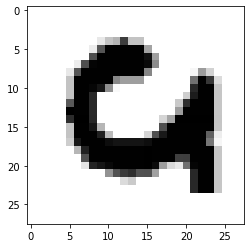



2 [ Predicted Value: 9, Actual Value: 8 ]


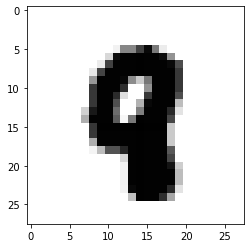



3 [ Predicted Value: 1, Actual Value: 7 ]


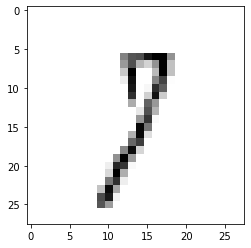



4 [ Predicted Value: 3, Actual Value: 5 ]


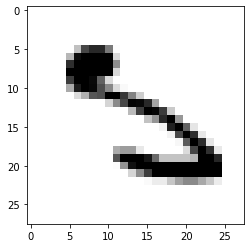



5 [ Predicted Value: 3, Actual Value: 2 ]


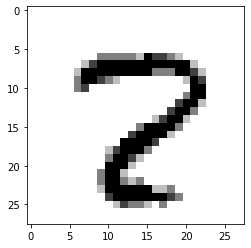



6 [ Predicted Value: 7, Actual Value: 2 ]


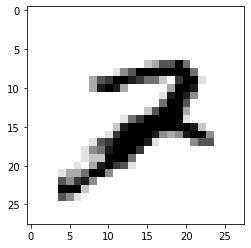



7 [ Predicted Value: 4, Actual Value: 9 ]


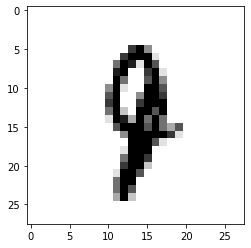



8 [ Predicted Value: 1, Actual Value: 7 ]


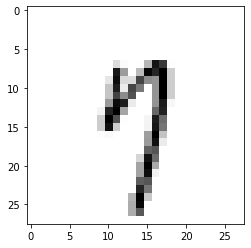



9 [ Predicted Value: 6, Actual Value: 1 ]


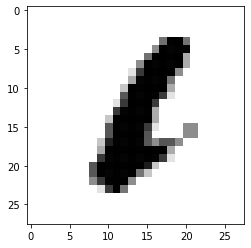



10 [ Predicted Value: 4, Actual Value: 9 ]


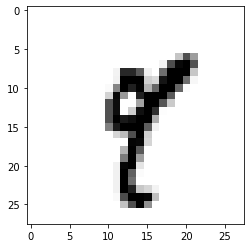



11 [ Predicted Value: 9, Actual Value: 4 ]


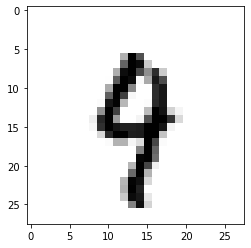



12 [ Predicted Value: 3, Actual Value: 8 ]


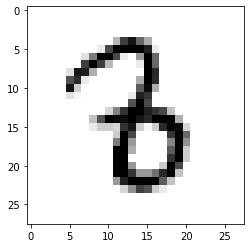



13 [ Predicted Value: 9, Actual Value: 4 ]


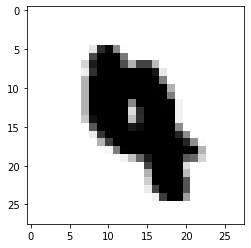



14 [ Predicted Value: 6, Actual Value: 5 ]


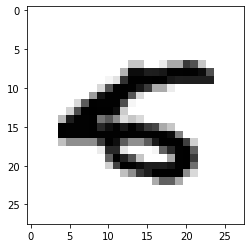



15 [ Predicted Value: 3, Actual Value: 7 ]


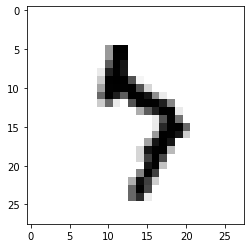



16 [ Predicted Value: 9, Actual Value: 5 ]


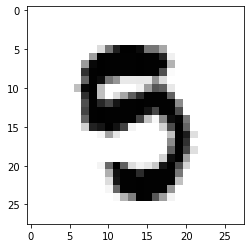



17 [ Predicted Value: 3, Actual Value: 5 ]


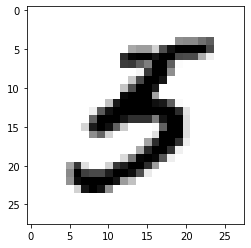



18 [ Predicted Value: 1, Actual Value: 7 ]


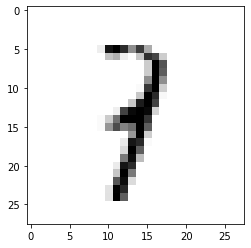



19 [ Predicted Value: 7, Actual Value: 0 ]


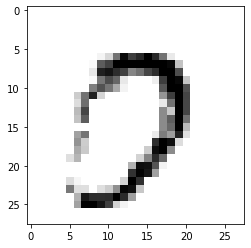



20 [ Predicted Value: 6, Actual Value: 5 ]


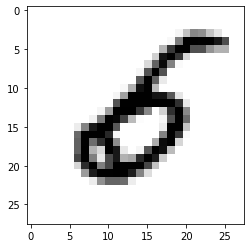



21 [ Predicted Value: 9, Actual Value: 4 ]


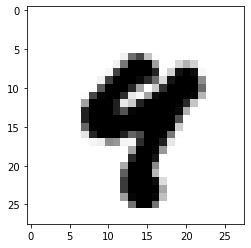



22 [ Predicted Value: 1, Actual Value: 6 ]


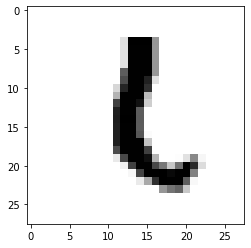



23 [ Predicted Value: 3, Actual Value: 5 ]


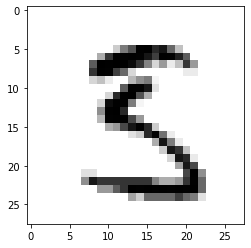



24 [ Predicted Value: 9, Actual Value: 8 ]


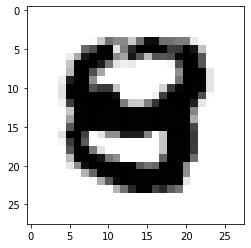



25 [ Predicted Value: 5, Actual Value: 3 ]


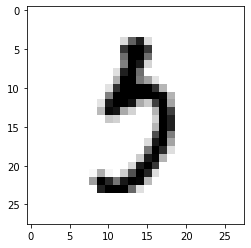



26 [ Predicted Value: 1, Actual Value: 6 ]


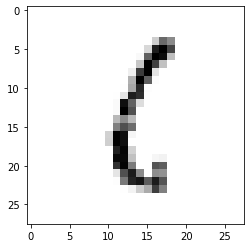



27 [ Predicted Value: 2, Actual Value: 7 ]


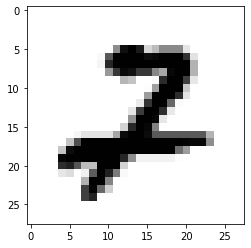



28 [ Predicted Value: 1, Actual Value: 7 ]


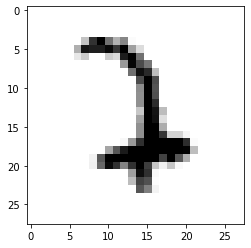



29 [ Predicted Value: 1, Actual Value: 3 ]


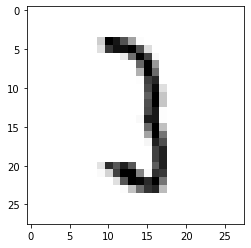



30 [ Predicted Value: 1, Actual Value: 7 ]


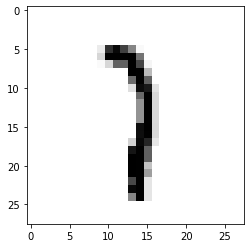



31 [ Predicted Value: 7, Actual Value: 2 ]


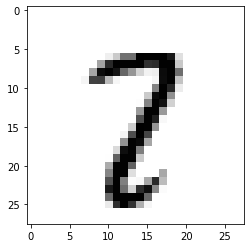



32 [ Predicted Value: 9, Actual Value: 5 ]


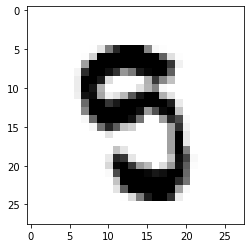



33 [ Predicted Value: 9, Actual Value: 3 ]


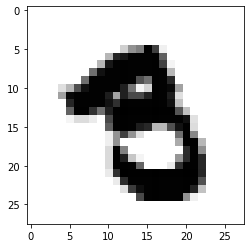



34 [ Predicted Value: 2, Actual Value: 3 ]


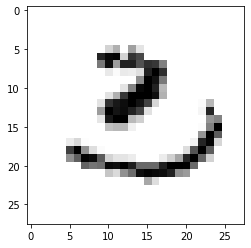



35 [ Predicted Value: 4, Actual Value: 6 ]


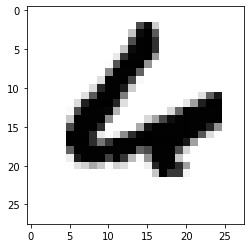



36 [ Predicted Value: 1, Actual Value: 2 ]


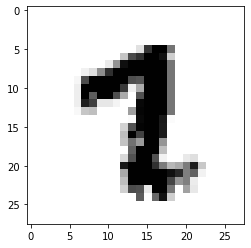



37 [ Predicted Value: 1, Actual Value: 7 ]


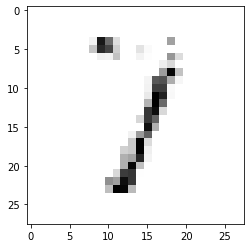



38 [ Predicted Value: 4, Actual Value: 9 ]


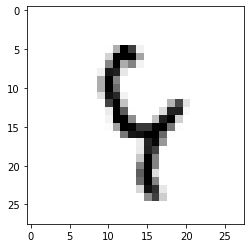



39 [ Predicted Value: 2, Actual Value: 8 ]


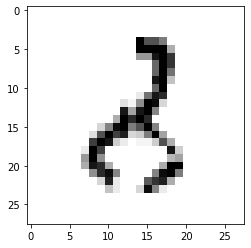



40 [ Predicted Value: 0, Actual Value: 6 ]


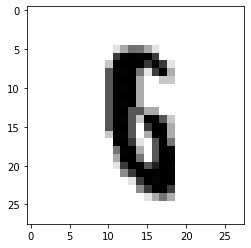



41 [ Predicted Value: 0, Actual Value: 5 ]


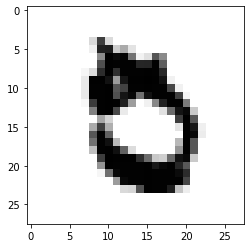



42 [ Predicted Value: 0, Actual Value: 6 ]


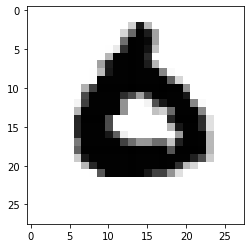



43 [ Predicted Value: 9, Actual Value: 8 ]


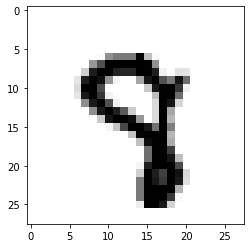



44 [ Predicted Value: 0, Actual Value: 8 ]


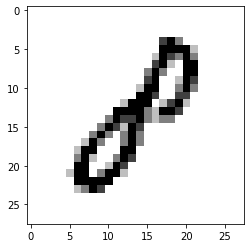



45 [ Predicted Value: 5, Actual Value: 6 ]


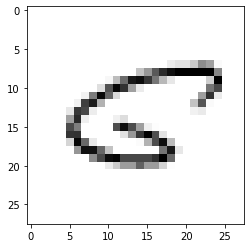



46 [ Predicted Value: 1, Actual Value: 6 ]


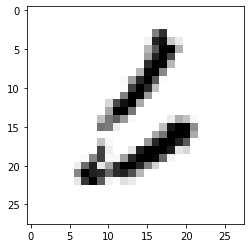



47 [ Predicted Value: 9, Actual Value: 4 ]


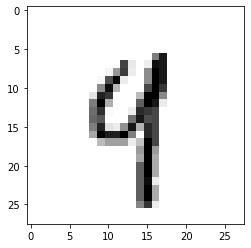



48 [ Predicted Value: 7, Actual Value: 2 ]


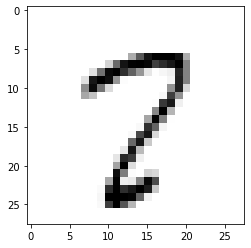



49 [ Predicted Value: 5, Actual Value: 8 ]


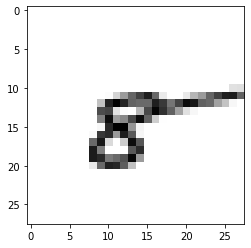



50 [ Predicted Value: 7, Actual Value: 2 ]


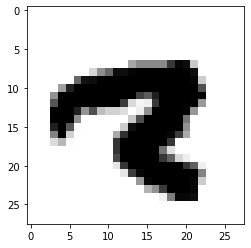



51 [ Predicted Value: 3, Actual Value: 5 ]


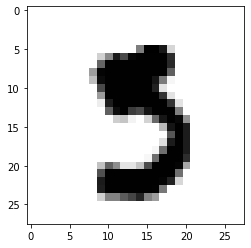



52 [ Predicted Value: 2, Actual Value: 1 ]


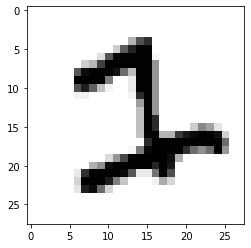



53 [ Predicted Value: 1, Actual Value: 7 ]


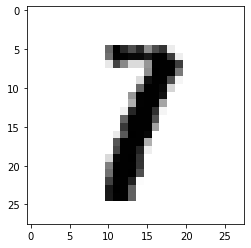



54 [ Predicted Value: 7, Actual Value: 9 ]


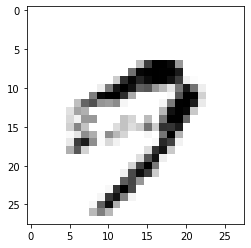



55 [ Predicted Value: 7, Actual Value: 2 ]


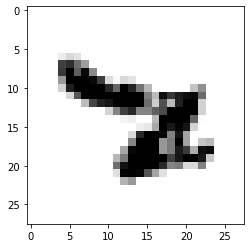



56 [ Predicted Value: 1, Actual Value: 7 ]


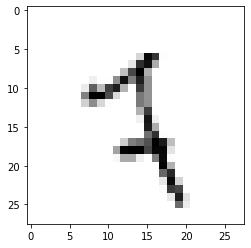



57 [ Predicted Value: 1, Actual Value: 8 ]


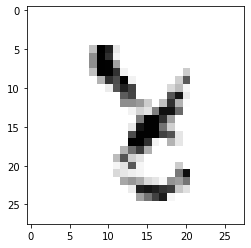



58 [ Predicted Value: 4, Actual Value: 9 ]


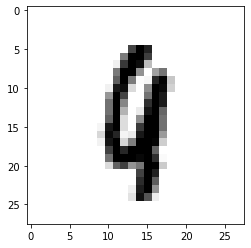

In [16]:
print('\n#########################With L1 Optimisation######################################\n')

train_losses_l1_b, train_acc_l1_b, test_losses_l1_b, test_acc_l1_b = trainModel('_l1', L1_Flag =True, L2_Flag = False, alpha = al )

##With L2 Optimisation

  0%|          | 0/938 [00:00<?, ?it/s]


#########################With L2 Optimisation######################################

alpha =  0.0005
EPOCH _l2 0


Loss=0.1915188580751419 Batch_id=937 Accuracy=91.92: 100%|██████████| 938/938 [00:17<00:00, 53.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0636, Accuracy: 9812/10000 (98.12%)

EPOCH _l2 1


Loss=0.16104820370674133 Batch_id=937 Accuracy=97.58: 100%|██████████| 938/938 [00:18<00:00, 50.77it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0399, Accuracy: 9876/10000 (98.76%)

EPOCH _l2 2


Loss=0.22385689616203308 Batch_id=937 Accuracy=98.01: 100%|██████████| 938/938 [00:17<00:00, 52.97it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0383, Accuracy: 9884/10000 (98.84%)

EPOCH _l2 3


Loss=0.2180146872997284 Batch_id=937 Accuracy=98.21: 100%|██████████| 938/938 [00:17<00:00, 52.39it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0363, Accuracy: 9884/10000 (98.84%)

EPOCH _l2 4


Loss=0.22580236196517944 Batch_id=937 Accuracy=98.37: 100%|██████████| 938/938 [00:17<00:00, 52.91it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0367, Accuracy: 9889/10000 (98.89%)

EPOCH _l2 5


Loss=0.23349858820438385 Batch_id=937 Accuracy=98.47: 100%|██████████| 938/938 [00:17<00:00, 53.34it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9901/10000 (99.01%)

EPOCH _l2 6


Loss=0.21452230215072632 Batch_id=937 Accuracy=98.56: 100%|██████████| 938/938 [00:19<00:00, 47.89it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0322, Accuracy: 9905/10000 (99.05%)

EPOCH _l2 7


Loss=0.24926133453845978 Batch_id=937 Accuracy=98.62: 100%|██████████| 938/938 [00:18<00:00, 50.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9908/10000 (99.08%)

EPOCH _l2 8


Loss=0.3777862787246704 Batch_id=937 Accuracy=98.67: 100%|██████████| 938/938 [00:18<00:00, 52.06it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9923/10000 (99.23%)

EPOCH _l2 9


Loss=0.38947156071662903 Batch_id=937 Accuracy=98.58: 100%|██████████| 938/938 [00:18<00:00, 51.73it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9916/10000 (99.16%)

EPOCH _l2 10


Loss=0.25719791650772095 Batch_id=937 Accuracy=98.79: 100%|██████████| 938/938 [00:17<00:00, 52.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9925/10000 (99.25%)

EPOCH _l2 11


Loss=0.24913960695266724 Batch_id=937 Accuracy=98.71: 100%|██████████| 938/938 [00:17<00:00, 52.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9925/10000 (99.25%)

EPOCH _l2 12


Loss=0.28781160712242126 Batch_id=937 Accuracy=98.75: 100%|██████████| 938/938 [00:18<00:00, 51.91it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9917/10000 (99.17%)

EPOCH _l2 13


Loss=0.2557896375656128 Batch_id=937 Accuracy=98.78: 100%|██████████| 938/938 [00:17<00:00, 52.27it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9916/10000 (99.16%)

EPOCH _l2 14


Loss=0.26411759853363037 Batch_id=937 Accuracy=98.85: 100%|██████████| 938/938 [00:17<00:00, 52.82it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9933/10000 (99.33%)

EPOCH _l2 15


Loss=0.2949787378311157 Batch_id=937 Accuracy=98.89: 100%|██████████| 938/938 [00:18<00:00, 51.36it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9921/10000 (99.21%)

EPOCH _l2 16


Loss=0.27343809604644775 Batch_id=937 Accuracy=98.91: 100%|██████████| 938/938 [00:18<00:00, 51.81it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9920/10000 (99.20%)

EPOCH _l2 17


Loss=0.4622240662574768 Batch_id=937 Accuracy=98.83: 100%|██████████| 938/938 [00:17<00:00, 53.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9936/10000 (99.36%)

EPOCH _l2 18


Loss=0.3602222502231598 Batch_id=937 Accuracy=98.94: 100%|██████████| 938/938 [00:18<00:00, 51.75it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9927/10000 (99.27%)

EPOCH _l2 19


Loss=0.2844448983669281 Batch_id=937 Accuracy=98.98: 100%|██████████| 938/938 [00:17<00:00, 52.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9927/10000 (99.27%)

EPOCH _l2 20


Loss=0.287866473197937 Batch_id=937 Accuracy=98.95: 100%|██████████| 938/938 [00:17<00:00, 53.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9929/10000 (99.29%)

EPOCH _l2 21


Loss=0.29266172647476196 Batch_id=937 Accuracy=98.97: 100%|██████████| 938/938 [00:18<00:00, 51.77it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9931/10000 (99.31%)

EPOCH _l2 22


Loss=0.325779527425766 Batch_id=937 Accuracy=98.96: 100%|██████████| 938/938 [00:17<00:00, 53.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9937/10000 (99.37%)

EPOCH _l2 23


Loss=0.31332188844680786 Batch_id=937 Accuracy=99.01: 100%|██████████| 938/938 [00:17<00:00, 52.23it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9932/10000 (99.32%)

EPOCH _l2 24


Loss=0.33449897170066833 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:18<00:00, 51.75it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9923/10000 (99.23%)

EPOCH _l2 25


Loss=0.31783223152160645 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:17<00:00, 53.95it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9931/10000 (99.31%)

EPOCH _l2 26


Loss=0.40747523307800293 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:18<00:00, 51.66it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9922/10000 (99.22%)

EPOCH _l2 27


Loss=0.45069923996925354 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [00:18<00:00, 51.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9938/10000 (99.38%)

EPOCH _l2 28


Loss=0.3253524899482727 Batch_id=937 Accuracy=99.03: 100%|██████████| 938/938 [00:17<00:00, 53.81it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9929/10000 (99.29%)

EPOCH _l2 29


Loss=0.3274352550506592 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [00:18<00:00, 51.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9936/10000 (99.36%)

EPOCH _l2 30


Loss=0.33913570642471313 Batch_id=937 Accuracy=99.04: 100%|██████████| 938/938 [00:18<00:00, 51.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9931/10000 (99.31%)

EPOCH _l2 31


Loss=0.367603063583374 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [00:17<00:00, 53.62it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9943/10000 (99.43%)

EPOCH _l2 32


Loss=0.3608863353729248 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [00:17<00:00, 52.57it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9943/10000 (99.43%)

EPOCH _l2 33


Loss=0.49469447135925293 Batch_id=937 Accuracy=99.07: 100%|██████████| 938/938 [00:17<00:00, 52.65it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9942/10000 (99.42%)

EPOCH _l2 34


Loss=0.3665568232536316 Batch_id=937 Accuracy=99.07: 100%|██████████| 938/938 [00:17<00:00, 54.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9939/10000 (99.39%)

EPOCH _l2 35


Loss=0.4927792549133301 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [00:17<00:00, 52.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9944/10000 (99.44%)

EPOCH _l2 36


Loss=0.45387521386146545 Batch_id=937 Accuracy=99.09: 100%|██████████| 938/938 [00:17<00:00, 52.13it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9938/10000 (99.38%)

EPOCH _l2 37


Loss=0.3852173686027527 Batch_id=937 Accuracy=99.10: 100%|██████████| 938/938 [00:17<00:00, 53.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9938/10000 (99.38%)

EPOCH _l2 38


Loss=0.3561995327472687 Batch_id=937 Accuracy=99.13: 100%|██████████| 938/938 [00:17<00:00, 53.13it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9943/10000 (99.43%)

EPOCH _l2 39


Loss=0.3820764422416687 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [00:19<00:00, 48.54it/s]



Test set: Average loss: 0.0215, Accuracy: 9939/10000 (99.39%)


@@@@@@@@@@@@@MISCLASSIFIED IMAGES@@@@@@@@@@@@@@@@@@@@@@@@@@@



1 [ Predicted Value: 8, Actual Value: 9 ]


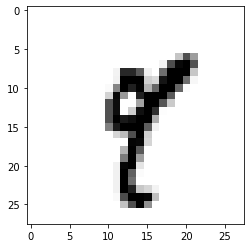



2 [ Predicted Value: 4, Actual Value: 6 ]


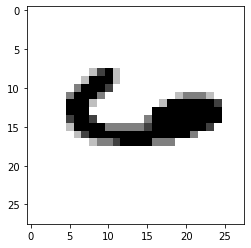



3 [ Predicted Value: 3, Actual Value: 5 ]


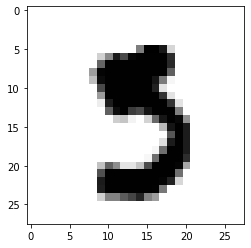



4 [ Predicted Value: 0, Actual Value: 2 ]


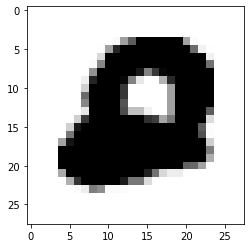



5 [ Predicted Value: 7, Actual Value: 9 ]


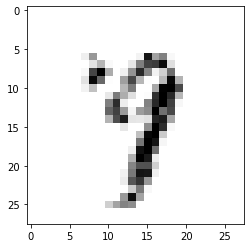



6 [ Predicted Value: 0, Actual Value: 6 ]


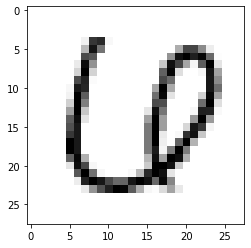



7 [ Predicted Value: 7, Actual Value: 2 ]


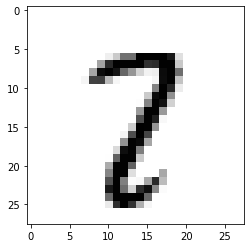



8 [ Predicted Value: 1, Actual Value: 7 ]


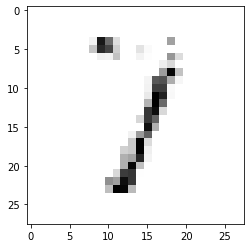



9 [ Predicted Value: 5, Actual Value: 6 ]


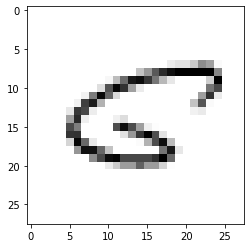



10 [ Predicted Value: 7, Actual Value: 2 ]


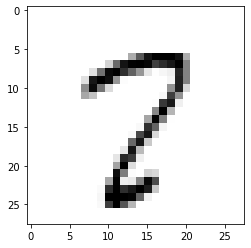



11 [ Predicted Value: 4, Actual Value: 9 ]


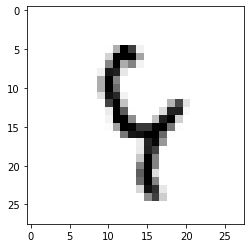



12 [ Predicted Value: 3, Actual Value: 7 ]


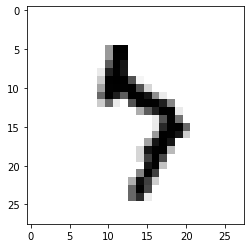



13 [ Predicted Value: 1, Actual Value: 6 ]


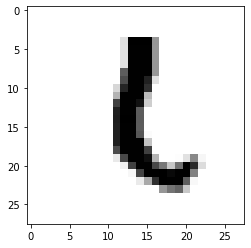



14 [ Predicted Value: 2, Actual Value: 6 ]


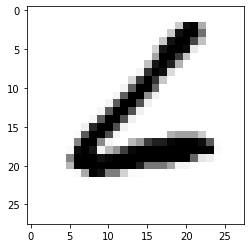



15 [ Predicted Value: 0, Actual Value: 8 ]


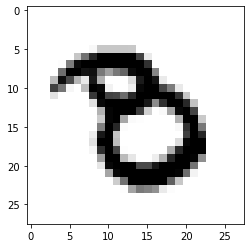



16 [ Predicted Value: 1, Actual Value: 7 ]


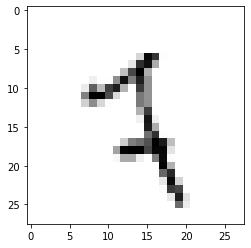



17 [ Predicted Value: 5, Actual Value: 6 ]


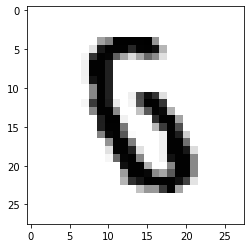



18 [ Predicted Value: 1, Actual Value: 6 ]


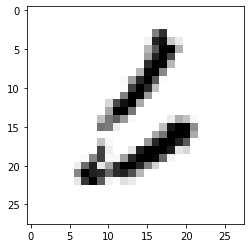



19 [ Predicted Value: 0, Actual Value: 6 ]


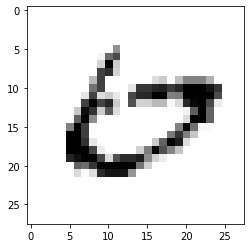



20 [ Predicted Value: 1, Actual Value: 6 ]


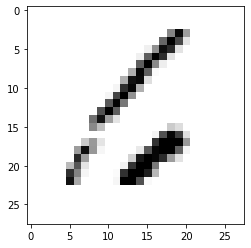



21 [ Predicted Value: 1, Actual Value: 7 ]


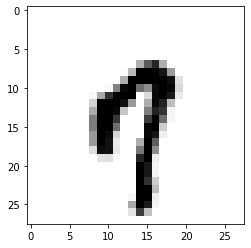



22 [ Predicted Value: 5, Actual Value: 3 ]


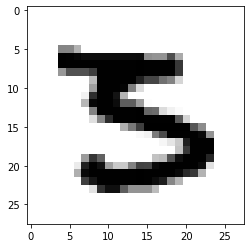



23 [ Predicted Value: 9, Actual Value: 4 ]


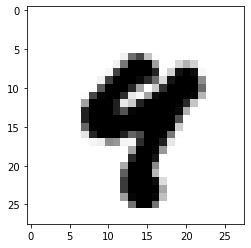



24 [ Predicted Value: 8, Actual Value: 9 ]


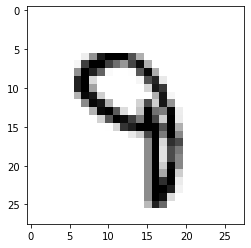



25 [ Predicted Value: 7, Actual Value: 2 ]


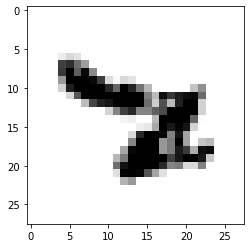



26 [ Predicted Value: 5, Actual Value: 3 ]


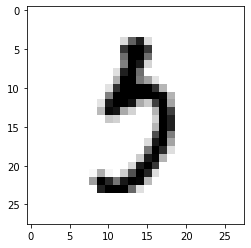



27 [ Predicted Value: 6, Actual Value: 0 ]


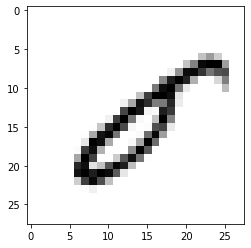



28 [ Predicted Value: 7, Actual Value: 8 ]


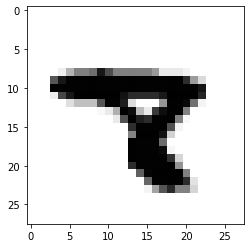



29 [ Predicted Value: 0, Actual Value: 6 ]


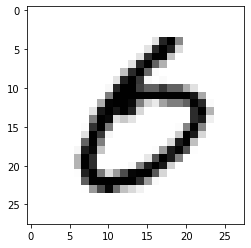



30 [ Predicted Value: 8, Actual Value: 6 ]


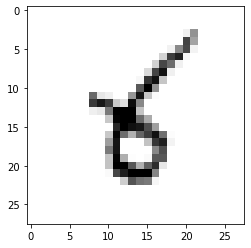



31 [ Predicted Value: 9, Actual Value: 4 ]


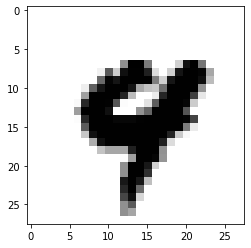



32 [ Predicted Value: 1, Actual Value: 2 ]


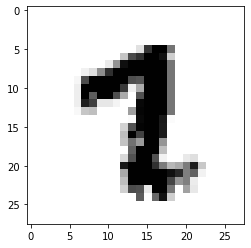



33 [ Predicted Value: 4, Actual Value: 9 ]


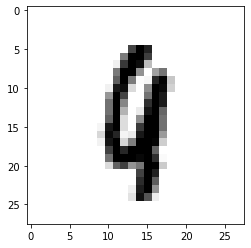



34 [ Predicted Value: 5, Actual Value: 8 ]


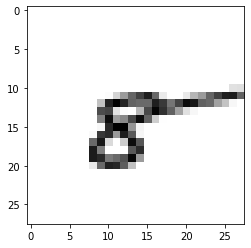



35 [ Predicted Value: 0, Actual Value: 6 ]


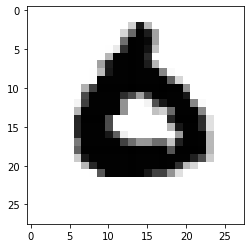



36 [ Predicted Value: 9, Actual Value: 4 ]


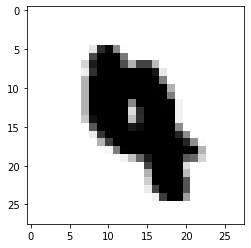



37 [ Predicted Value: 1, Actual Value: 7 ]


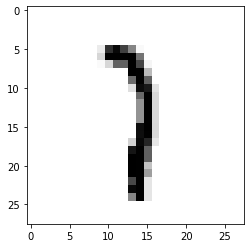



38 [ Predicted Value: 6, Actual Value: 1 ]


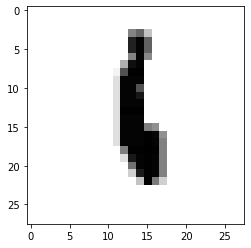



39 [ Predicted Value: 1, Actual Value: 8 ]


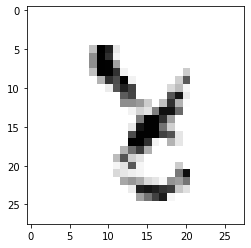



40 [ Predicted Value: 6, Actual Value: 5 ]


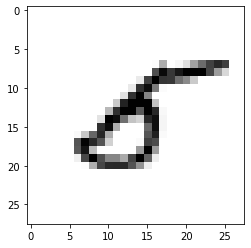



41 [ Predicted Value: 7, Actual Value: 2 ]


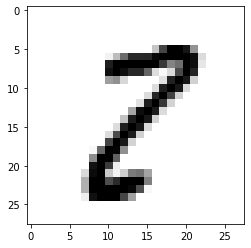



42 [ Predicted Value: 2, Actual Value: 6 ]


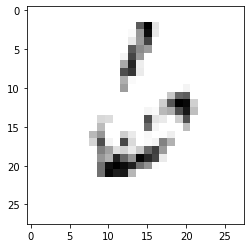



43 [ Predicted Value: 3, Actual Value: 2 ]


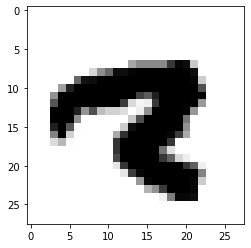



44 [ Predicted Value: 1, Actual Value: 3 ]


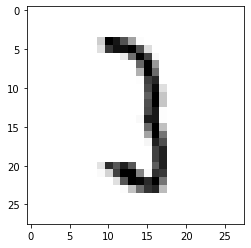



45 [ Predicted Value: 9, Actual Value: 8 ]


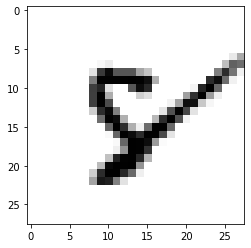



46 [ Predicted Value: 0, Actual Value: 8 ]


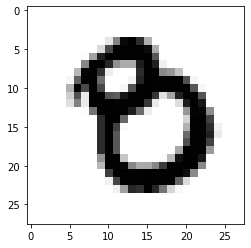



47 [ Predicted Value: 4, Actual Value: 6 ]


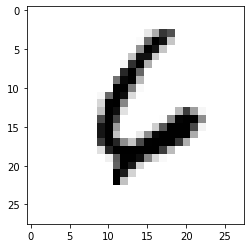



48 [ Predicted Value: 7, Actual Value: 4 ]


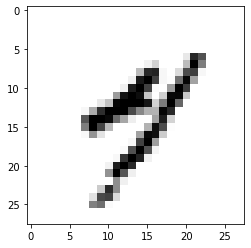



49 [ Predicted Value: 3, Actual Value: 8 ]


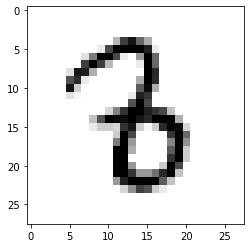



50 [ Predicted Value: 3, Actual Value: 5 ]


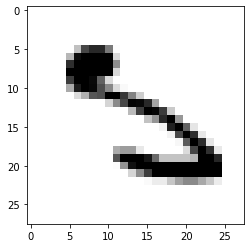



51 [ Predicted Value: 3, Actual Value: 5 ]


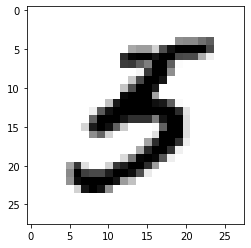



52 [ Predicted Value: 7, Actual Value: 9 ]


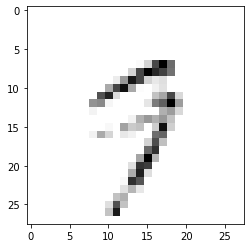



53 [ Predicted Value: 6, Actual Value: 5 ]


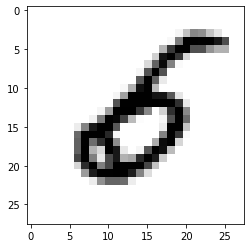



54 [ Predicted Value: 6, Actual Value: 0 ]


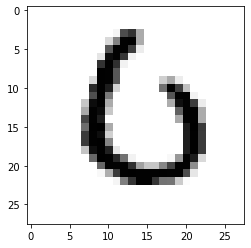



55 [ Predicted Value: 0, Actual Value: 5 ]


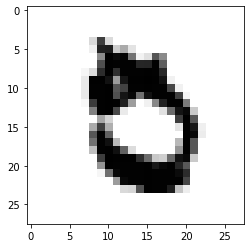



56 [ Predicted Value: 4, Actual Value: 6 ]


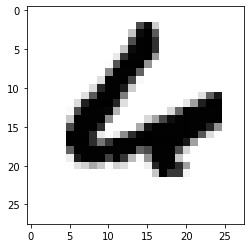



57 [ Predicted Value: 9, Actual Value: 8 ]


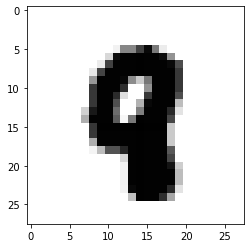



58 [ Predicted Value: 2, Actual Value: 8 ]


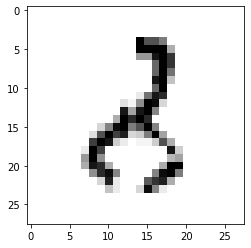



59 [ Predicted Value: 8, Actual Value: 3 ]


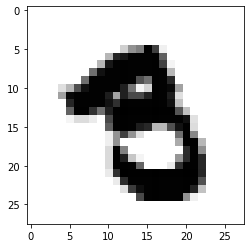



60 [ Predicted Value: 0, Actual Value: 2 ]


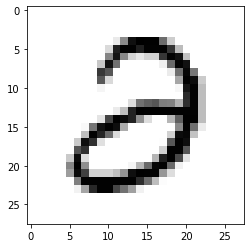



61 [ Predicted Value: 3, Actual Value: 5 ]


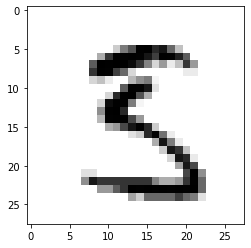

In [17]:
print('\n#########################With L2 Optimisation######################################\n')

train_losses_l2_b, train_acc_l2_b, test_losses_l2_b, test_acc_l2_b = trainModel('_l2', L1_Flag =False, L2_Flag = True, alpha = al )

##With L1 and L2 Optimisations

  0%|          | 0/938 [00:00<?, ?it/s]


################With Both L1 and L2 Optimisations##################################

alpha =  0.0005
EPOCH _l1_l2 0


Loss=0.5079813003540039 Batch_id=937 Accuracy=90.92: 100%|██████████| 938/938 [00:20<00:00, 45.47it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0674, Accuracy: 9786/10000 (97.86%)

EPOCH _l1_l2 1


Loss=0.7379472255706787 Batch_id=937 Accuracy=97.53: 100%|██████████| 938/938 [00:20<00:00, 45.04it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0473, Accuracy: 9847/10000 (98.47%)

EPOCH _l1_l2 2


Loss=0.6752883791923523 Batch_id=937 Accuracy=97.91: 100%|██████████| 938/938 [00:21<00:00, 43.77it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0419, Accuracy: 9869/10000 (98.69%)

EPOCH _l1_l2 3


Loss=0.7175830602645874 Batch_id=937 Accuracy=98.14: 100%|██████████| 938/938 [00:20<00:00, 45.41it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0383, Accuracy: 9875/10000 (98.75%)

EPOCH _l1_l2 4


Loss=0.6762315034866333 Batch_id=937 Accuracy=98.30: 100%|██████████| 938/938 [00:21<00:00, 44.21it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0354, Accuracy: 9889/10000 (98.89%)

EPOCH _l1_l2 5


Loss=0.8282214403152466 Batch_id=937 Accuracy=98.44: 100%|██████████| 938/938 [00:19<00:00, 47.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9901/10000 (99.01%)

EPOCH _l1_l2 6


Loss=0.7460274696350098 Batch_id=937 Accuracy=98.43: 100%|██████████| 938/938 [00:20<00:00, 44.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9908/10000 (99.08%)

EPOCH _l1_l2 7


Loss=0.7755820751190186 Batch_id=937 Accuracy=98.53: 100%|██████████| 938/938 [00:19<00:00, 60.99it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9919/10000 (99.19%)

EPOCH _l1_l2 8


Loss=0.7725631594657898 Batch_id=937 Accuracy=98.62: 100%|██████████| 938/938 [00:18<00:00, 51.20it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9921/10000 (99.21%)

EPOCH _l1_l2 9


Loss=0.7848402261734009 Batch_id=937 Accuracy=98.61: 100%|██████████| 938/938 [00:18<00:00, 51.68it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9902/10000 (99.02%)

EPOCH _l1_l2 10


Loss=0.8423486351966858 Batch_id=937 Accuracy=98.66: 100%|██████████| 938/938 [00:18<00:00, 49.68it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9913/10000 (99.13%)

EPOCH _l1_l2 11


Loss=0.8868880271911621 Batch_id=937 Accuracy=98.72: 100%|██████████| 938/938 [00:18<00:00, 51.63it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Accuracy: 9908/10000 (99.08%)

EPOCH _l1_l2 12


Loss=0.8827526569366455 Batch_id=937 Accuracy=98.73: 100%|██████████| 938/938 [00:17<00:00, 52.23it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9905/10000 (99.05%)

EPOCH _l1_l2 13


Loss=0.9360623955726624 Batch_id=937 Accuracy=98.76: 100%|██████████| 938/938 [00:18<00:00, 50.68it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9927/10000 (99.27%)

EPOCH _l1_l2 14


Loss=0.8595659732818604 Batch_id=937 Accuracy=98.81: 100%|██████████| 938/938 [00:18<00:00, 51.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9911/10000 (99.11%)

EPOCH _l1_l2 15


Loss=0.8777785301208496 Batch_id=937 Accuracy=98.78: 100%|██████████| 938/938 [00:17<00:00, 52.28it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9898/10000 (98.98%)

EPOCH _l1_l2 16


Loss=0.8895434141159058 Batch_id=937 Accuracy=98.94: 100%|██████████| 938/938 [00:18<00:00, 50.63it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9915/10000 (99.15%)

EPOCH _l1_l2 17


Loss=0.8970578908920288 Batch_id=937 Accuracy=98.83: 100%|██████████| 938/938 [00:18<00:00, 51.60it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9931/10000 (99.31%)

EPOCH _l1_l2 18


Loss=0.9162999391555786 Batch_id=937 Accuracy=98.84: 100%|██████████| 938/938 [00:18<00:00, 50.51it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9928/10000 (99.28%)

EPOCH _l1_l2 19


Loss=0.9274278879165649 Batch_id=937 Accuracy=98.90: 100%|██████████| 938/938 [00:18<00:00, 62.89it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9921/10000 (99.21%)

EPOCH _l1_l2 20


Loss=0.9839231371879578 Batch_id=937 Accuracy=98.92: 100%|██████████| 938/938 [00:17<00:00, 52.14it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9930/10000 (99.30%)

EPOCH _l1_l2 21


Loss=1.0169763565063477 Batch_id=937 Accuracy=98.94: 100%|██████████| 938/938 [00:18<00:00, 51.64it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9910/10000 (99.10%)

EPOCH _l1_l2 22


Loss=0.9961010813713074 Batch_id=937 Accuracy=98.96: 100%|██████████| 938/938 [00:18<00:00, 50.47it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9943/10000 (99.43%)

EPOCH _l1_l2 23


Loss=1.0532076358795166 Batch_id=937 Accuracy=98.94: 100%|██████████| 938/938 [00:18<00:00, 51.63it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9930/10000 (99.30%)

EPOCH _l1_l2 24


Loss=1.008856177330017 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [00:18<00:00, 52.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9923/10000 (99.23%)

EPOCH _l1_l2 25


Loss=1.0151840448379517 Batch_id=937 Accuracy=98.90: 100%|██████████| 938/938 [00:18<00:00, 50.77it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9921/10000 (99.21%)

EPOCH _l1_l2 26


Loss=1.083438515663147 Batch_id=937 Accuracy=99.01: 100%|██████████| 938/938 [00:18<00:00, 51.26it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9921/10000 (99.21%)

EPOCH _l1_l2 27


Loss=1.0062675476074219 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:18<00:00, 51.93it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9937/10000 (99.37%)

EPOCH _l1_l2 28


Loss=1.0291805267333984 Batch_id=937 Accuracy=98.99: 100%|██████████| 938/938 [00:18<00:00, 50.58it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9923/10000 (99.23%)

EPOCH _l1_l2 29


Loss=1.0479861497879028 Batch_id=937 Accuracy=99.01: 100%|██████████| 938/938 [00:18<00:00, 51.08it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9923/10000 (99.23%)

EPOCH _l1_l2 30


Loss=1.0339374542236328 Batch_id=937 Accuracy=99.03: 100%|██████████| 938/938 [00:18<00:00, 51.27it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9926/10000 (99.26%)

EPOCH _l1_l2 31


Loss=1.1333812475204468 Batch_id=937 Accuracy=99.03: 100%|██████████| 938/938 [00:18<00:00, 50.69it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9925/10000 (99.25%)

EPOCH _l1_l2 32


Loss=1.1752166748046875 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [00:18<00:00, 51.74it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9930/10000 (99.30%)

EPOCH _l1_l2 33


Loss=1.0972398519515991 Batch_id=937 Accuracy=99.01: 100%|██████████| 938/938 [00:18<00:00, 51.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9935/10000 (99.35%)

EPOCH _l1_l2 34


Loss=1.3549143075942993 Batch_id=937 Accuracy=99.13: 100%|██████████| 938/938 [00:19<00:00, 48.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9924/10000 (99.24%)

EPOCH _l1_l2 35


Loss=1.360029697418213 Batch_id=937 Accuracy=99.03: 100%|██████████| 938/938 [00:18<00:00, 60.69it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9929/10000 (99.29%)

EPOCH _l1_l2 36


Loss=1.097165584564209 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [00:18<00:00, 51.57it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9927/10000 (99.27%)

EPOCH _l1_l2 37


Loss=1.1306450366973877 Batch_id=937 Accuracy=99.07: 100%|██████████| 938/938 [00:18<00:00, 50.89it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9921/10000 (99.21%)

EPOCH _l1_l2 38


Loss=1.102837085723877 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:18<00:00, 51.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9923/10000 (99.23%)

EPOCH _l1_l2 39


Loss=1.2839221954345703 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:17<00:00, 52.29it/s]



Test set: Average loss: 0.0241, Accuracy: 9918/10000 (99.18%)


@@@@@@@@@@@@@MISCLASSIFIED IMAGES@@@@@@@@@@@@@@@@@@@@@@@@@@@



1 [ Predicted Value: 9, Actual Value: 4 ]


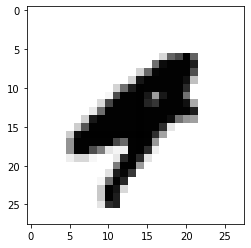



2 [ Predicted Value: 0, Actual Value: 8 ]


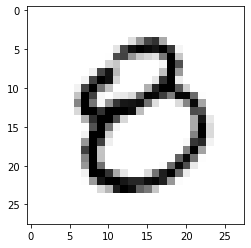



3 [ Predicted Value: 0, Actual Value: 5 ]


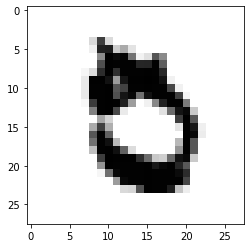



4 [ Predicted Value: 1, Actual Value: 2 ]


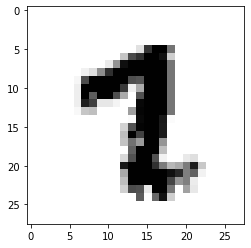



5 [ Predicted Value: 5, Actual Value: 3 ]


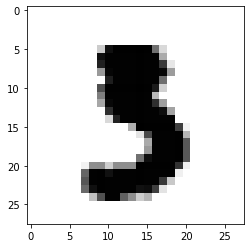



6 [ Predicted Value: 4, Actual Value: 9 ]


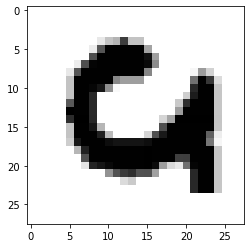



7 [ Predicted Value: 2, Actual Value: 3 ]


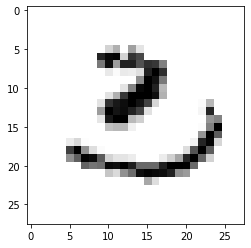



8 [ Predicted Value: 2, Actual Value: 7 ]


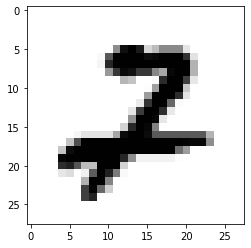



9 [ Predicted Value: 0, Actual Value: 8 ]


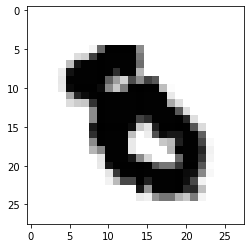



10 [ Predicted Value: 3, Actual Value: 1 ]


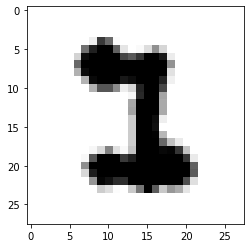



11 [ Predicted Value: 4, Actual Value: 6 ]


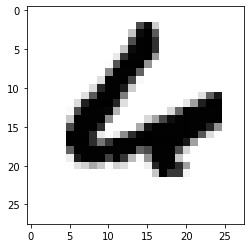



12 [ Predicted Value: 0, Actual Value: 6 ]


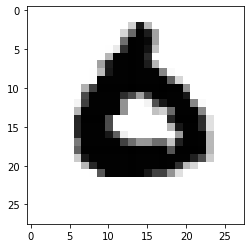



13 [ Predicted Value: 2, Actual Value: 6 ]


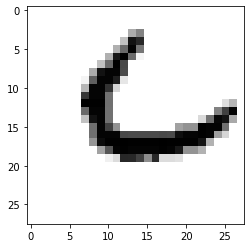



14 [ Predicted Value: 2, Actual Value: 1 ]


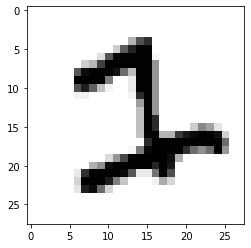



15 [ Predicted Value: 7, Actual Value: 8 ]


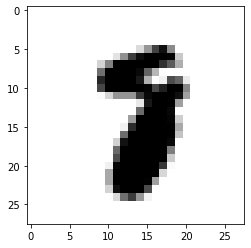



16 [ Predicted Value: 0, Actual Value: 8 ]


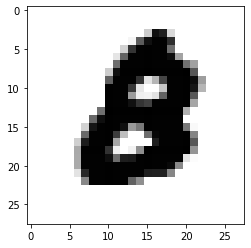



17 [ Predicted Value: 2, Actual Value: 6 ]


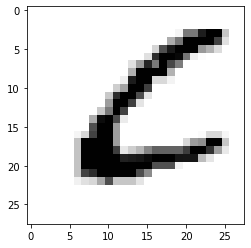



18 [ Predicted Value: 1, Actual Value: 3 ]


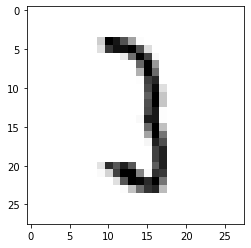



19 [ Predicted Value: 2, Actual Value: 3 ]


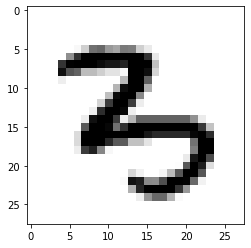



20 [ Predicted Value: 0, Actual Value: 8 ]


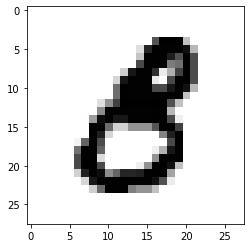



21 [ Predicted Value: 0, Actual Value: 8 ]


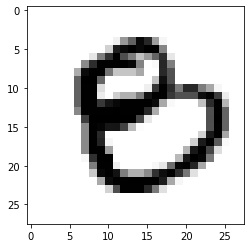



22 [ Predicted Value: 2, Actual Value: 7 ]


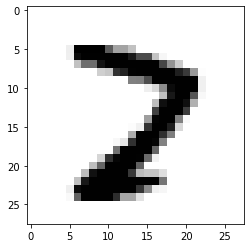



23 [ Predicted Value: 0, Actual Value: 6 ]


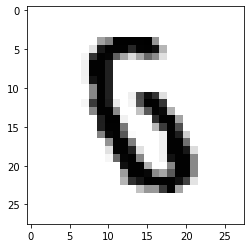



24 [ Predicted Value: 9, Actual Value: 8 ]


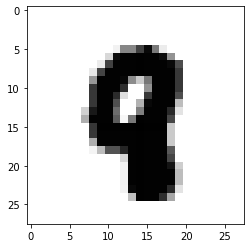



25 [ Predicted Value: 0, Actual Value: 6 ]


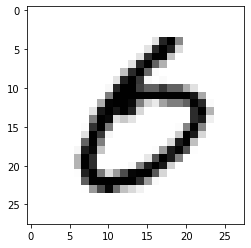



26 [ Predicted Value: 1, Actual Value: 7 ]


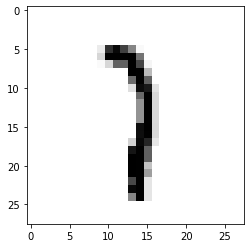



27 [ Predicted Value: 2, Actual Value: 8 ]


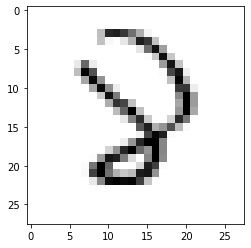



28 [ Predicted Value: 7, Actual Value: 9 ]


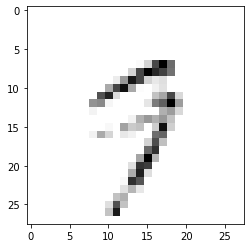



29 [ Predicted Value: 2, Actual Value: 7 ]


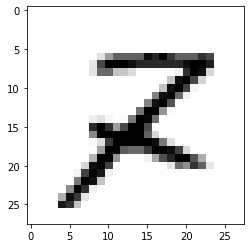



30 [ Predicted Value: 8, Actual Value: 3 ]


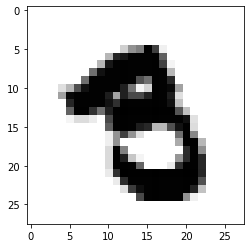



31 [ Predicted Value: 2, Actual Value: 0 ]


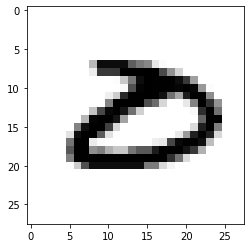



32 [ Predicted Value: 7, Actual Value: 9 ]


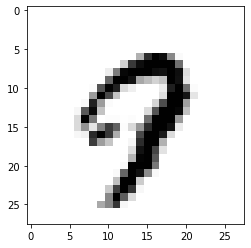



33 [ Predicted Value: 9, Actual Value: 4 ]


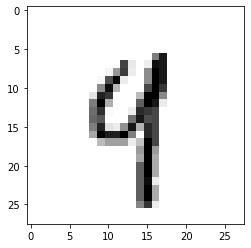



34 [ Predicted Value: 7, Actual Value: 2 ]


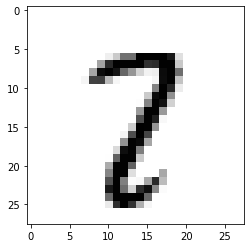



35 [ Predicted Value: 5, Actual Value: 3 ]


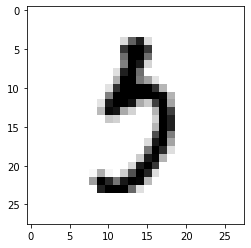



36 [ Predicted Value: 5, Actual Value: 6 ]


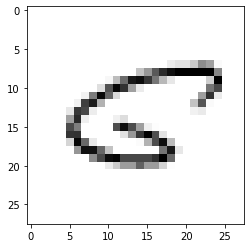



37 [ Predicted Value: 4, Actual Value: 9 ]


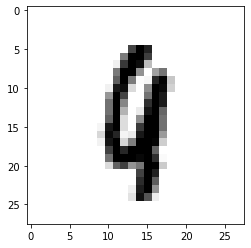



38 [ Predicted Value: 2, Actual Value: 7 ]


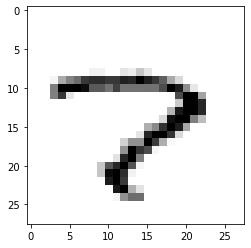



39 [ Predicted Value: 0, Actual Value: 8 ]


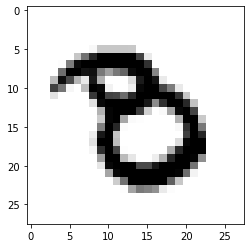



40 [ Predicted Value: 2, Actual Value: 7 ]


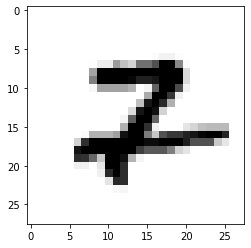



41 [ Predicted Value: 3, Actual Value: 8 ]


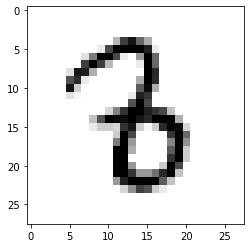



42 [ Predicted Value: 8, Actual Value: 6 ]


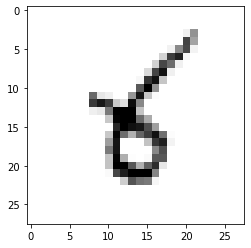



43 [ Predicted Value: 0, Actual Value: 6 ]


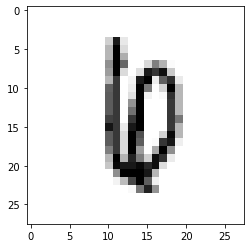



44 [ Predicted Value: 0, Actual Value: 2 ]


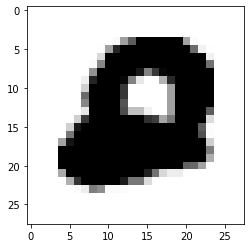



45 [ Predicted Value: 0, Actual Value: 6 ]


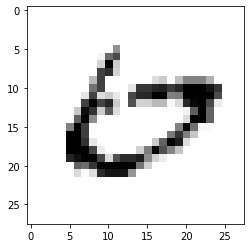



46 [ Predicted Value: 1, Actual Value: 6 ]


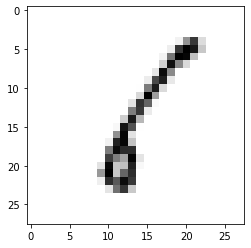



47 [ Predicted Value: 4, Actual Value: 9 ]


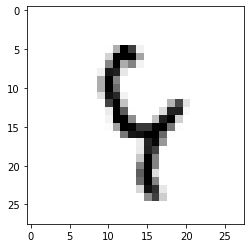



48 [ Predicted Value: 4, Actual Value: 9 ]


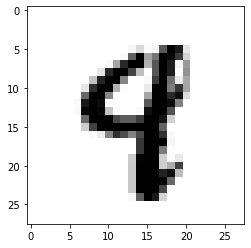



49 [ Predicted Value: 0, Actual Value: 8 ]


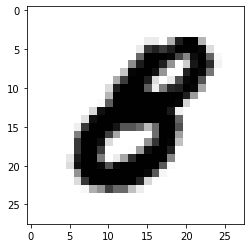



50 [ Predicted Value: 2, Actual Value: 6 ]


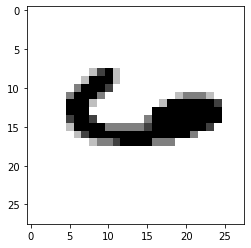



51 [ Predicted Value: 0, Actual Value: 8 ]


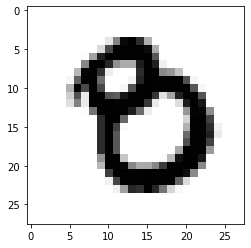



52 [ Predicted Value: 1, Actual Value: 6 ]


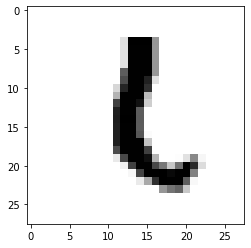



53 [ Predicted Value: 0, Actual Value: 8 ]


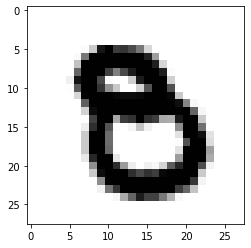



54 [ Predicted Value: 1, Actual Value: 7 ]


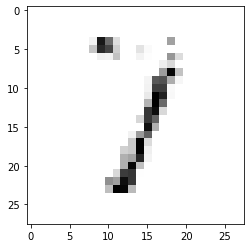



55 [ Predicted Value: 9, Actual Value: 8 ]


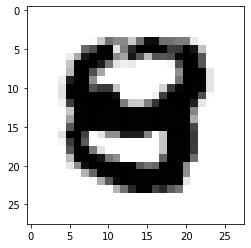



56 [ Predicted Value: 9, Actual Value: 4 ]


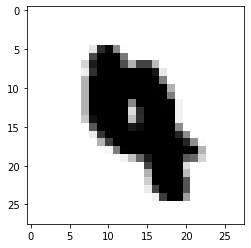



57 [ Predicted Value: 5, Actual Value: 9 ]


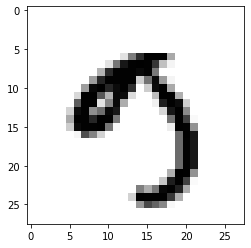



58 [ Predicted Value: 0, Actual Value: 6 ]


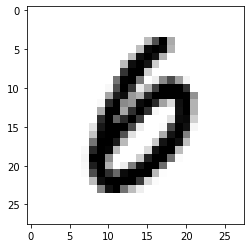



59 [ Predicted Value: 5, Actual Value: 8 ]


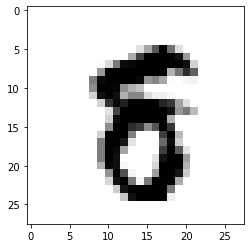



60 [ Predicted Value: 2, Actual Value: 7 ]


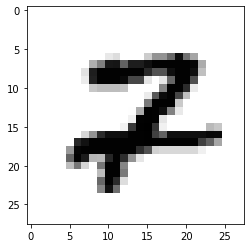



61 [ Predicted Value: 1, Actual Value: 7 ]


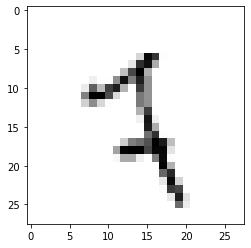



62 [ Predicted Value: 3, Actual Value: 5 ]


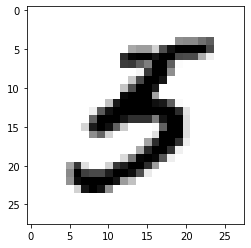



63 [ Predicted Value: 2, Actual Value: 8 ]


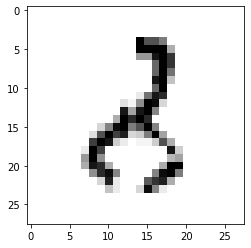



64 [ Predicted Value: 5, Actual Value: 3 ]


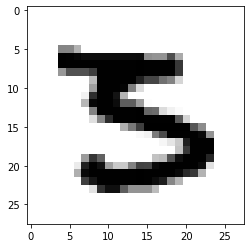



65 [ Predicted Value: 5, Actual Value: 8 ]


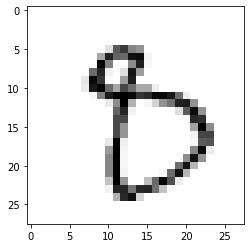



66 [ Predicted Value: 0, Actual Value: 8 ]


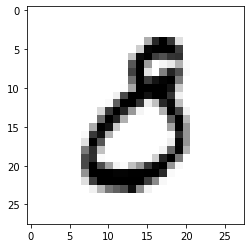



67 [ Predicted Value: 5, Actual Value: 3 ]


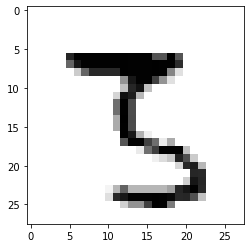



68 [ Predicted Value: 0, Actual Value: 8 ]


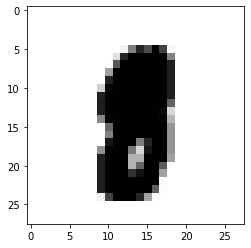



69 [ Predicted Value: 7, Actual Value: 0 ]


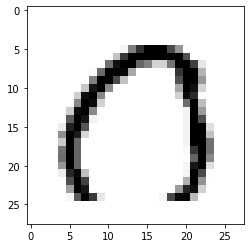



70 [ Predicted Value: 6, Actual Value: 5 ]


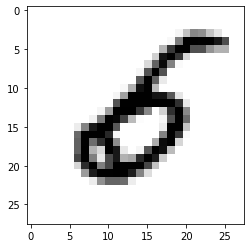



71 [ Predicted Value: 3, Actual Value: 1 ]


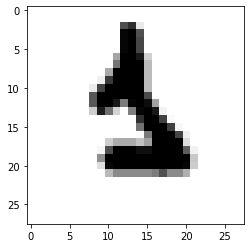



72 [ Predicted Value: 5, Actual Value: 3 ]


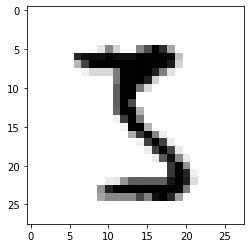



73 [ Predicted Value: 2, Actual Value: 5 ]


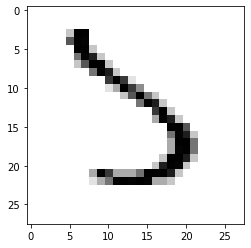



74 [ Predicted Value: 2, Actual Value: 6 ]


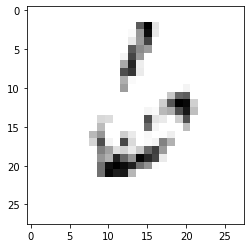



75 [ Predicted Value: 7, Actual Value: 9 ]


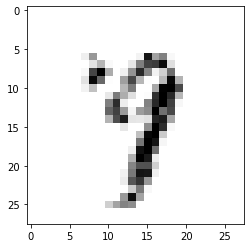



76 [ Predicted Value: 3, Actual Value: 8 ]


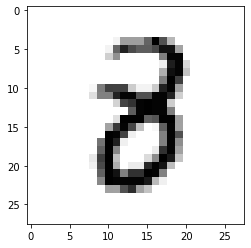



77 [ Predicted Value: 5, Actual Value: 8 ]


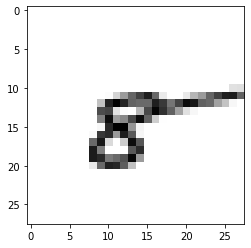



78 [ Predicted Value: 4, Actual Value: 6 ]


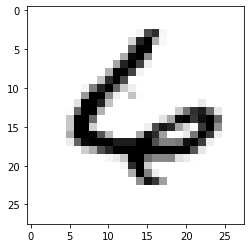



79 [ Predicted Value: 7, Actual Value: 8 ]


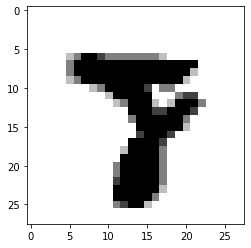



80 [ Predicted Value: 0, Actual Value: 6 ]


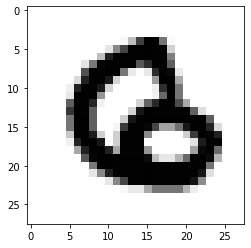



81 [ Predicted Value: 1, Actual Value: 8 ]


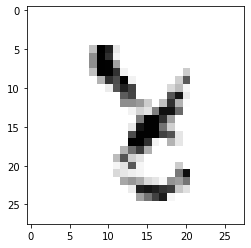



82 [ Predicted Value: 1, Actual Value: 7 ]


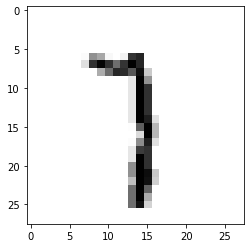

In [18]:
print('\n################With Both L1 and L2 Optimisations##################################\n')

train_losses_l1_l2_b, train_acc_l1_l2_b, test_losses_l1_l2_b, test_acc_l1_l2_b = trainModel('_l1_l2', L1_Flag =True, L2_Flag = True, alpha = al )


##Validation Accuracy and Loss Plots


*****************Test Plots for lambda = 0.0005*********************



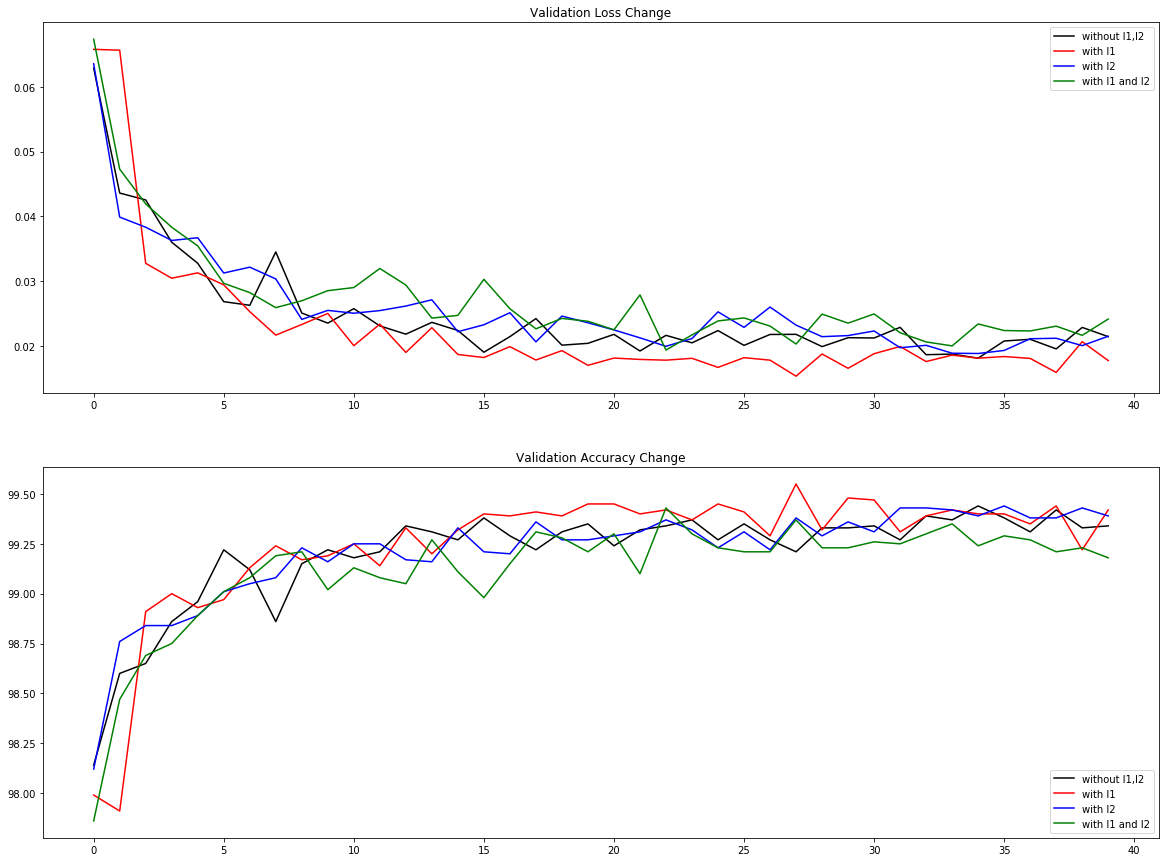

In [20]:
print('\n*****************Test Plots for lambda = {}*********************\n'.format(al))
plotGraphsTest(test_losses_0, test_losses_l1_b, test_losses_l2_b, test_losses_l1_l2_b, test_acc_0, test_acc_l1_b, test_acc_l2_b, test_acc_l1_l2_b)

##Train Accuracy and Loss Plot


*****************Train Plots for lambda = 0.0005*********************



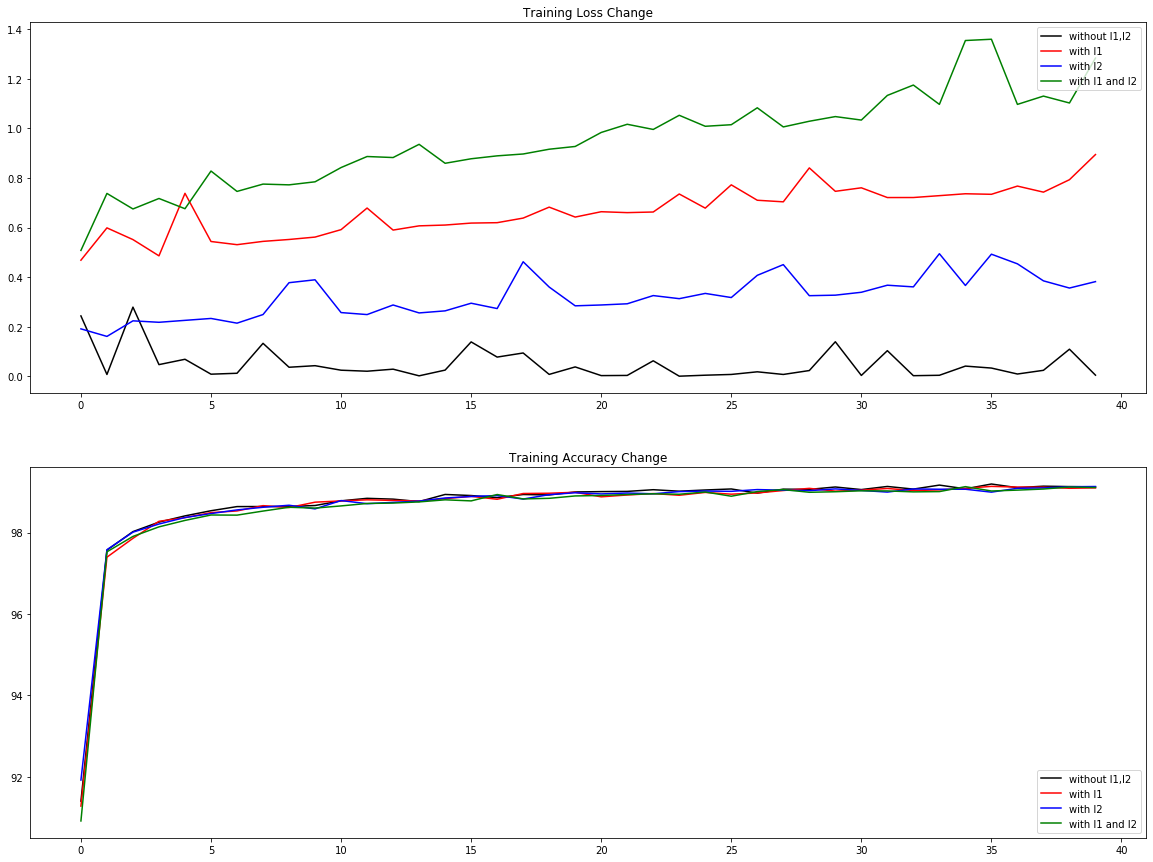

In [23]:
print('\n*****************Train Plots for lambda = {}*********************\n'.format(al))
plotGraphsTrain(train_losses_0, train_losses_l1_b, train_losses_l2_b, train_losses_l1_l2_b, train_acc_0, train_acc_l1_b, train_acc_l2_b, train_acc_l1_l2_b)

#Lambda = 0.005

In [0]:
al = 0.005

##With L1 Optimisation

  0%|          | 0/938 [00:00<?, ?it/s]


#########################With L1 Optimisation######################################

alpha =  0.005
EPOCH _l1 0


Loss=3.7222039699554443 Batch_id=937 Accuracy=91.00: 100%|██████████| 938/938 [00:17<00:00, 53.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1355, Accuracy: 9554/10000 (95.54%)

EPOCH _l1 1


Loss=4.1112213134765625 Batch_id=937 Accuracy=97.28: 100%|██████████| 938/938 [00:17<00:00, 53.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0437, Accuracy: 9857/10000 (98.57%)

EPOCH _l1 2


Loss=4.380271911621094 Batch_id=937 Accuracy=97.82: 100%|██████████| 938/938 [00:17<00:00, 53.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0412, Accuracy: 9865/10000 (98.65%)

EPOCH _l1 3


Loss=4.622278690338135 Batch_id=937 Accuracy=98.19: 100%|██████████| 938/938 [00:17<00:00, 54.41it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0385, Accuracy: 9873/10000 (98.73%)

EPOCH _l1 4


Loss=4.857024192810059 Batch_id=937 Accuracy=98.28: 100%|██████████| 938/938 [00:18<00:00, 52.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0343, Accuracy: 9885/10000 (98.85%)

EPOCH _l1 5


Loss=4.999906063079834 Batch_id=937 Accuracy=98.33: 100%|██████████| 938/938 [00:17<00:00, 52.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9900/10000 (99.00%)

EPOCH _l1 6


Loss=5.110733509063721 Batch_id=937 Accuracy=98.48: 100%|██████████| 938/938 [00:17<00:00, 53.06it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0352, Accuracy: 9873/10000 (98.73%)

EPOCH _l1 7


Loss=5.347286224365234 Batch_id=937 Accuracy=98.52: 100%|██████████| 938/938 [00:17<00:00, 52.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0330, Accuracy: 9886/10000 (98.86%)

EPOCH _l1 8


Loss=5.380062103271484 Batch_id=937 Accuracy=98.70: 100%|██████████| 938/938 [00:17<00:00, 59.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9910/10000 (99.10%)

EPOCH _l1 9


Loss=5.614144325256348 Batch_id=937 Accuracy=98.58: 100%|██████████| 938/938 [00:17<00:00, 53.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9909/10000 (99.09%)

EPOCH _l1 10


Loss=5.627003192901611 Batch_id=937 Accuracy=98.68: 100%|██████████| 938/938 [00:17<00:00, 52.81it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9913/10000 (99.13%)

EPOCH _l1 11


Loss=5.713598251342773 Batch_id=937 Accuracy=98.72: 100%|██████████| 938/938 [00:17<00:00, 54.25it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9922/10000 (99.22%)

EPOCH _l1 12


Loss=5.8196635246276855 Batch_id=937 Accuracy=98.83: 100%|██████████| 938/938 [00:17<00:00, 53.10it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9918/10000 (99.18%)

EPOCH _l1 13


Loss=5.975725173950195 Batch_id=937 Accuracy=98.75: 100%|██████████| 938/938 [00:17<00:00, 53.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9914/10000 (99.14%)

EPOCH _l1 14


Loss=6.178464412689209 Batch_id=937 Accuracy=98.71: 100%|██████████| 938/938 [00:17<00:00, 53.47it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9903/10000 (99.03%)

EPOCH _l1 15


Loss=6.097010612487793 Batch_id=937 Accuracy=98.79: 100%|██████████| 938/938 [00:17<00:00, 54.05it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9915/10000 (99.15%)

EPOCH _l1 16


Loss=6.190692901611328 Batch_id=937 Accuracy=98.83: 100%|██████████| 938/938 [00:17<00:00, 55.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9915/10000 (99.15%)

EPOCH _l1 17


Loss=6.281481742858887 Batch_id=937 Accuracy=98.90: 100%|██████████| 938/938 [00:17<00:00, 53.16it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9918/10000 (99.18%)

EPOCH _l1 18


Loss=6.346886157989502 Batch_id=937 Accuracy=98.94: 100%|██████████| 938/938 [00:17<00:00, 54.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9908/10000 (99.08%)

EPOCH _l1 19


Loss=6.391098499298096 Batch_id=937 Accuracy=98.92: 100%|██████████| 938/938 [00:17<00:00, 53.52it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9910/10000 (99.10%)

EPOCH _l1 20


Loss=6.473015308380127 Batch_id=937 Accuracy=98.95: 100%|██████████| 938/938 [00:17<00:00, 54.03it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9919/10000 (99.19%)

EPOCH _l1 21


Loss=6.547395706176758 Batch_id=937 Accuracy=98.86: 100%|██████████| 938/938 [00:17<00:00, 52.70it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9920/10000 (99.20%)

EPOCH _l1 22


Loss=6.590756893157959 Batch_id=937 Accuracy=98.92: 100%|██████████| 938/938 [00:17<00:00, 53.43it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9925/10000 (99.25%)

EPOCH _l1 23


Loss=6.637671947479248 Batch_id=937 Accuracy=98.96: 100%|██████████| 938/938 [00:17<00:00, 53.93it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9923/10000 (99.23%)

EPOCH _l1 24


Loss=6.707176208496094 Batch_id=937 Accuracy=98.97: 100%|██████████| 938/938 [00:17<00:00, 52.48it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9925/10000 (99.25%)

EPOCH _l1 25


Loss=6.761066913604736 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [00:17<00:00, 53.29it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9933/10000 (99.33%)

EPOCH _l1 26


Loss=6.811883449554443 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:17<00:00, 52.67it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9927/10000 (99.27%)

EPOCH _l1 27


Loss=6.878479957580566 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:17<00:00, 52.94it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9930/10000 (99.30%)

EPOCH _l1 28


Loss=6.917198657989502 Batch_id=937 Accuracy=99.10: 100%|██████████| 938/938 [00:17<00:00, 54.79it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9933/10000 (99.33%)

EPOCH _l1 29


Loss=7.154407501220703 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:17<00:00, 53.53it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9929/10000 (99.29%)

EPOCH _l1 30


Loss=7.017782688140869 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [00:17<00:00, 52.77it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9928/10000 (99.28%)

EPOCH _l1 31


Loss=7.090232849121094 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:17<00:00, 54.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9923/10000 (99.23%)

EPOCH _l1 32


Loss=7.122406005859375 Batch_id=937 Accuracy=99.07: 100%|██████████| 938/938 [00:17<00:00, 53.34it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9927/10000 (99.27%)

EPOCH _l1 33


Loss=7.161434173583984 Batch_id=937 Accuracy=98.98: 100%|██████████| 938/938 [00:17<00:00, 53.27it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9934/10000 (99.34%)

EPOCH _l1 34


Loss=7.232832431793213 Batch_id=937 Accuracy=99.04: 100%|██████████| 938/938 [00:17<00:00, 62.58it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9924/10000 (99.24%)

EPOCH _l1 35


Loss=7.2666521072387695 Batch_id=937 Accuracy=99.03: 100%|██████████| 938/938 [00:17<00:00, 52.26it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9926/10000 (99.26%)

EPOCH _l1 36


Loss=7.317910671234131 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:17<00:00, 60.43it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9937/10000 (99.37%)

EPOCH _l1 37


Loss=7.481558799743652 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:17<00:00, 52.43it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9934/10000 (99.34%)

EPOCH _l1 38


Loss=7.485965728759766 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [00:17<00:00, 52.45it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9938/10000 (99.38%)

EPOCH _l1 39


Loss=7.551819801330566 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:17<00:00, 53.24it/s]



Test set: Average loss: 0.0193, Accuracy: 9942/10000 (99.42%)


@@@@@@@@@@@@@MISCLASSIFIED IMAGES@@@@@@@@@@@@@@@@@@@@@@@@@@@



1 [ Predicted Value: 7, Actual Value: 9 ]


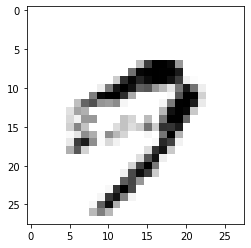



2 [ Predicted Value: 3, Actual Value: 8 ]


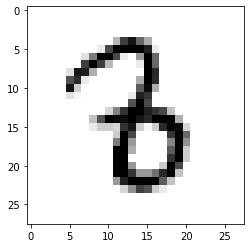



3 [ Predicted Value: 5, Actual Value: 6 ]


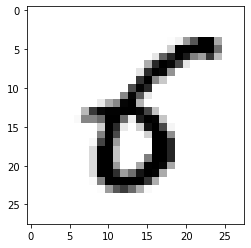



4 [ Predicted Value: 6, Actual Value: 1 ]


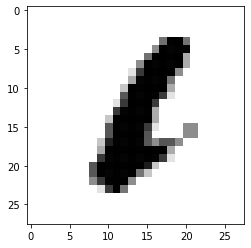



5 [ Predicted Value: 5, Actual Value: 0 ]


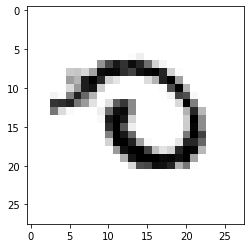



6 [ Predicted Value: 2, Actual Value: 8 ]


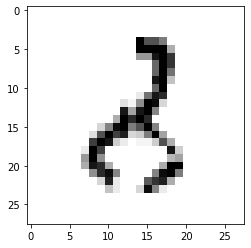



7 [ Predicted Value: 4, Actual Value: 9 ]


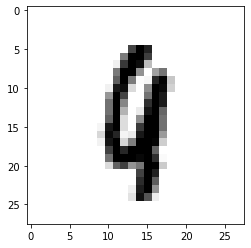



8 [ Predicted Value: 1, Actual Value: 6 ]


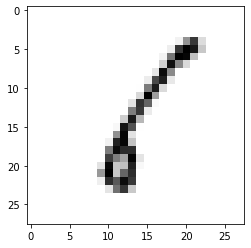



9 [ Predicted Value: 8, Actual Value: 9 ]


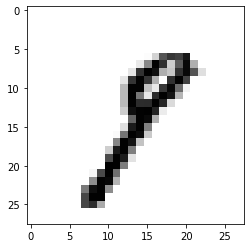



10 [ Predicted Value: 1, Actual Value: 3 ]


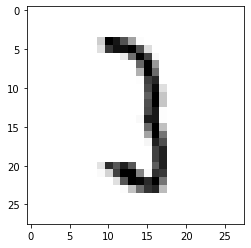



11 [ Predicted Value: 5, Actual Value: 3 ]


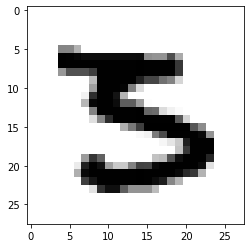



12 [ Predicted Value: 2, Actual Value: 7 ]


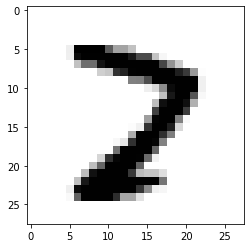



13 [ Predicted Value: 0, Actual Value: 6 ]


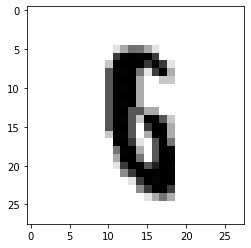



14 [ Predicted Value: 2, Actual Value: 7 ]


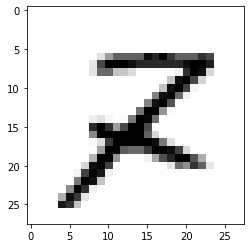



15 [ Predicted Value: 8, Actual Value: 7 ]


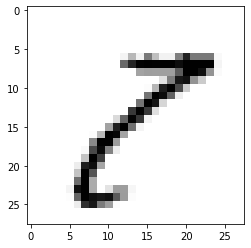



16 [ Predicted Value: 9, Actual Value: 4 ]


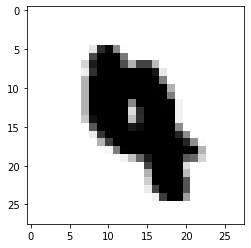



17 [ Predicted Value: 9, Actual Value: 8 ]


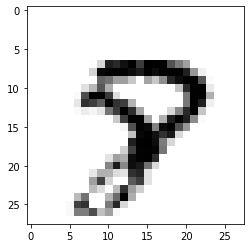



18 [ Predicted Value: 9, Actual Value: 4 ]


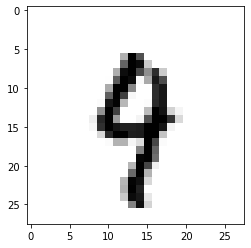



19 [ Predicted Value: 5, Actual Value: 6 ]


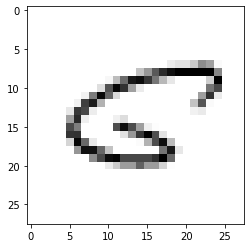



20 [ Predicted Value: 1, Actual Value: 6 ]


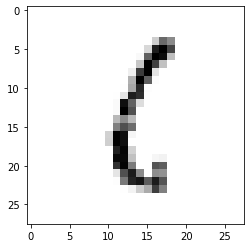



21 [ Predicted Value: 1, Actual Value: 7 ]


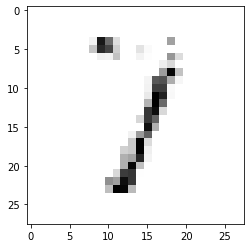



22 [ Predicted Value: 5, Actual Value: 3 ]


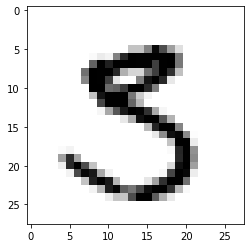



23 [ Predicted Value: 8, Actual Value: 6 ]


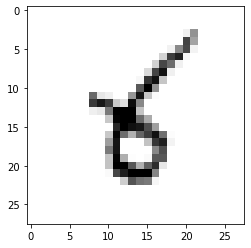



24 [ Predicted Value: 5, Actual Value: 8 ]


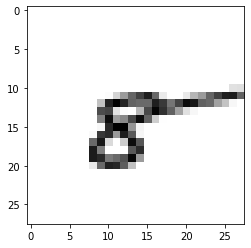



25 [ Predicted Value: 0, Actual Value: 2 ]


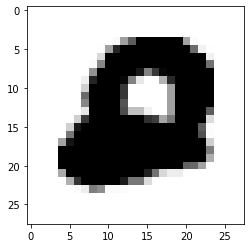



26 [ Predicted Value: 3, Actual Value: 5 ]


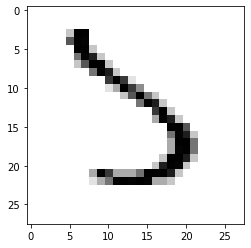



27 [ Predicted Value: 1, Actual Value: 7 ]


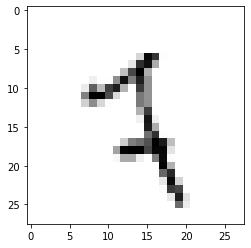



28 [ Predicted Value: 9, Actual Value: 4 ]


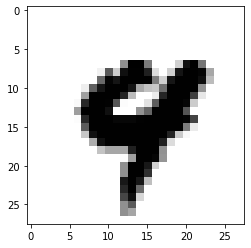



29 [ Predicted Value: 3, Actual Value: 1 ]


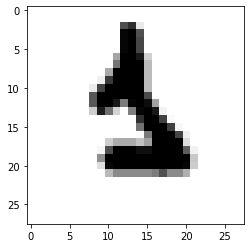



30 [ Predicted Value: 5, Actual Value: 3 ]


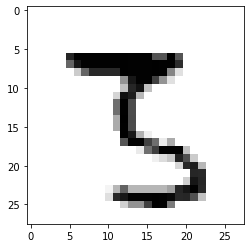



31 [ Predicted Value: 7, Actual Value: 2 ]


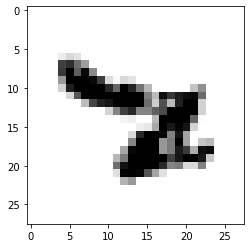



32 [ Predicted Value: 3, Actual Value: 2 ]


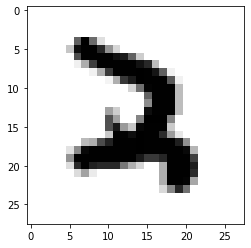



33 [ Predicted Value: 2, Actual Value: 7 ]


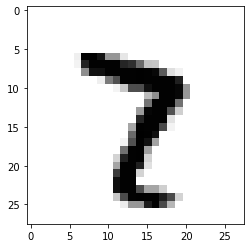



34 [ Predicted Value: 9, Actual Value: 4 ]


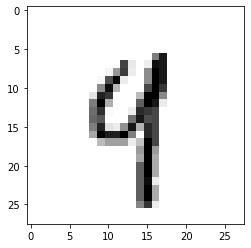



35 [ Predicted Value: 0, Actual Value: 6 ]


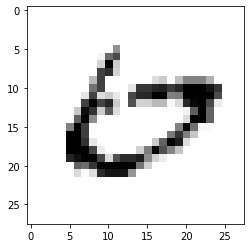



36 [ Predicted Value: 2, Actual Value: 7 ]


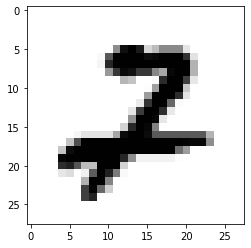



37 [ Predicted Value: 4, Actual Value: 9 ]


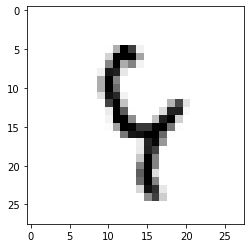



38 [ Predicted Value: 0, Actual Value: 8 ]


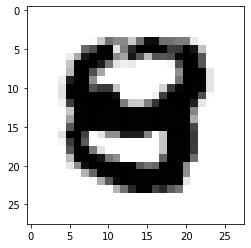



39 [ Predicted Value: 2, Actual Value: 8 ]


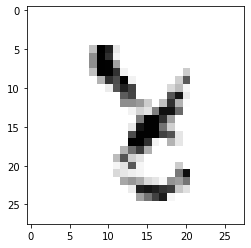



40 [ Predicted Value: 2, Actual Value: 4 ]


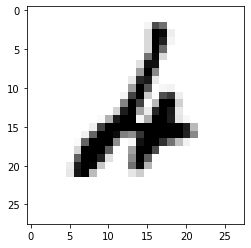



41 [ Predicted Value: 7, Actual Value: 8 ]


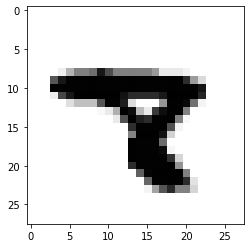



42 [ Predicted Value: 2, Actual Value: 0 ]


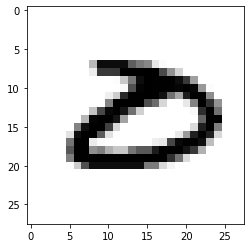



43 [ Predicted Value: 1, Actual Value: 6 ]


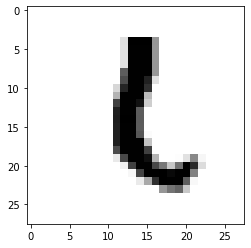



44 [ Predicted Value: 6, Actual Value: 0 ]


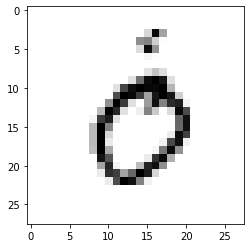



45 [ Predicted Value: 4, Actual Value: 6 ]


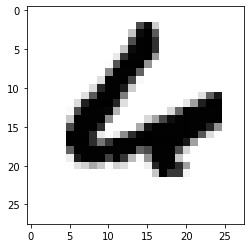



46 [ Predicted Value: 4, Actual Value: 9 ]


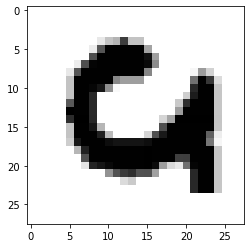



47 [ Predicted Value: 9, Actual Value: 4 ]


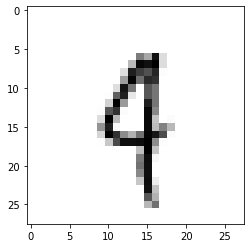



48 [ Predicted Value: 9, Actual Value: 8 ]


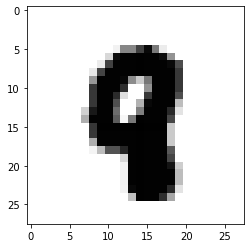



49 [ Predicted Value: 2, Actual Value: 1 ]


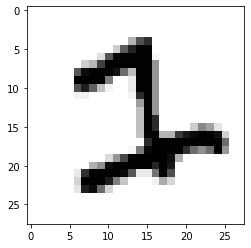



50 [ Predicted Value: 5, Actual Value: 3 ]


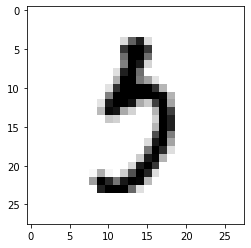



51 [ Predicted Value: 6, Actual Value: 5 ]


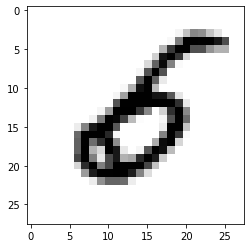



52 [ Predicted Value: 1, Actual Value: 7 ]


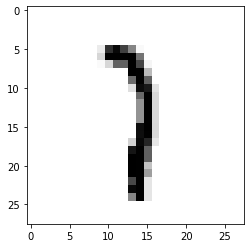



53 [ Predicted Value: 3, Actual Value: 5 ]


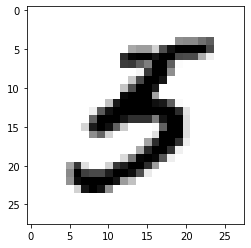



54 [ Predicted Value: 0, Actual Value: 6 ]


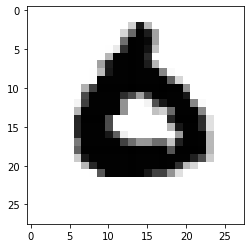



55 [ Predicted Value: 0, Actual Value: 6 ]


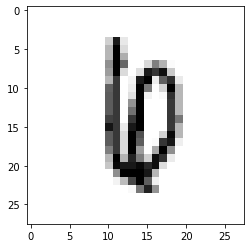



56 [ Predicted Value: 9, Actual Value: 8 ]


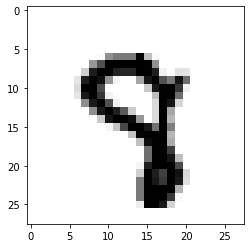



57 [ Predicted Value: 3, Actual Value: 5 ]


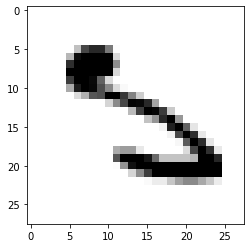



58 [ Predicted Value: 9, Actual Value: 4 ]


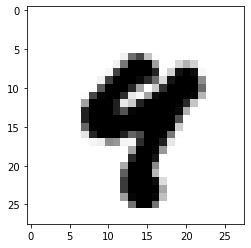

In [25]:
print('\n#########################With L1 Optimisation######################################\n')

train_losses_l1_c, train_acc_l1_c, test_losses_l1_c, test_acc_l1_c = trainModel('_l1', L1_Flag =True, L2_Flag = False, alpha = al )

##With L2 Optimisation

  0%|          | 0/938 [00:00<?, ?it/s]


#########################With L2 Optimisation######################################

alpha =  0.005
EPOCH _l2 0


Loss=1.3660756349563599 Batch_id=937 Accuracy=91.96: 100%|██████████| 938/938 [00:17<00:00, 53.21it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0522, Accuracy: 9843/10000 (98.43%)

EPOCH _l2 1


Loss=1.5446234941482544 Batch_id=937 Accuracy=97.75: 100%|██████████| 938/938 [00:18<00:00, 51.70it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0531, Accuracy: 9846/10000 (98.46%)

EPOCH _l2 2


Loss=1.8175406455993652 Batch_id=937 Accuracy=98.21: 100%|██████████| 938/938 [00:18<00:00, 51.92it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9922/10000 (99.22%)

EPOCH _l2 3


Loss=1.9623143672943115 Batch_id=937 Accuracy=98.39: 100%|██████████| 938/938 [00:17<00:00, 53.10it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0344, Accuracy: 9896/10000 (98.96%)

EPOCH _l2 4


Loss=1.8957746028900146 Batch_id=937 Accuracy=98.57: 100%|██████████| 938/938 [00:18<00:00, 50.13it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9914/10000 (99.14%)

EPOCH _l2 5


Loss=2.150270938873291 Batch_id=937 Accuracy=98.54: 100%|██████████| 938/938 [00:18<00:00, 51.43it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9910/10000 (99.10%)

EPOCH _l2 6


Loss=2.1699681282043457 Batch_id=937 Accuracy=98.67: 100%|██████████| 938/938 [00:17<00:00, 53.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9908/10000 (99.08%)

EPOCH _l2 7


Loss=2.159318208694458 Batch_id=937 Accuracy=98.65: 100%|██████████| 938/938 [00:17<00:00, 53.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9920/10000 (99.20%)

EPOCH _l2 8


Loss=2.2483460903167725 Batch_id=937 Accuracy=98.77: 100%|██████████| 938/938 [00:17<00:00, 62.08it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9924/10000 (99.24%)

EPOCH _l2 9


Loss=2.2536067962646484 Batch_id=937 Accuracy=98.74: 100%|██████████| 938/938 [00:17<00:00, 53.03it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9922/10000 (99.22%)

EPOCH _l2 10


Loss=2.309823989868164 Batch_id=937 Accuracy=98.86: 100%|██████████| 938/938 [00:17<00:00, 53.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9915/10000 (99.15%)

EPOCH _l2 11


Loss=2.390634298324585 Batch_id=937 Accuracy=98.80: 100%|██████████| 938/938 [00:17<00:00, 52.58it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9923/10000 (99.23%)

EPOCH _l2 12


Loss=2.432157039642334 Batch_id=937 Accuracy=98.88: 100%|██████████| 938/938 [00:17<00:00, 53.23it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9927/10000 (99.27%)

EPOCH _l2 13


Loss=2.4681124687194824 Batch_id=937 Accuracy=98.91: 100%|██████████| 938/938 [00:17<00:00, 63.03it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9925/10000 (99.25%)

EPOCH _l2 14


Loss=2.722806930541992 Batch_id=937 Accuracy=98.81: 100%|██████████| 938/938 [00:18<00:00, 51.57it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9942/10000 (99.42%)

EPOCH _l2 15


Loss=2.572345495223999 Batch_id=937 Accuracy=98.89: 100%|██████████| 938/938 [00:17<00:00, 52.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9935/10000 (99.35%)

EPOCH _l2 16


Loss=2.758699655532837 Batch_id=937 Accuracy=98.89: 100%|██████████| 938/938 [00:18<00:00, 51.82it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9930/10000 (99.30%)

EPOCH _l2 17


Loss=2.6700363159179688 Batch_id=937 Accuracy=98.92: 100%|██████████| 938/938 [00:18<00:00, 50.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9934/10000 (99.34%)

EPOCH _l2 18


Loss=2.7086544036865234 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [00:17<00:00, 52.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9935/10000 (99.35%)

EPOCH _l2 19


Loss=2.749448299407959 Batch_id=937 Accuracy=98.90: 100%|██████████| 938/938 [00:18<00:00, 51.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9945/10000 (99.45%)

EPOCH _l2 20


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9945/10000 (99.45%)

EPOCH _l2 21


Loss=2.8600826263427734 Batch_id=937 Accuracy=99.01: 100%|██████████| 938/938 [00:18<00:00, 51.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9923/10000 (99.23%)

EPOCH _l2 22


Loss=2.894845962524414 Batch_id=937 Accuracy=98.97: 100%|██████████| 938/938 [00:18<00:00, 50.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9920/10000 (99.20%)

EPOCH _l2 23


Loss=2.9515819549560547 Batch_id=937 Accuracy=98.94: 100%|██████████| 938/938 [00:18<00:00, 51.43it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9922/10000 (99.22%)

EPOCH _l2 24


Loss=2.969740152359009 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:17<00:00, 52.21it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9934/10000 (99.34%)

EPOCH _l2 25


Loss=3.007972478866577 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:18<00:00, 50.17it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9944/10000 (99.44%)

EPOCH _l2 26


Loss=3.0378682613372803 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [00:18<00:00, 50.33it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9928/10000 (99.28%)

EPOCH _l2 27


Loss=3.0970962047576904 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:18<00:00, 50.94it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9940/10000 (99.40%)

EPOCH _l2 28


Loss=3.1353132724761963 Batch_id=937 Accuracy=99.13: 100%|██████████| 938/938 [00:18<00:00, 50.27it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9926/10000 (99.26%)

EPOCH _l2 29


Loss=3.1534202098846436 Batch_id=937 Accuracy=99.09: 100%|██████████| 938/938 [00:19<00:00, 49.31it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9925/10000 (99.25%)

EPOCH _l2 30


Loss=3.2935311794281006 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [00:18<00:00, 50.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9936/10000 (99.36%)

EPOCH _l2 31


Loss=3.2274835109710693 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:18<00:00, 50.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9943/10000 (99.43%)

EPOCH _l2 32


Loss=3.2891557216644287 Batch_id=937 Accuracy=99.09: 100%|██████████| 938/938 [00:19<00:00, 48.31it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9936/10000 (99.36%)

EPOCH _l2 33


Loss=3.2889926433563232 Batch_id=937 Accuracy=99.04: 100%|██████████| 938/938 [00:18<00:00, 49.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9939/10000 (99.39%)

EPOCH _l2 34


Loss=3.3284218311309814 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:19<00:00, 48.94it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9935/10000 (99.35%)

EPOCH _l2 35


Loss=3.4319422245025635 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [00:19<00:00, 49.20it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9929/10000 (99.29%)

EPOCH _l2 36


Loss=3.38958477973938 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:18<00:00, 50.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9937/10000 (99.37%)

EPOCH _l2 37


Loss=3.425105333328247 Batch_id=937 Accuracy=99.18: 100%|██████████| 938/938 [00:19<00:00, 46.95it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9940/10000 (99.40%)

EPOCH _l2 38


Loss=3.4649386405944824 Batch_id=937 Accuracy=99.04: 100%|██████████| 938/938 [00:20<00:00, 45.67it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9937/10000 (99.37%)

EPOCH _l2 39


Loss=3.4904932975769043 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:20<00:00, 44.91it/s]



Test set: Average loss: 0.0205, Accuracy: 9936/10000 (99.36%)


@@@@@@@@@@@@@MISCLASSIFIED IMAGES@@@@@@@@@@@@@@@@@@@@@@@@@@@



1 [ Predicted Value: 0, Actual Value: 2 ]


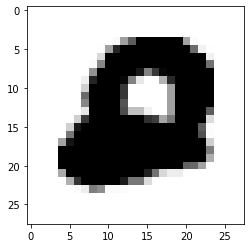



2 [ Predicted Value: 2, Actual Value: 7 ]


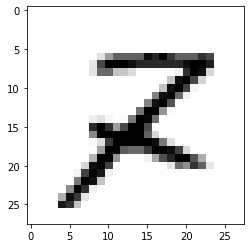



3 [ Predicted Value: 0, Actual Value: 8 ]


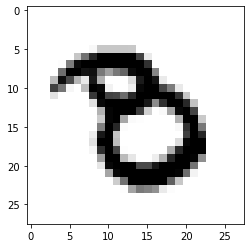



4 [ Predicted Value: 2, Actual Value: 7 ]


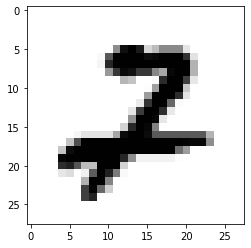



5 [ Predicted Value: 7, Actual Value: 2 ]


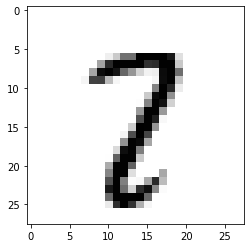



6 [ Predicted Value: 9, Actual Value: 7 ]


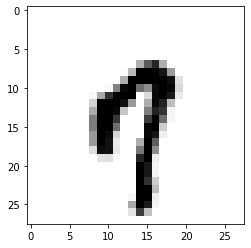



7 [ Predicted Value: 0, Actual Value: 6 ]


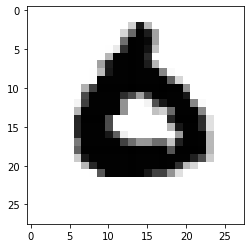



8 [ Predicted Value: 9, Actual Value: 8 ]


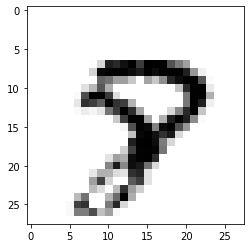



9 [ Predicted Value: 1, Actual Value: 7 ]


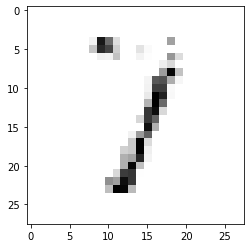



10 [ Predicted Value: 6, Actual Value: 4 ]


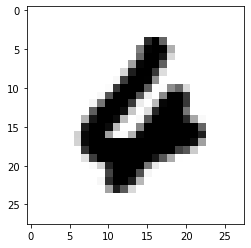



11 [ Predicted Value: 3, Actual Value: 8 ]


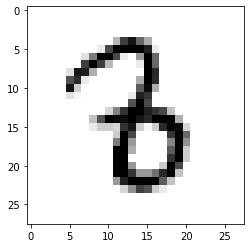



12 [ Predicted Value: 9, Actual Value: 4 ]


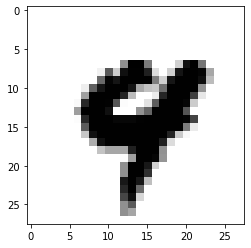



13 [ Predicted Value: 0, Actual Value: 9 ]


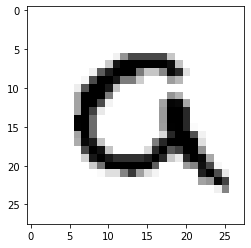



14 [ Predicted Value: 4, Actual Value: 9 ]


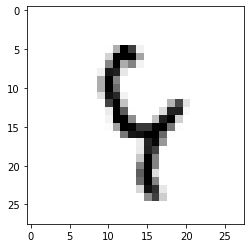



15 [ Predicted Value: 9, Actual Value: 4 ]


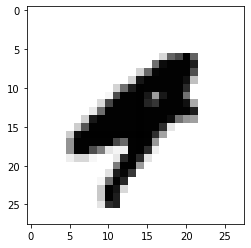



16 [ Predicted Value: 9, Actual Value: 7 ]


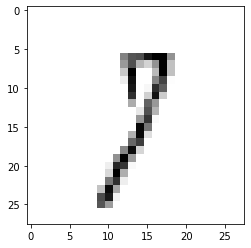



17 [ Predicted Value: 2, Actual Value: 8 ]


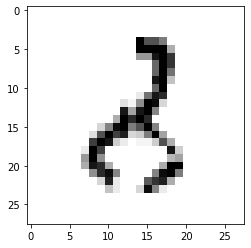



18 [ Predicted Value: 0, Actual Value: 6 ]


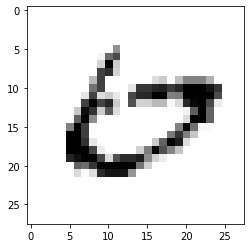



19 [ Predicted Value: 0, Actual Value: 6 ]


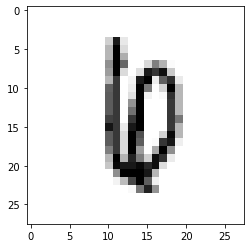



20 [ Predicted Value: 1, Actual Value: 7 ]


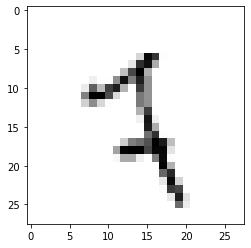



21 [ Predicted Value: 5, Actual Value: 8 ]


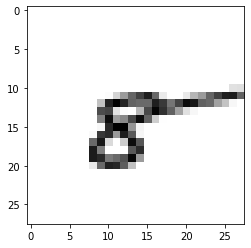



22 [ Predicted Value: 6, Actual Value: 5 ]


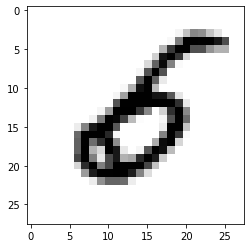



23 [ Predicted Value: 9, Actual Value: 4 ]


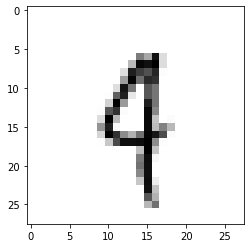



24 [ Predicted Value: 2, Actual Value: 0 ]


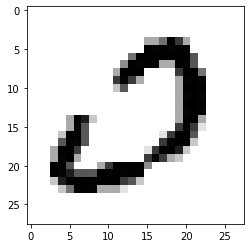



25 [ Predicted Value: 9, Actual Value: 8 ]


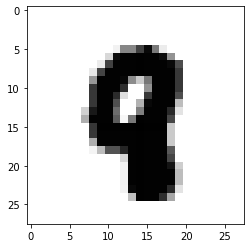



26 [ Predicted Value: 9, Actual Value: 4 ]


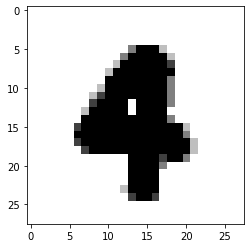



27 [ Predicted Value: 1, Actual Value: 2 ]


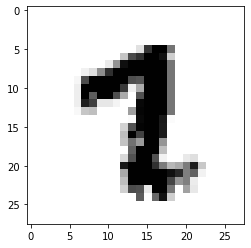



28 [ Predicted Value: 2, Actual Value: 4 ]


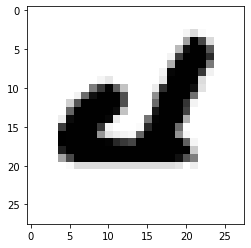



29 [ Predicted Value: 0, Actual Value: 8 ]


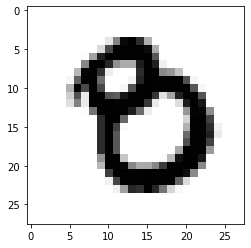



30 [ Predicted Value: 0, Actual Value: 6 ]


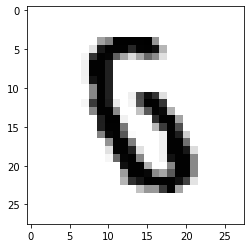



31 [ Predicted Value: 5, Actual Value: 6 ]


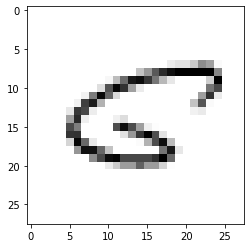



32 [ Predicted Value: 9, Actual Value: 4 ]


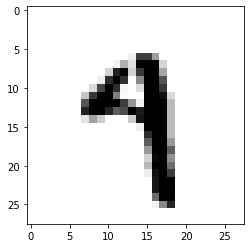



33 [ Predicted Value: 7, Actual Value: 0 ]


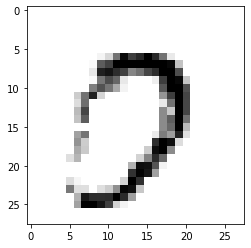



34 [ Predicted Value: 7, Actual Value: 2 ]


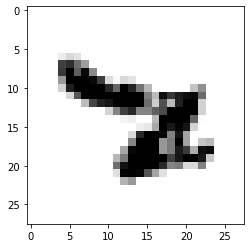



35 [ Predicted Value: 3, Actual Value: 5 ]


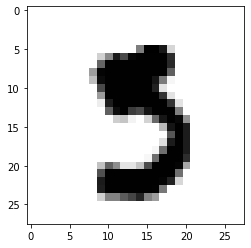



36 [ Predicted Value: 2, Actual Value: 7 ]


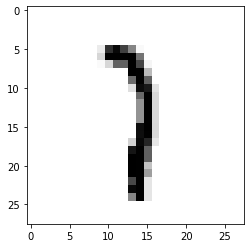



37 [ Predicted Value: 0, Actual Value: 5 ]


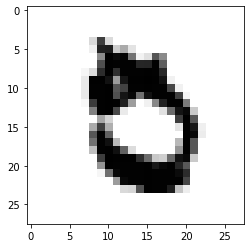



38 [ Predicted Value: 9, Actual Value: 4 ]


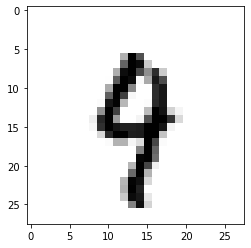



39 [ Predicted Value: 3, Actual Value: 5 ]


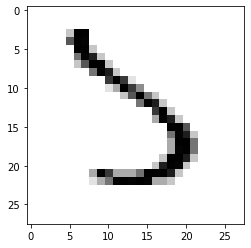



40 [ Predicted Value: 8, Actual Value: 3 ]


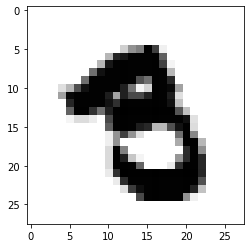



41 [ Predicted Value: 9, Actual Value: 4 ]


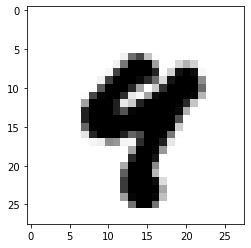



42 [ Predicted Value: 2, Actual Value: 7 ]


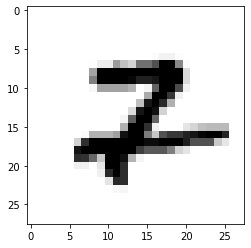



43 [ Predicted Value: 9, Actual Value: 4 ]


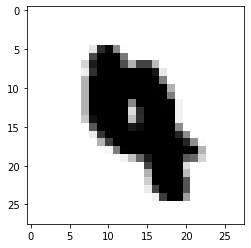



44 [ Predicted Value: 0, Actual Value: 6 ]


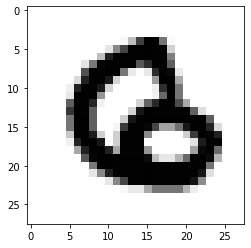



45 [ Predicted Value: 6, Actual Value: 1 ]


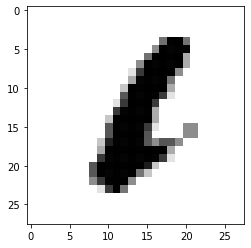



46 [ Predicted Value: 7, Actual Value: 2 ]


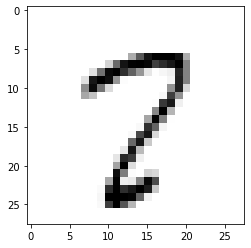



47 [ Predicted Value: 1, Actual Value: 8 ]


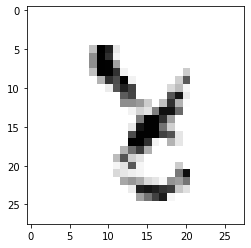



48 [ Predicted Value: 9, Actual Value: 8 ]


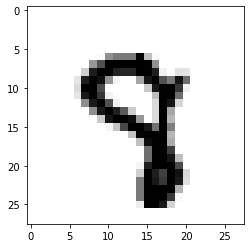



49 [ Predicted Value: 2, Actual Value: 7 ]


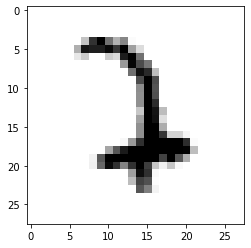



50 [ Predicted Value: 9, Actual Value: 4 ]


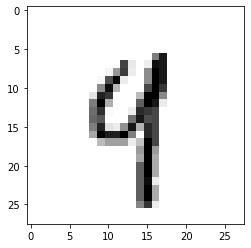



51 [ Predicted Value: 5, Actual Value: 3 ]


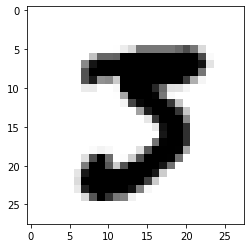



52 [ Predicted Value: 5, Actual Value: 6 ]


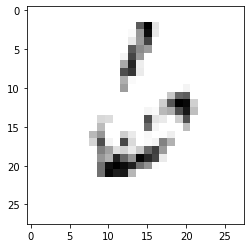



53 [ Predicted Value: 3, Actual Value: 5 ]


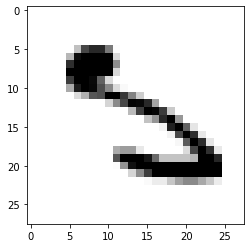



54 [ Predicted Value: 4, Actual Value: 6 ]


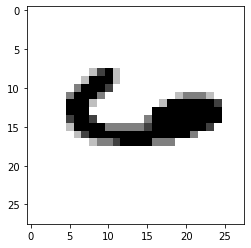



55 [ Predicted Value: 3, Actual Value: 5 ]


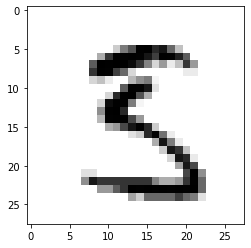



56 [ Predicted Value: 2, Actual Value: 1 ]


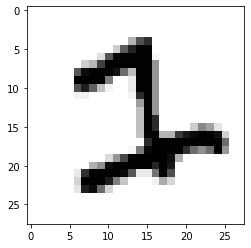



57 [ Predicted Value: 1, Actual Value: 6 ]


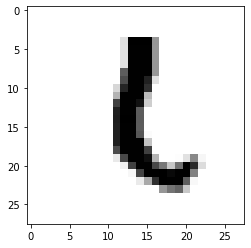



58 [ Predicted Value: 9, Actual Value: 4 ]


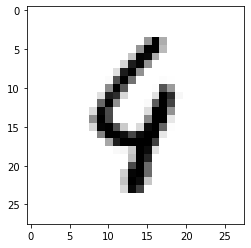



59 [ Predicted Value: 1, Actual Value: 7 ]


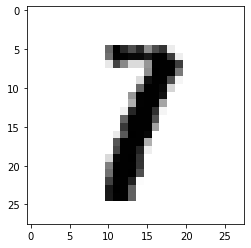



60 [ Predicted Value: 3, Actual Value: 5 ]


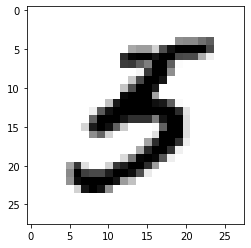



61 [ Predicted Value: 9, Actual Value: 4 ]


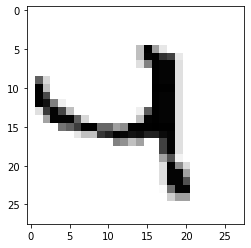



62 [ Predicted Value: 1, Actual Value: 2 ]


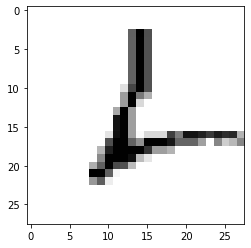



63 [ Predicted Value: 5, Actual Value: 3 ]


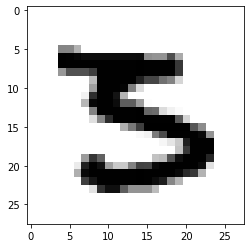



64 [ Predicted Value: 2, Actual Value: 3 ]


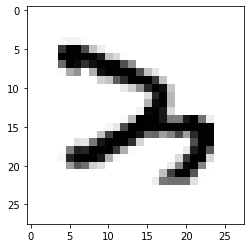

In [26]:
print('\n#########################With L2 Optimisation######################################\n')

train_losses_l2_c, train_acc_l2_c, test_losses_l2_c, test_acc_l2_c = trainModel('_l2', L1_Flag =False, L2_Flag = True, alpha = al )

##With L1 and L2 Optimisations

  0%|          | 0/938 [00:00<?, ?it/s]


################With Both L1 and L2 Optimisations##################################

alpha =  0.005
EPOCH _l1_l2 0


Loss=4.991165637969971 Batch_id=937 Accuracy=91.61: 100%|██████████| 938/938 [00:22<00:00, 41.74it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0731, Accuracy: 9758/10000 (97.58%)

EPOCH _l1_l2 1


Loss=5.671010971069336 Batch_id=937 Accuracy=97.59: 100%|██████████| 938/938 [00:23<00:00, 40.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0439, Accuracy: 9870/10000 (98.70%)

EPOCH _l1_l2 2


Loss=6.306389331817627 Batch_id=937 Accuracy=98.03: 100%|██████████| 938/938 [00:21<00:00, 43.13it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0350, Accuracy: 9886/10000 (98.86%)

EPOCH _l1_l2 3


Loss=6.385663032531738 Batch_id=937 Accuracy=98.30: 100%|██████████| 938/938 [00:22<00:00, 41.27it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Accuracy: 9898/10000 (98.98%)

EPOCH _l1_l2 4


Loss=6.670380592346191 Batch_id=937 Accuracy=98.41: 100%|██████████| 938/938 [00:21<00:00, 43.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0314, Accuracy: 9901/10000 (99.01%)

EPOCH _l1_l2 5


Loss=6.949040412902832 Batch_id=937 Accuracy=98.47: 100%|██████████| 938/938 [00:20<00:00, 44.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9919/10000 (99.19%)

EPOCH _l1_l2 6


Loss=7.196298599243164 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [00:20<00:00, 45.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9911/10000 (99.11%)

EPOCH _l1_l2 7


Loss=7.367598533630371 Batch_id=937 Accuracy=98.62: 100%|██████████| 938/938 [00:20<00:00, 57.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9925/10000 (99.25%)

EPOCH _l1_l2 8


Loss=7.566487789154053 Batch_id=937 Accuracy=98.72: 100%|██████████| 938/938 [00:20<00:00, 46.01it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9912/10000 (99.12%)

EPOCH _l1_l2 9


Loss=7.7884979248046875 Batch_id=937 Accuracy=98.77: 100%|██████████| 938/938 [00:19<00:00, 46.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9932/10000 (99.32%)

EPOCH _l1_l2 10


Loss=8.031938552856445 Batch_id=937 Accuracy=98.80: 100%|██████████| 938/938 [00:20<00:00, 46.68it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9922/10000 (99.22%)

EPOCH _l1_l2 11


Loss=8.077264785766602 Batch_id=937 Accuracy=98.88: 100%|██████████| 938/938 [00:19<00:00, 47.38it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9929/10000 (99.29%)

EPOCH _l1_l2 12


Loss=8.240635871887207 Batch_id=937 Accuracy=98.91: 100%|██████████| 938/938 [00:19<00:00, 47.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9931/10000 (99.31%)

EPOCH _l1_l2 13


Loss=8.373544692993164 Batch_id=937 Accuracy=98.94: 100%|██████████| 938/938 [00:20<00:00, 46.69it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9915/10000 (99.15%)

EPOCH _l1_l2 14


Loss=8.516448974609375 Batch_id=937 Accuracy=98.89: 100%|██████████| 938/938 [00:19<00:00, 52.06it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9932/10000 (99.32%)

EPOCH _l1_l2 15


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9922/10000 (99.22%)

EPOCH _l1_l2 16


Loss=8.777436256408691 Batch_id=937 Accuracy=98.92: 100%|██████████| 938/938 [00:19<00:00, 47.31it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9934/10000 (99.34%)

EPOCH _l1_l2 17


Loss=8.910582542419434 Batch_id=937 Accuracy=98.91: 100%|██████████| 938/938 [00:20<00:00, 46.28it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9929/10000 (99.29%)

EPOCH _l1_l2 18


Loss=9.035894393920898 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [00:20<00:00, 46.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9932/10000 (99.32%)

EPOCH _l1_l2 19


Loss=9.17435073852539 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [00:20<00:00, 46.78it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9933/10000 (99.33%)

EPOCH _l1_l2 20


Loss=9.276728630065918 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:20<00:00, 46.70it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9924/10000 (99.24%)

EPOCH _l1_l2 21


Loss=9.40007209777832 Batch_id=937 Accuracy=98.94: 100%|██████████| 938/938 [00:20<00:00, 46.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9936/10000 (99.36%)

EPOCH _l1_l2 22


Loss=9.526209831237793 Batch_id=937 Accuracy=99.07: 100%|██████████| 938/938 [00:19<00:00, 46.99it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9925/10000 (99.25%)

EPOCH _l1_l2 23


Loss=9.600303649902344 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:19<00:00, 48.24it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9923/10000 (99.23%)

EPOCH _l1_l2 24


Loss=9.69959545135498 Batch_id=937 Accuracy=99.07: 100%|██████████| 938/938 [00:19<00:00, 47.16it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9923/10000 (99.23%)

EPOCH _l1_l2 25


Loss=9.80745792388916 Batch_id=937 Accuracy=99.07: 100%|██████████| 938/938 [00:19<00:00, 47.16it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9933/10000 (99.33%)

EPOCH _l1_l2 26


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9937/10000 (99.37%)

EPOCH _l1_l2 27


Loss=10.002766609191895 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [00:19<00:00, 47.38it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9931/10000 (99.31%)

EPOCH _l1_l2 28


Loss=10.120915412902832 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [00:19<00:00, 46.99it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9938/10000 (99.38%)

EPOCH _l1_l2 29


Loss=10.196446418762207 Batch_id=937 Accuracy=99.09: 100%|██████████| 938/938 [00:19<00:00, 47.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9929/10000 (99.29%)

EPOCH _l1_l2 30


Loss=10.278120040893555 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:19<00:00, 47.40it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9935/10000 (99.35%)

EPOCH _l1_l2 31


Loss=10.369766235351562 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:19<00:00, 48.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9931/10000 (99.31%)

EPOCH _l1_l2 32


Loss=10.47074031829834 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [00:19<00:00, 48.37it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9944/10000 (99.44%)

EPOCH _l1_l2 33


Loss=10.584735870361328 Batch_id=937 Accuracy=99.10: 100%|██████████| 938/938 [00:19<00:00, 48.28it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9942/10000 (99.42%)

EPOCH _l1_l2 34


Loss=10.644986152648926 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [00:19<00:00, 48.20it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9939/10000 (99.39%)

EPOCH _l1_l2 35


Loss=10.80440616607666 Batch_id=937 Accuracy=99.13: 100%|██████████| 938/938 [00:19<00:00, 48.51it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9942/10000 (99.42%)

EPOCH _l1_l2 36


Loss=10.802340507507324 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [00:18<00:00, 50.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9938/10000 (99.38%)

EPOCH _l1_l2 37


Loss=10.981253623962402 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:18<00:00, 49.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9938/10000 (99.38%)

EPOCH _l1_l2 38


Loss=11.043506622314453 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [00:19<00:00, 49.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9938/10000 (99.38%)

EPOCH _l1_l2 39


Loss=11.152289390563965 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [00:18<00:00, 50.45it/s]



Test set: Average loss: 0.0214, Accuracy: 9931/10000 (99.31%)


@@@@@@@@@@@@@MISCLASSIFIED IMAGES@@@@@@@@@@@@@@@@@@@@@@@@@@@



1 [ Predicted Value: 7, Actual Value: 9 ]


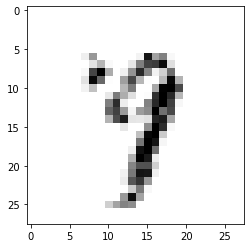



2 [ Predicted Value: 7, Actual Value: 1 ]


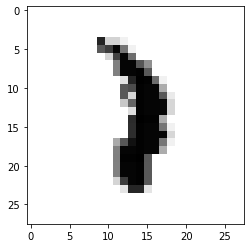



3 [ Predicted Value: 6, Actual Value: 0 ]


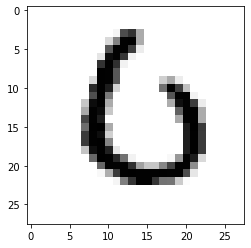



4 [ Predicted Value: 6, Actual Value: 4 ]


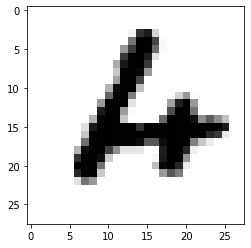



5 [ Predicted Value: 1, Actual Value: 6 ]


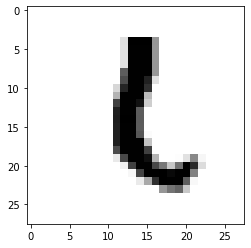



6 [ Predicted Value: 3, Actual Value: 1 ]


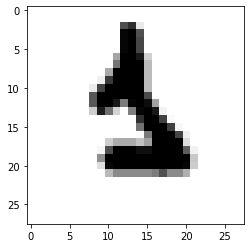



7 [ Predicted Value: 0, Actual Value: 5 ]


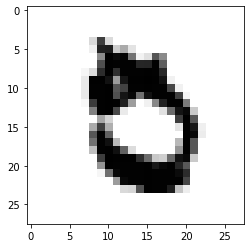



8 [ Predicted Value: 7, Actual Value: 8 ]


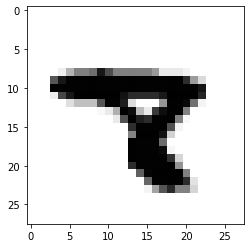



9 [ Predicted Value: 7, Actual Value: 5 ]


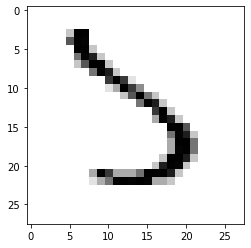



10 [ Predicted Value: 6, Actual Value: 5 ]


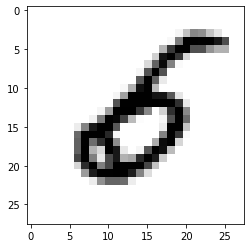



11 [ Predicted Value: 6, Actual Value: 4 ]


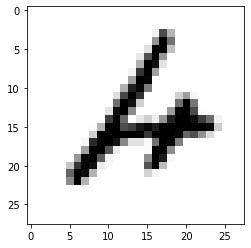



12 [ Predicted Value: 7, Actual Value: 8 ]


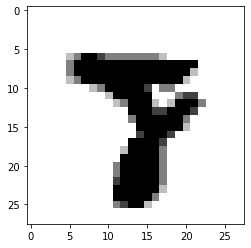



13 [ Predicted Value: 7, Actual Value: 2 ]


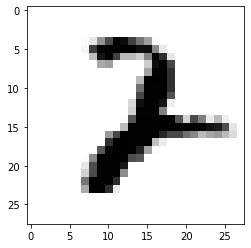



14 [ Predicted Value: 4, Actual Value: 9 ]


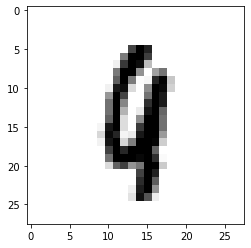



15 [ Predicted Value: 1, Actual Value: 8 ]


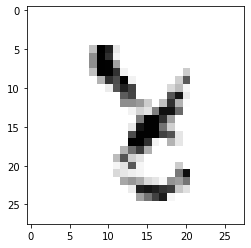



16 [ Predicted Value: 8, Actual Value: 4 ]


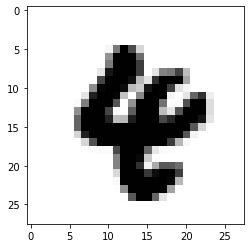



17 [ Predicted Value: 3, Actual Value: 5 ]


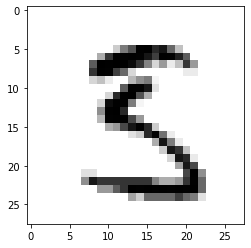



18 [ Predicted Value: 1, Actual Value: 4 ]


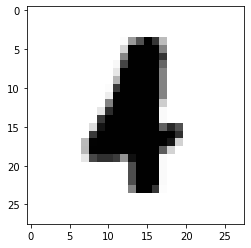



19 [ Predicted Value: 4, Actual Value: 9 ]


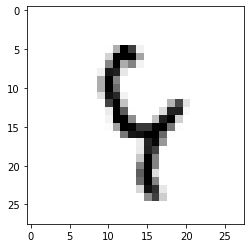



20 [ Predicted Value: 0, Actual Value: 4 ]


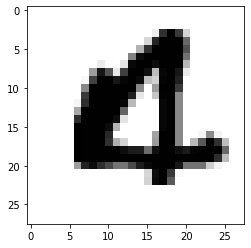



21 [ Predicted Value: 3, Actual Value: 5 ]


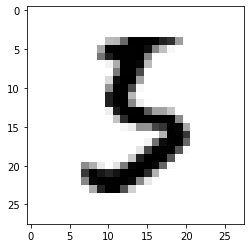



22 [ Predicted Value: 4, Actual Value: 6 ]


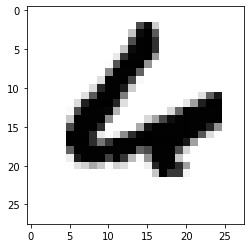



23 [ Predicted Value: 8, Actual Value: 9 ]


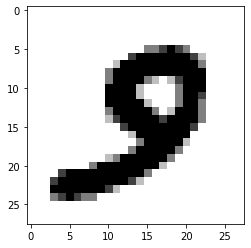



24 [ Predicted Value: 9, Actual Value: 4 ]


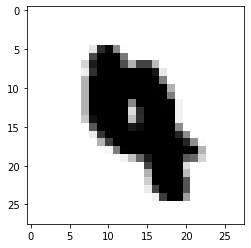



25 [ Predicted Value: 7, Actual Value: 2 ]


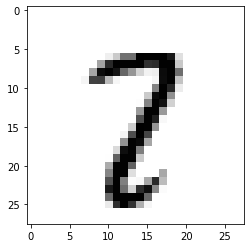



26 [ Predicted Value: 2, Actual Value: 1 ]


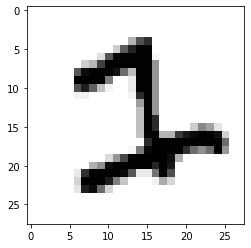



27 [ Predicted Value: 1, Actual Value: 2 ]


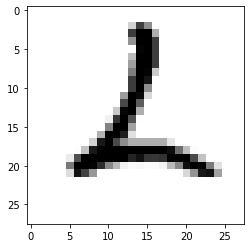



28 [ Predicted Value: 9, Actual Value: 8 ]


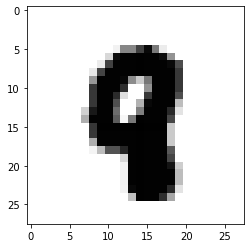



29 [ Predicted Value: 7, Actual Value: 9 ]


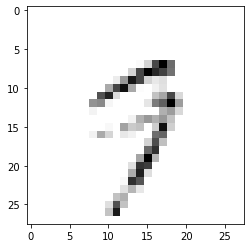



30 [ Predicted Value: 0, Actual Value: 6 ]


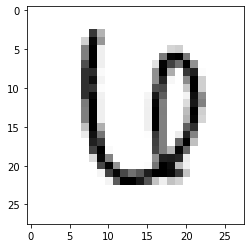



31 [ Predicted Value: 7, Actual Value: 5 ]


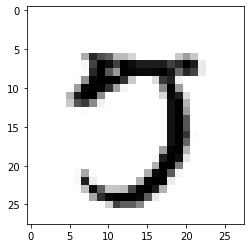



32 [ Predicted Value: 1, Actual Value: 7 ]


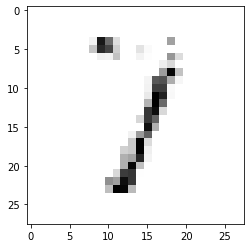



33 [ Predicted Value: 9, Actual Value: 4 ]


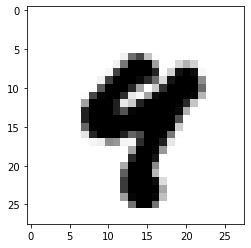



34 [ Predicted Value: 7, Actual Value: 9 ]


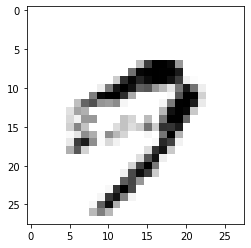



35 [ Predicted Value: 6, Actual Value: 2 ]


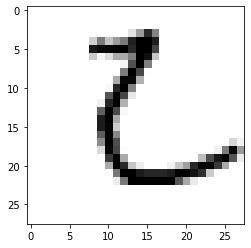



36 [ Predicted Value: 5, Actual Value: 6 ]


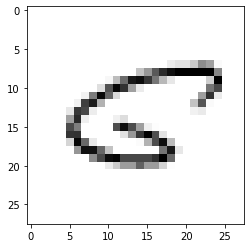



37 [ Predicted Value: 0, Actual Value: 6 ]


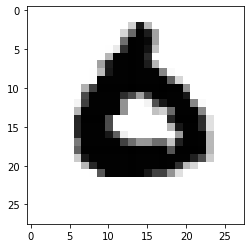



38 [ Predicted Value: 1, Actual Value: 7 ]


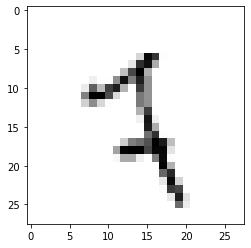



39 [ Predicted Value: 0, Actual Value: 6 ]


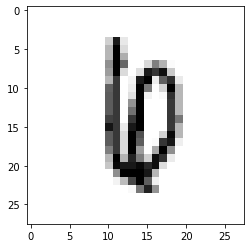



40 [ Predicted Value: 6, Actual Value: 4 ]


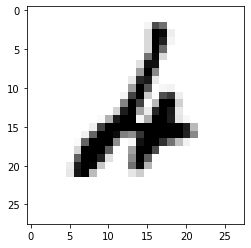



41 [ Predicted Value: 4, Actual Value: 9 ]


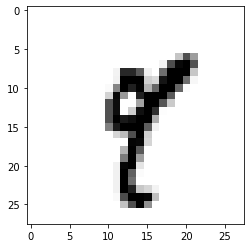



42 [ Predicted Value: 0, Actual Value: 6 ]


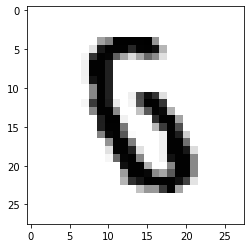



43 [ Predicted Value: 7, Actual Value: 1 ]


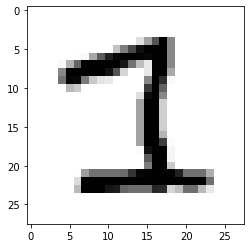



44 [ Predicted Value: 6, Actual Value: 4 ]


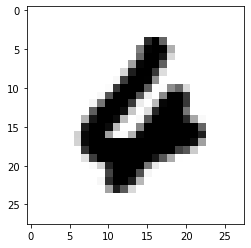



45 [ Predicted Value: 2, Actual Value: 8 ]


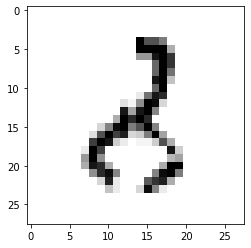



46 [ Predicted Value: 2, Actual Value: 3 ]


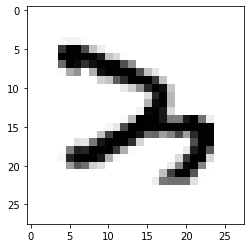



47 [ Predicted Value: 0, Actual Value: 2 ]


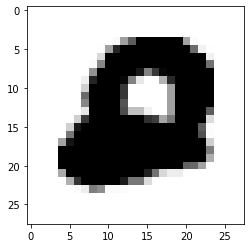



48 [ Predicted Value: 6, Actual Value: 0 ]


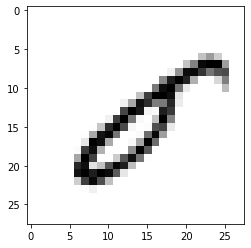



49 [ Predicted Value: 9, Actual Value: 4 ]


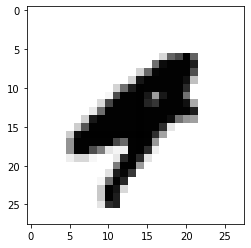



50 [ Predicted Value: 1, Actual Value: 7 ]


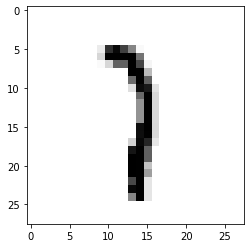



51 [ Predicted Value: 8, Actual Value: 9 ]


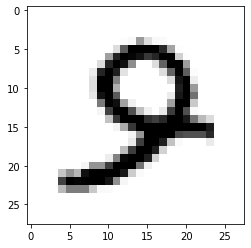



52 [ Predicted Value: 5, Actual Value: 3 ]


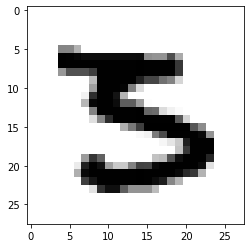



53 [ Predicted Value: 7, Actual Value: 2 ]


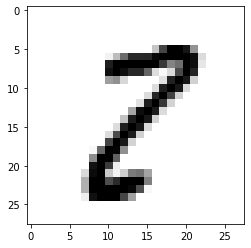



54 [ Predicted Value: 9, Actual Value: 4 ]


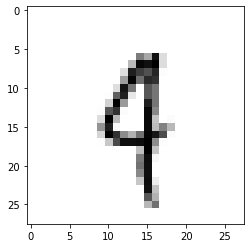



55 [ Predicted Value: 7, Actual Value: 2 ]


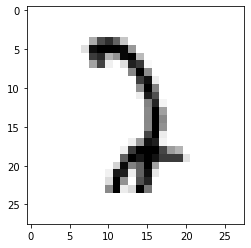



56 [ Predicted Value: 3, Actual Value: 1 ]


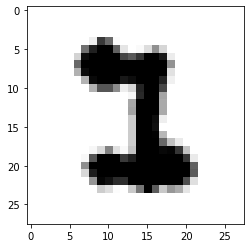



57 [ Predicted Value: 1, Actual Value: 6 ]


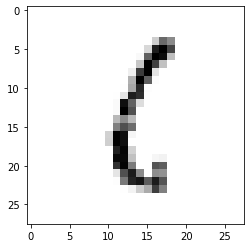



58 [ Predicted Value: 7, Actual Value: 2 ]


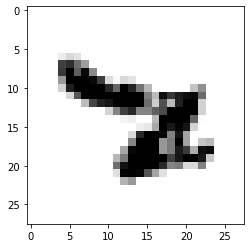



59 [ Predicted Value: 7, Actual Value: 2 ]


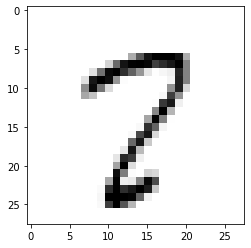



60 [ Predicted Value: 4, Actual Value: 9 ]


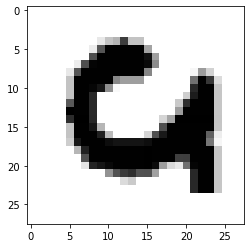



61 [ Predicted Value: 9, Actual Value: 4 ]


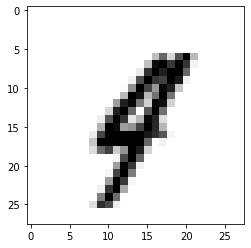



62 [ Predicted Value: 3, Actual Value: 8 ]


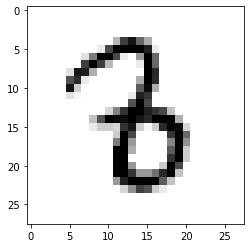



63 [ Predicted Value: 3, Actual Value: 5 ]


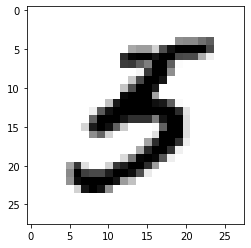



64 [ Predicted Value: 5, Actual Value: 3 ]


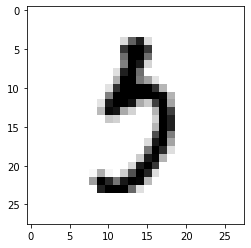



65 [ Predicted Value: 6, Actual Value: 8 ]


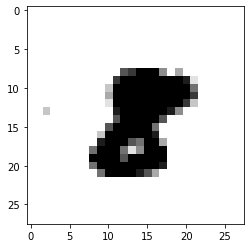



66 [ Predicted Value: 3, Actual Value: 5 ]


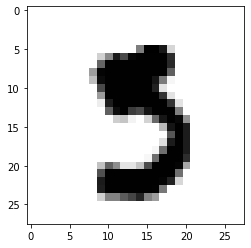



67 [ Predicted Value: 5, Actual Value: 8 ]


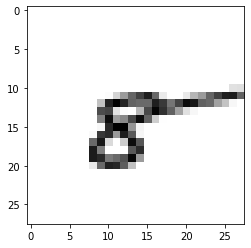



68 [ Predicted Value: 7, Actual Value: 2 ]


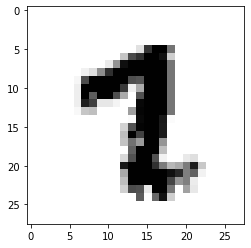



69 [ Predicted Value: 0, Actual Value: 6 ]


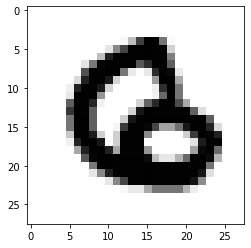

In [27]:
print('\n################With Both L1 and L2 Optimisations##################################\n')

train_losses_l1_l2_c, train_acc_l1_l2_c, test_losses_l1_l2_c, test_acc_l1_l2_c = trainModel('_l1_l2', L1_Flag =True, L2_Flag = True, alpha = al )


##Validation Accuracy and Loss Plots


*****************Test Plots for lambda = 0.005*********************



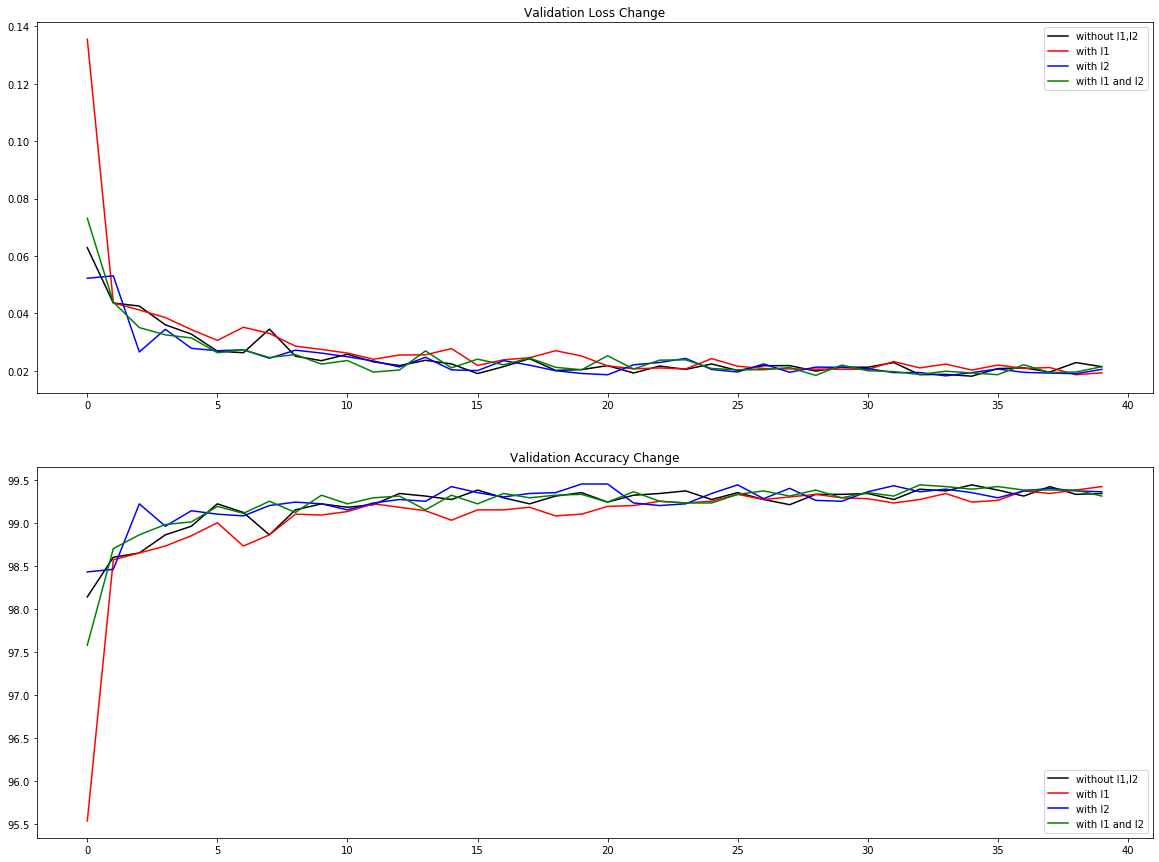

In [28]:
print('\n*****************Test Plots for lambda = {}*********************\n'.format(al))
plotGraphsTest(test_losses_0, test_losses_l1_c, test_losses_l2_c, test_losses_l1_l2_c, test_acc_0, test_acc_l1_c, test_acc_l2_c, test_acc_l1_l2_c)

##Train Accuracy and Loss Plot


*****************Train Plots for lambda = 0.005*********************



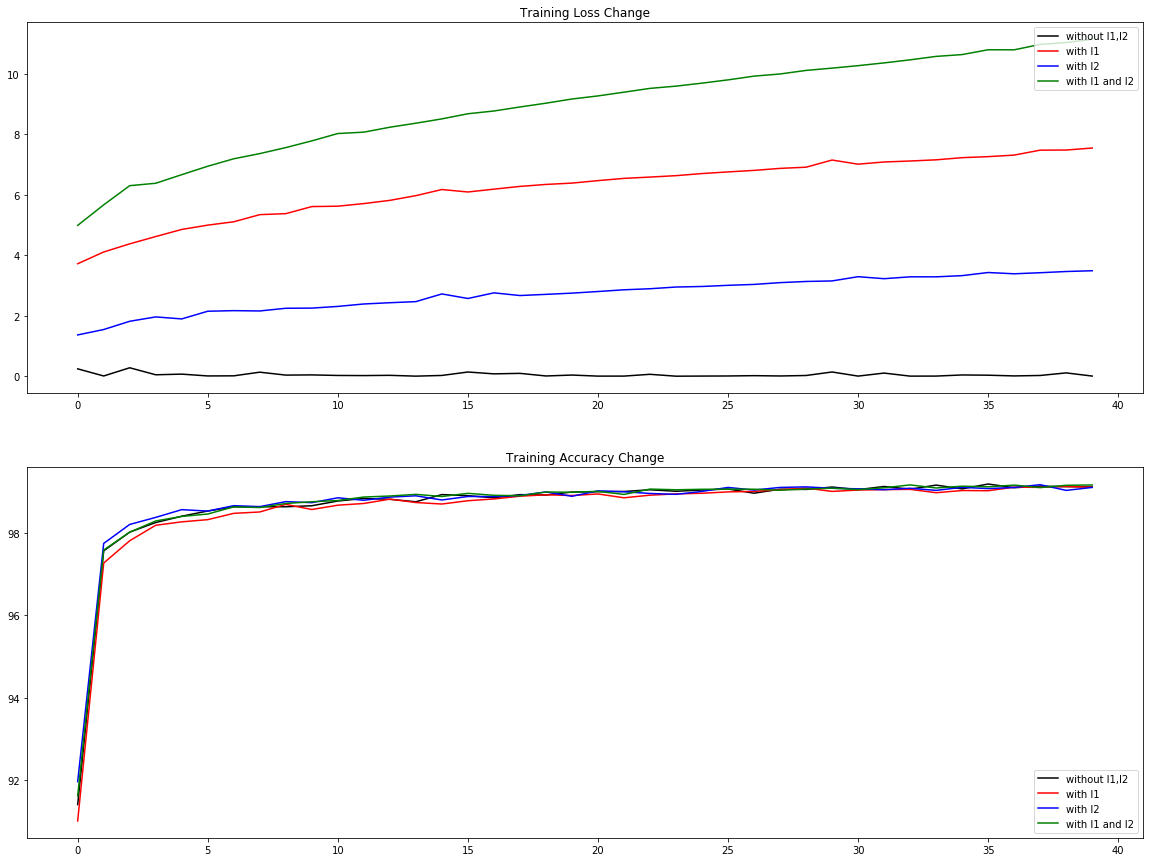

In [29]:
print('\n*****************Train Plots for lambda = {}*********************\n'.format(al))
plotGraphsTrain(train_losses_0, train_losses_l1_c, train_losses_l2_c, train_losses_l1_l2_c, train_acc_0, train_acc_l1_c, train_acc_l2_c, train_acc_l1_l2_c)

#Lambda = 0.05

In [0]:
al = 0.005

##With L1 Optimisation

  0%|          | 0/938 [00:00<?, ?it/s]


#########################With L1 Optimisation######################################

alpha =  0.005
EPOCH _l1 0


Loss=3.7993452548980713 Batch_id=937 Accuracy=90.47: 100%|██████████| 938/938 [00:18<00:00, 51.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1096, Accuracy: 9655/10000 (96.55%)

EPOCH _l1 1


Loss=4.077090263366699 Batch_id=937 Accuracy=97.61: 100%|██████████| 938/938 [00:18<00:00, 49.52it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0471, Accuracy: 9834/10000 (98.34%)

EPOCH _l1 2


Loss=4.3634257316589355 Batch_id=937 Accuracy=98.01: 100%|██████████| 938/938 [00:18<00:00, 51.49it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0393, Accuracy: 9869/10000 (98.69%)

EPOCH _l1 3


Loss=4.6230034828186035 Batch_id=937 Accuracy=98.23: 100%|██████████| 938/938 [00:17<00:00, 52.68it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0378, Accuracy: 9884/10000 (98.84%)

EPOCH _l1 4


Loss=5.078807830810547 Batch_id=937 Accuracy=98.34: 100%|██████████| 938/938 [00:17<00:00, 61.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Accuracy: 9886/10000 (98.86%)

EPOCH _l1 5


Loss=4.96307897567749 Batch_id=937 Accuracy=98.40: 100%|██████████| 938/938 [00:17<00:00, 53.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9903/10000 (99.03%)

EPOCH _l1 6


Loss=5.098850727081299 Batch_id=937 Accuracy=98.57: 100%|██████████| 938/938 [00:17<00:00, 53.67it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9910/10000 (99.10%)

EPOCH _l1 7


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9911/10000 (99.11%)

EPOCH _l1 8


Loss=5.371119499206543 Batch_id=937 Accuracy=98.66: 100%|██████████| 938/938 [00:17<00:00, 53.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9906/10000 (99.06%)

EPOCH _l1 9


Loss=5.511631011962891 Batch_id=937 Accuracy=98.69: 100%|██████████| 938/938 [00:17<00:00, 52.55it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9912/10000 (99.12%)

EPOCH _l1 10


Loss=5.599651336669922 Batch_id=937 Accuracy=98.75: 100%|██████████| 938/938 [00:17<00:00, 53.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9919/10000 (99.19%)

EPOCH _l1 11


Loss=5.719732284545898 Batch_id=937 Accuracy=98.77: 100%|██████████| 938/938 [00:17<00:00, 53.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9923/10000 (99.23%)

EPOCH _l1 12


Loss=5.874973297119141 Batch_id=937 Accuracy=98.77: 100%|██████████| 938/938 [00:17<00:00, 52.70it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9926/10000 (99.26%)

EPOCH _l1 13


Loss=6.018275737762451 Batch_id=937 Accuracy=98.84: 100%|██████████| 938/938 [00:17<00:00, 52.91it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9926/10000 (99.26%)

EPOCH _l1 14


Loss=5.96254825592041 Batch_id=937 Accuracy=98.88: 100%|██████████| 938/938 [00:17<00:00, 52.61it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9921/10000 (99.21%)

EPOCH _l1 15


Loss=6.040997505187988 Batch_id=937 Accuracy=98.94: 100%|██████████| 938/938 [00:18<00:00, 51.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9935/10000 (99.35%)

EPOCH _l1 16


Loss=6.117867469787598 Batch_id=937 Accuracy=98.86: 100%|██████████| 938/938 [00:18<00:00, 56.31it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9933/10000 (99.33%)

EPOCH _l1 17


Loss=6.21502685546875 Batch_id=937 Accuracy=98.89: 100%|██████████| 938/938 [00:18<00:00, 50.66it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9934/10000 (99.34%)

EPOCH _l1 18


Loss=6.274684906005859 Batch_id=937 Accuracy=98.93: 100%|██████████| 938/938 [00:18<00:00, 50.64it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9925/10000 (99.25%)

EPOCH _l1 19


Loss=6.350663185119629 Batch_id=937 Accuracy=98.94: 100%|██████████| 938/938 [00:18<00:00, 50.97it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9930/10000 (99.30%)

EPOCH _l1 20


Loss=6.409925937652588 Batch_id=937 Accuracy=98.94: 100%|██████████| 938/938 [00:18<00:00, 51.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9933/10000 (99.33%)

EPOCH _l1 21


Loss=6.487153053283691 Batch_id=937 Accuracy=98.95: 100%|██████████| 938/938 [00:18<00:00, 51.64it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9932/10000 (99.32%)

EPOCH _l1 22


Loss=6.545558452606201 Batch_id=937 Accuracy=98.97: 100%|██████████| 938/938 [00:17<00:00, 52.64it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9939/10000 (99.39%)

EPOCH _l1 23


Loss=6.608935832977295 Batch_id=937 Accuracy=98.95: 100%|██████████| 938/938 [00:18<00:00, 51.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9938/10000 (99.38%)

EPOCH _l1 24


Loss=6.706869602203369 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [00:18<00:00, 51.37it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9932/10000 (99.32%)

EPOCH _l1 25


Loss=6.816555976867676 Batch_id=937 Accuracy=99.03: 100%|██████████| 938/938 [00:19<00:00, 48.06it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9930/10000 (99.30%)

EPOCH _l1 26


Loss=6.802430629730225 Batch_id=937 Accuracy=99.03: 100%|██████████| 938/938 [00:19<00:00, 48.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9935/10000 (99.35%)

EPOCH _l1 27


Loss=6.835542678833008 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:17<00:00, 52.40it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9927/10000 (99.27%)

EPOCH _l1 28


Loss=7.05936861038208 Batch_id=937 Accuracy=99.07: 100%|██████████| 938/938 [00:17<00:00, 52.12it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9932/10000 (99.32%)

EPOCH _l1 29


Loss=6.951718330383301 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [00:18<00:00, 49.65it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9934/10000 (99.34%)

EPOCH _l1 30


Loss=7.007724761962891 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [00:18<00:00, 49.74it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9942/10000 (99.42%)

EPOCH _l1 31


Loss=7.080197811126709 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [00:19<00:00, 48.95it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9928/10000 (99.28%)

EPOCH _l1 32


Loss=7.107006072998047 Batch_id=937 Accuracy=99.03: 100%|██████████| 938/938 [00:18<00:00, 50.79it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9927/10000 (99.27%)

EPOCH _l1 33


Loss=7.249800205230713 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [00:17<00:00, 52.93it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9939/10000 (99.39%)

EPOCH _l1 34


Loss=7.204243183135986 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [00:17<00:00, 52.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9945/10000 (99.45%)

EPOCH _l1 35


Loss=7.26809024810791 Batch_id=937 Accuracy=99.09: 100%|██████████| 938/938 [00:17<00:00, 53.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9927/10000 (99.27%)

EPOCH _l1 36


Loss=7.364232540130615 Batch_id=937 Accuracy=99.10: 100%|██████████| 938/938 [00:17<00:00, 53.67it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9938/10000 (99.38%)

EPOCH _l1 37


Loss=7.34563684463501 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:17<00:00, 52.70it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9944/10000 (99.44%)

EPOCH _l1 38


Loss=7.38081169128418 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:17<00:00, 53.28it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9929/10000 (99.29%)

EPOCH _l1 39


Loss=7.449098110198975 Batch_id=937 Accuracy=99.15: 100%|██████████| 938/938 [00:17<00:00, 58.73it/s]



Test set: Average loss: 0.0171, Accuracy: 9940/10000 (99.40%)


@@@@@@@@@@@@@MISCLASSIFIED IMAGES@@@@@@@@@@@@@@@@@@@@@@@@@@@



1 [ Predicted Value: 5, Actual Value: 8 ]


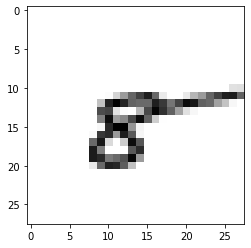



2 [ Predicted Value: 3, Actual Value: 1 ]


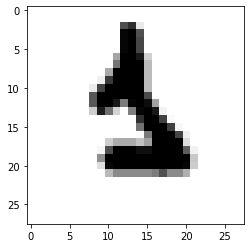



3 [ Predicted Value: 1, Actual Value: 7 ]


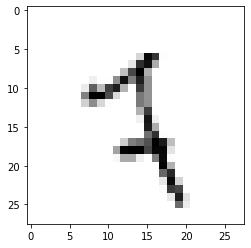



4 [ Predicted Value: 0, Actual Value: 2 ]


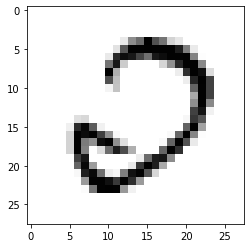



5 [ Predicted Value: 6, Actual Value: 4 ]


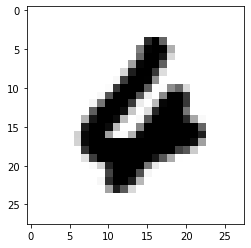



6 [ Predicted Value: 6, Actual Value: 5 ]


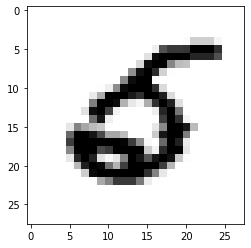



7 [ Predicted Value: 0, Actual Value: 6 ]


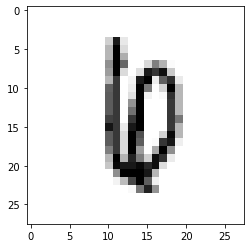



8 [ Predicted Value: 1, Actual Value: 7 ]


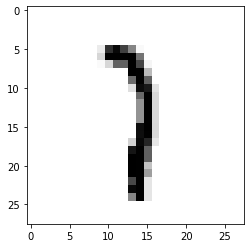



9 [ Predicted Value: 9, Actual Value: 8 ]


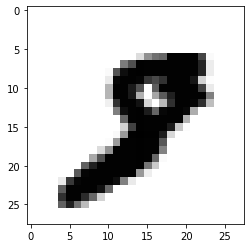



10 [ Predicted Value: 2, Actual Value: 6 ]


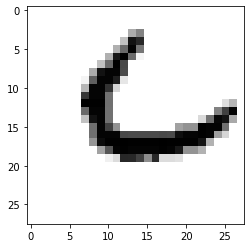



11 [ Predicted Value: 1, Actual Value: 8 ]


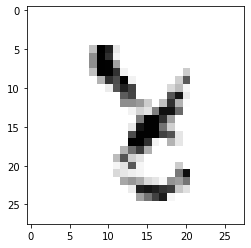



12 [ Predicted Value: 4, Actual Value: 9 ]


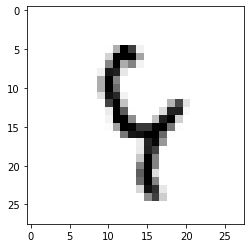



13 [ Predicted Value: 7, Actual Value: 9 ]


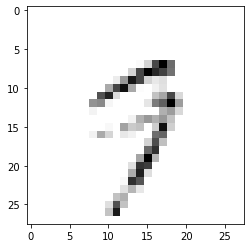



14 [ Predicted Value: 1, Actual Value: 6 ]


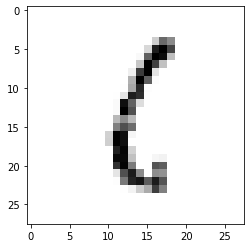



15 [ Predicted Value: 1, Actual Value: 6 ]


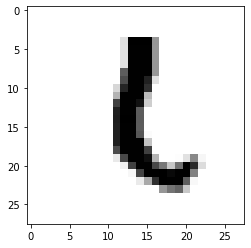



16 [ Predicted Value: 4, Actual Value: 9 ]


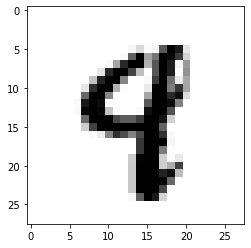



17 [ Predicted Value: 1, Actual Value: 2 ]


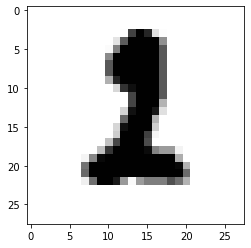



18 [ Predicted Value: 4, Actual Value: 7 ]


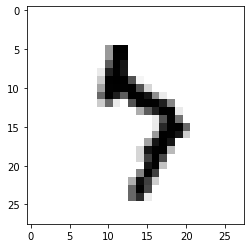



19 [ Predicted Value: 7, Actual Value: 2 ]


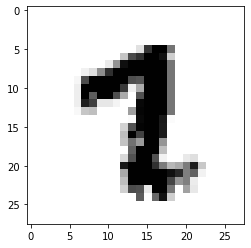



20 [ Predicted Value: 2, Actual Value: 6 ]


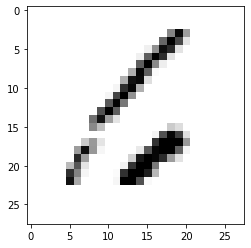



21 [ Predicted Value: 3, Actual Value: 2 ]


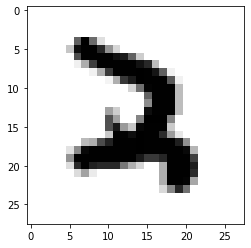



22 [ Predicted Value: 9, Actual Value: 4 ]


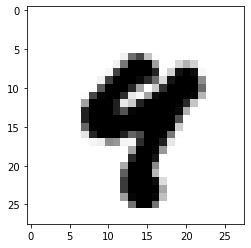



23 [ Predicted Value: 4, Actual Value: 6 ]


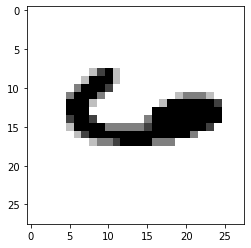



24 [ Predicted Value: 4, Actual Value: 9 ]


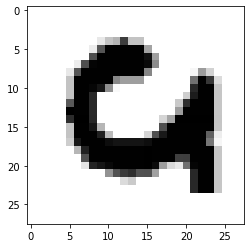



25 [ Predicted Value: 6, Actual Value: 5 ]


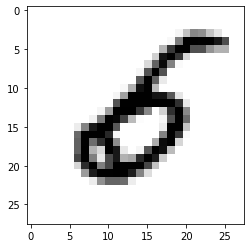



26 [ Predicted Value: 1, Actual Value: 6 ]


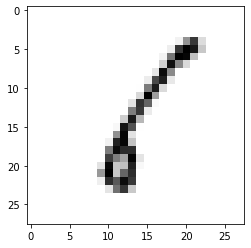



27 [ Predicted Value: 5, Actual Value: 3 ]


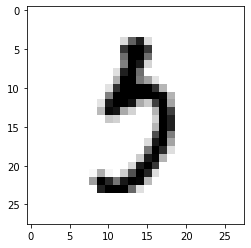



28 [ Predicted Value: 1, Actual Value: 7 ]


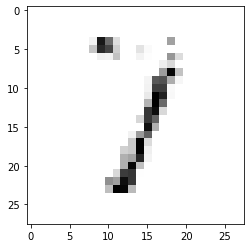



29 [ Predicted Value: 2, Actual Value: 7 ]


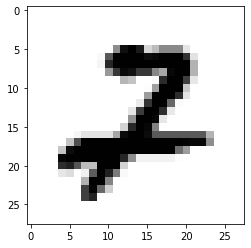



30 [ Predicted Value: 0, Actual Value: 6 ]


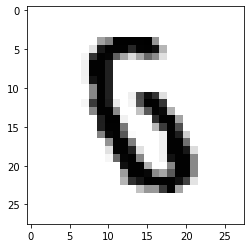



31 [ Predicted Value: 7, Actual Value: 9 ]


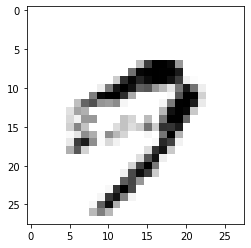



32 [ Predicted Value: 2, Actual Value: 8 ]


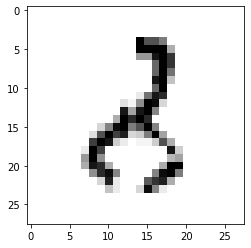



33 [ Predicted Value: 3, Actual Value: 5 ]


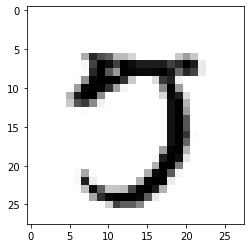



34 [ Predicted Value: 7, Actual Value: 0 ]


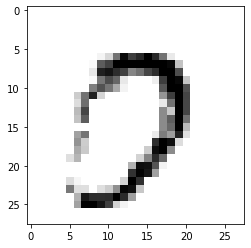



35 [ Predicted Value: 7, Actual Value: 2 ]


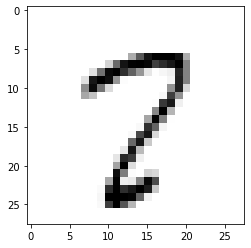



36 [ Predicted Value: 2, Actual Value: 7 ]


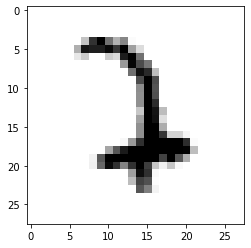



37 [ Predicted Value: 7, Actual Value: 2 ]


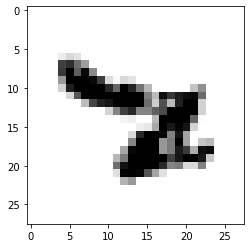



38 [ Predicted Value: 2, Actual Value: 7 ]


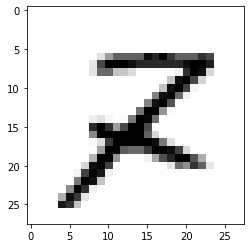



39 [ Predicted Value: 2, Actual Value: 6 ]


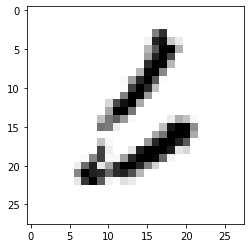



40 [ Predicted Value: 0, Actual Value: 8 ]


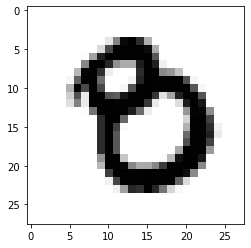



41 [ Predicted Value: 3, Actual Value: 5 ]


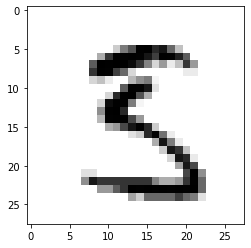



42 [ Predicted Value: 4, Actual Value: 9 ]


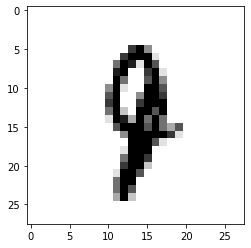



43 [ Predicted Value: 0, Actual Value: 6 ]


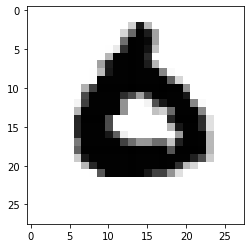



44 [ Predicted Value: 7, Actual Value: 2 ]


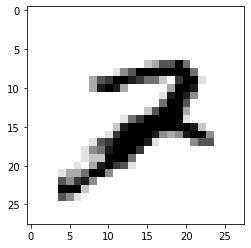



45 [ Predicted Value: 7, Actual Value: 2 ]


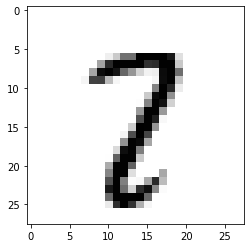



46 [ Predicted Value: 0, Actual Value: 6 ]


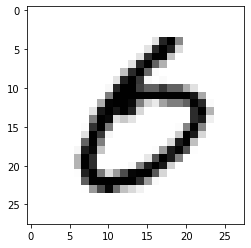



47 [ Predicted Value: 1, Actual Value: 9 ]


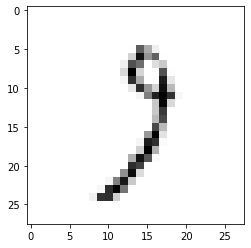



48 [ Predicted Value: 0, Actual Value: 2 ]


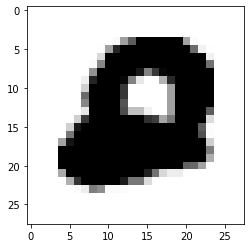



49 [ Predicted Value: 3, Actual Value: 8 ]


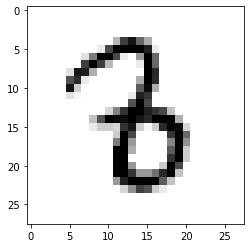



50 [ Predicted Value: 4, Actual Value: 9 ]


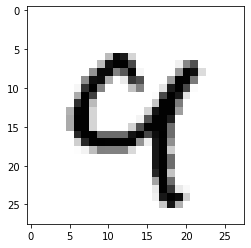



51 [ Predicted Value: 9, Actual Value: 8 ]


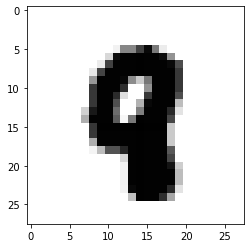



52 [ Predicted Value: 6, Actual Value: 5 ]


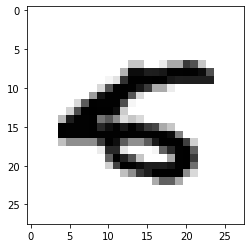



53 [ Predicted Value: 3, Actual Value: 5 ]


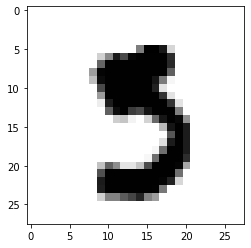



54 [ Predicted Value: 9, Actual Value: 4 ]


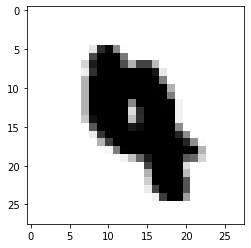



55 [ Predicted Value: 3, Actual Value: 5 ]


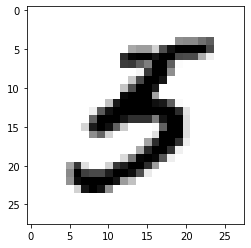



56 [ Predicted Value: 7, Actual Value: 9 ]


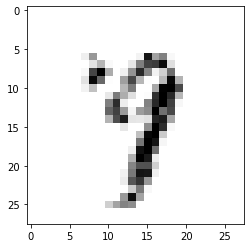



57 [ Predicted Value: 4, Actual Value: 9 ]


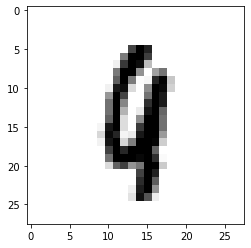



58 [ Predicted Value: 7, Actual Value: 1 ]


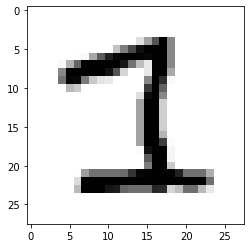



59 [ Predicted Value: 4, Actual Value: 9 ]


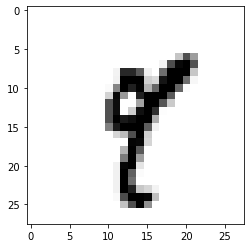



60 [ Predicted Value: 7, Actual Value: 1 ]


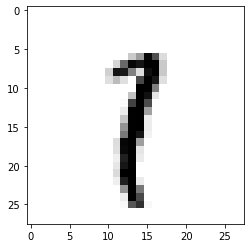

In [31]:
print('\n#########################With L1 Optimisation######################################\n')

train_losses_l1_d, train_acc_l1_d, test_losses_l1_d, test_acc_l1_d = trainModel('_l1', L1_Flag =True, L2_Flag = False, alpha = al )

##With L2 Optimisation

  0%|          | 0/938 [00:00<?, ?it/s]


#########################With L2 Optimisation######################################

alpha =  0.005
EPOCH _l2 0


Loss=1.361905574798584 Batch_id=937 Accuracy=90.37: 100%|██████████| 938/938 [00:19<00:00, 49.08it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0527, Accuracy: 9843/10000 (98.43%)

EPOCH _l2 1


Loss=1.5466437339782715 Batch_id=937 Accuracy=97.53: 100%|██████████| 938/938 [00:19<00:00, 49.03it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0407, Accuracy: 9872/10000 (98.72%)

EPOCH _l2 2


Loss=1.6938872337341309 Batch_id=937 Accuracy=98.05: 100%|██████████| 938/938 [00:20<00:00, 46.82it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9900/10000 (99.00%)

EPOCH _l2 3


Loss=1.8602094650268555 Batch_id=937 Accuracy=98.23: 100%|██████████| 938/938 [00:18<00:00, 49.62it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9913/10000 (99.13%)

EPOCH _l2 4


Loss=1.9208072423934937 Batch_id=937 Accuracy=98.40: 100%|██████████| 938/938 [00:19<00:00, 48.69it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9933/10000 (99.33%)

EPOCH _l2 5


Loss=2.007779121398926 Batch_id=937 Accuracy=98.55: 100%|██████████| 938/938 [00:19<00:00, 49.23it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9925/10000 (99.25%)

EPOCH _l2 6


Loss=2.137498378753662 Batch_id=937 Accuracy=98.51: 100%|██████████| 938/938 [00:18<00:00, 50.20it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9926/10000 (99.26%)

EPOCH _l2 7


Loss=2.171992301940918 Batch_id=937 Accuracy=98.59: 100%|██████████| 938/938 [00:18<00:00, 49.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9922/10000 (99.22%)

EPOCH _l2 8


Loss=2.3151495456695557 Batch_id=937 Accuracy=98.67: 100%|██████████| 938/938 [00:19<00:00, 48.98it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9920/10000 (99.20%)

EPOCH _l2 9


Loss=2.296978712081909 Batch_id=937 Accuracy=98.75: 100%|██████████| 938/938 [00:17<00:00, 53.27it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9929/10000 (99.29%)

EPOCH _l2 10


Loss=2.368961811065674 Batch_id=937 Accuracy=98.75: 100%|██████████| 938/938 [00:16<00:00, 55.24it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9938/10000 (99.38%)

EPOCH _l2 11


Loss=2.4980359077453613 Batch_id=937 Accuracy=98.76: 100%|██████████| 938/938 [00:17<00:00, 54.08it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9931/10000 (99.31%)

EPOCH _l2 12


Loss=2.536606550216675 Batch_id=937 Accuracy=98.79: 100%|██████████| 938/938 [00:17<00:00, 54.48it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9939/10000 (99.39%)

EPOCH _l2 13


Loss=2.628098726272583 Batch_id=937 Accuracy=98.81: 100%|██████████| 938/938 [00:17<00:00, 54.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9930/10000 (99.30%)

EPOCH _l2 14


Loss=2.6293787956237793 Batch_id=937 Accuracy=98.83: 100%|██████████| 938/938 [00:17<00:00, 54.63it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9944/10000 (99.44%)

EPOCH _l2 15


Loss=2.76810359954834 Batch_id=937 Accuracy=98.91: 100%|██████████| 938/938 [00:17<00:00, 54.81it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9933/10000 (99.33%)

EPOCH _l2 16


Loss=2.69997239112854 Batch_id=937 Accuracy=98.89: 100%|██████████| 938/938 [00:17<00:00, 54.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9932/10000 (99.32%)

EPOCH _l2 17


Loss=2.777484655380249 Batch_id=937 Accuracy=98.91: 100%|██████████| 938/938 [00:16<00:00, 55.89it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9937/10000 (99.37%)

EPOCH _l2 18


Loss=2.858919382095337 Batch_id=937 Accuracy=98.86: 100%|██████████| 938/938 [00:17<00:00, 55.17it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9945/10000 (99.45%)

EPOCH _l2 19


Loss=2.8407177925109863 Batch_id=937 Accuracy=98.90: 100%|██████████| 938/938 [00:17<00:00, 54.89it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9929/10000 (99.29%)

EPOCH _l2 20


Loss=2.888547897338867 Batch_id=937 Accuracy=98.99: 100%|██████████| 938/938 [00:16<00:00, 56.13it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 9943/10000 (99.43%)

EPOCH _l2 21


Loss=2.989168167114258 Batch_id=937 Accuracy=98.97: 100%|██████████| 938/938 [00:17<00:00, 54.90it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9942/10000 (99.42%)

EPOCH _l2 22


Loss=3.064192771911621 Batch_id=937 Accuracy=99.01: 100%|██████████| 938/938 [00:16<00:00, 55.28it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9939/10000 (99.39%)

EPOCH _l2 23


Loss=3.0230679512023926 Batch_id=937 Accuracy=98.97: 100%|██████████| 938/938 [00:16<00:00, 55.36it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9943/10000 (99.43%)

EPOCH _l2 24


Loss=3.06221079826355 Batch_id=937 Accuracy=99.01: 100%|██████████| 938/938 [00:17<00:00, 54.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9940/10000 (99.40%)

EPOCH _l2 25


Loss=3.1017043590545654 Batch_id=937 Accuracy=98.95: 100%|██████████| 938/938 [00:16<00:00, 62.57it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0154, Accuracy: 9949/10000 (99.49%)

EPOCH _l2 26


Loss=3.137681484222412 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [00:16<00:00, 55.99it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9934/10000 (99.34%)

EPOCH _l2 27


Loss=3.531400442123413 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:17<00:00, 54.69it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9944/10000 (99.44%)

EPOCH _l2 28


Loss=3.2214767932891846 Batch_id=937 Accuracy=99.03: 100%|██████████| 938/938 [00:16<00:00, 56.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9950/10000 (99.50%)

EPOCH _l2 29


Loss=3.2584240436553955 Batch_id=937 Accuracy=99.09: 100%|██████████| 938/938 [00:16<00:00, 55.18it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9946/10000 (99.46%)

EPOCH _l2 30


Loss=3.364023208618164 Batch_id=937 Accuracy=99.07: 100%|██████████| 938/938 [00:16<00:00, 55.49it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0154, Accuracy: 9951/10000 (99.51%)

EPOCH _l2 31


Loss=3.352102518081665 Batch_id=937 Accuracy=99.07: 100%|██████████| 938/938 [00:16<00:00, 55.81it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9940/10000 (99.40%)

EPOCH _l2 32


Loss=3.368194103240967 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [00:17<00:00, 54.04it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Accuracy: 9945/10000 (99.45%)

EPOCH _l2 33


Loss=3.4558005332946777 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:16<00:00, 56.06it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9945/10000 (99.45%)

EPOCH _l2 34


Loss=3.4959328174591064 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:17<00:00, 55.13it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9946/10000 (99.46%)

EPOCH _l2 35


Loss=3.4812419414520264 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:16<00:00, 55.77it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0151, Accuracy: 9951/10000 (99.51%)

EPOCH _l2 36


Loss=3.526775360107422 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:16<00:00, 55.53it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9945/10000 (99.45%)

EPOCH _l2 37


Loss=3.549043655395508 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:16<00:00, 55.41it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0148, Accuracy: 9948/10000 (99.48%)

EPOCH _l2 38


Loss=3.658892869949341 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [00:16<00:00, 55.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 9945/10000 (99.45%)

EPOCH _l2 39


Loss=3.6258134841918945 Batch_id=937 Accuracy=99.13: 100%|██████████| 938/938 [00:16<00:00, 56.04it/s]



Test set: Average loss: 0.0151, Accuracy: 9948/10000 (99.48%)


@@@@@@@@@@@@@MISCLASSIFIED IMAGES@@@@@@@@@@@@@@@@@@@@@@@@@@@



1 [ Predicted Value: 0, Actual Value: 6 ]


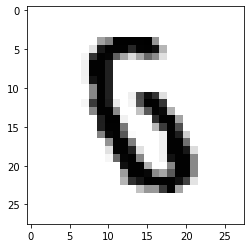



2 [ Predicted Value: 8, Actual Value: 6 ]


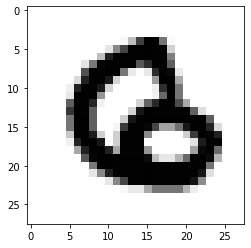



3 [ Predicted Value: 9, Actual Value: 4 ]


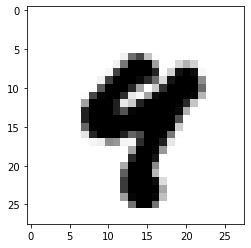



4 [ Predicted Value: 5, Actual Value: 6 ]


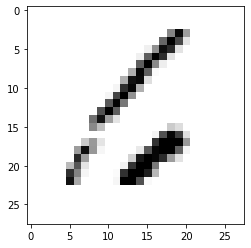



5 [ Predicted Value: 9, Actual Value: 4 ]


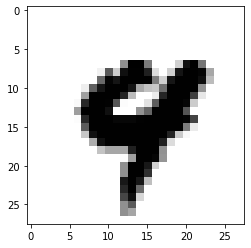



6 [ Predicted Value: 3, Actual Value: 5 ]


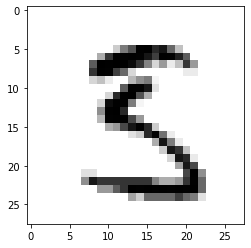



7 [ Predicted Value: 7, Actual Value: 2 ]


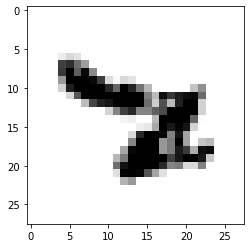



8 [ Predicted Value: 4, Actual Value: 9 ]


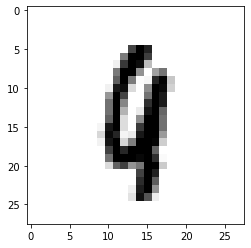



9 [ Predicted Value: 6, Actual Value: 1 ]


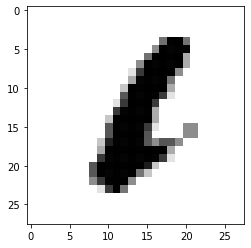



10 [ Predicted Value: 1, Actual Value: 6 ]


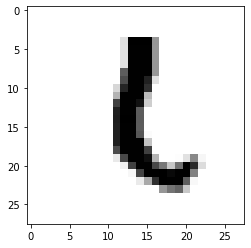



11 [ Predicted Value: 1, Actual Value: 7 ]


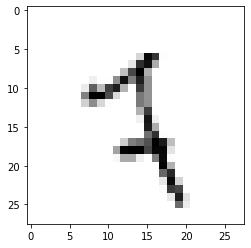



12 [ Predicted Value: 2, Actual Value: 8 ]


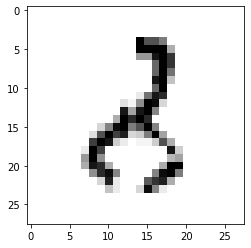



13 [ Predicted Value: 3, Actual Value: 5 ]


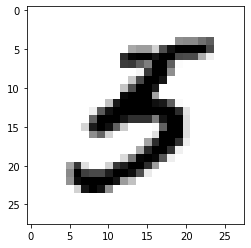



14 [ Predicted Value: 5, Actual Value: 8 ]


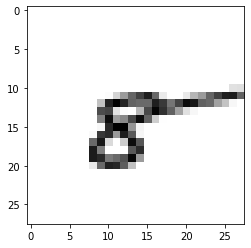



15 [ Predicted Value: 2, Actual Value: 1 ]


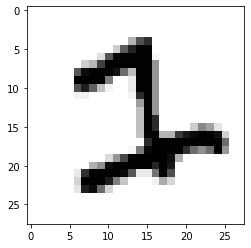



16 [ Predicted Value: 9, Actual Value: 4 ]


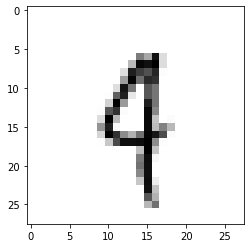



17 [ Predicted Value: 5, Actual Value: 9 ]


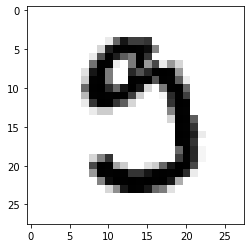



18 [ Predicted Value: 0, Actual Value: 6 ]


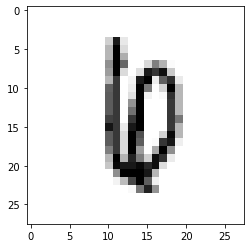



19 [ Predicted Value: 8, Actual Value: 3 ]


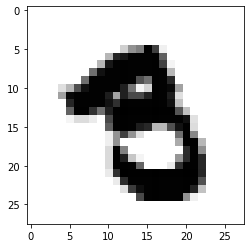



20 [ Predicted Value: 4, Actual Value: 9 ]


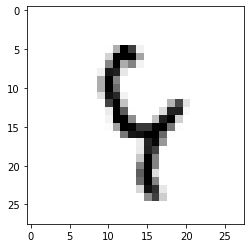



21 [ Predicted Value: 7, Actual Value: 2 ]


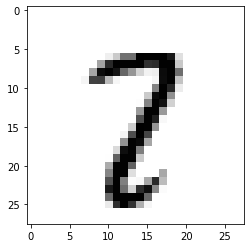



22 [ Predicted Value: 9, Actual Value: 4 ]


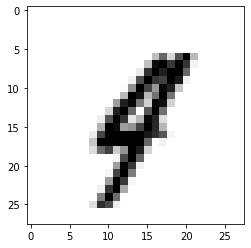



23 [ Predicted Value: 1, Actual Value: 6 ]


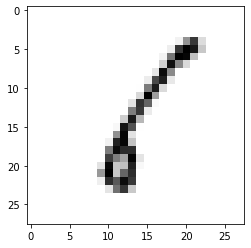



24 [ Predicted Value: 9, Actual Value: 4 ]


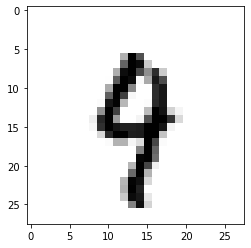



25 [ Predicted Value: 0, Actual Value: 2 ]


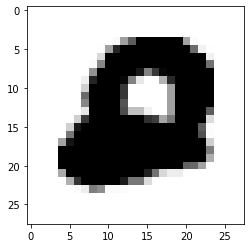



26 [ Predicted Value: 2, Actual Value: 6 ]


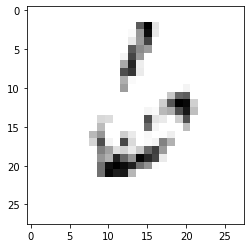



27 [ Predicted Value: 0, Actual Value: 5 ]


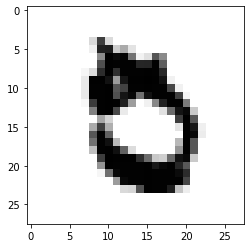



28 [ Predicted Value: 3, Actual Value: 5 ]


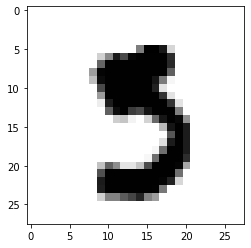



29 [ Predicted Value: 5, Actual Value: 6 ]


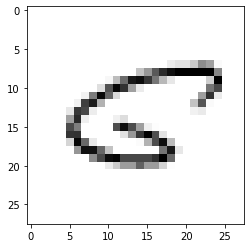



30 [ Predicted Value: 3, Actual Value: 2 ]


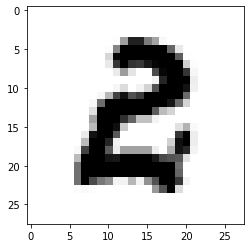



31 [ Predicted Value: 0, Actual Value: 6 ]


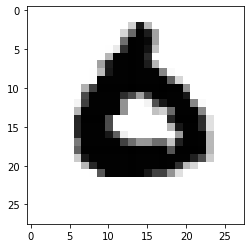



32 [ Predicted Value: 2, Actual Value: 7 ]


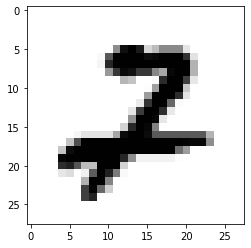



33 [ Predicted Value: 6, Actual Value: 5 ]


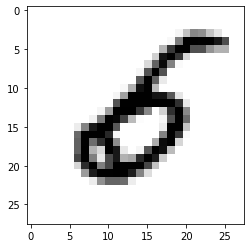



34 [ Predicted Value: 7, Actual Value: 2 ]


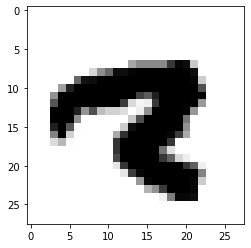



35 [ Predicted Value: 5, Actual Value: 3 ]


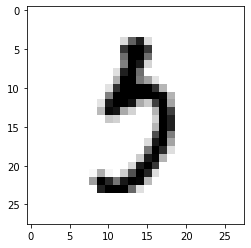



36 [ Predicted Value: 9, Actual Value: 4 ]


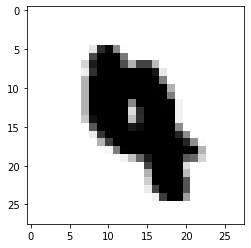



37 [ Predicted Value: 0, Actual Value: 6 ]


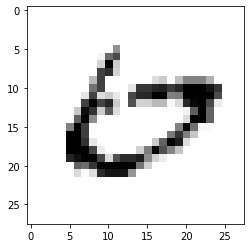



38 [ Predicted Value: 7, Actual Value: 2 ]


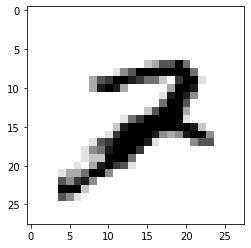



39 [ Predicted Value: 1, Actual Value: 7 ]


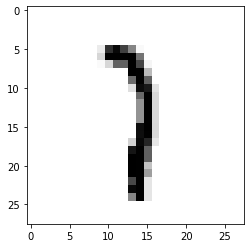



40 [ Predicted Value: 9, Actual Value: 8 ]


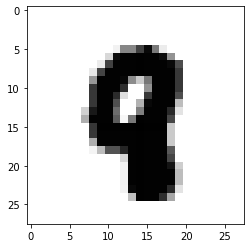



41 [ Predicted Value: 5, Actual Value: 3 ]


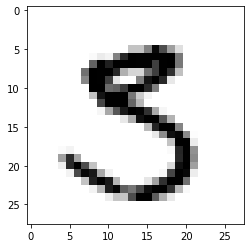



42 [ Predicted Value: 2, Actual Value: 7 ]


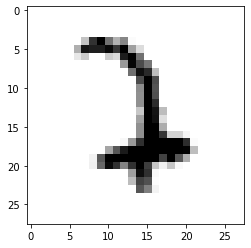



43 [ Predicted Value: 0, Actual Value: 6 ]


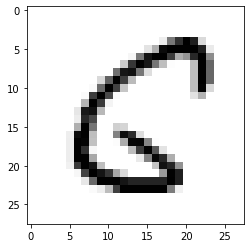



44 [ Predicted Value: 7, Actual Value: 2 ]


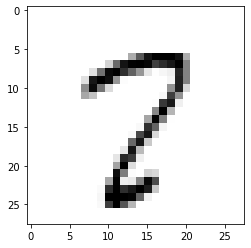



45 [ Predicted Value: 3, Actual Value: 8 ]


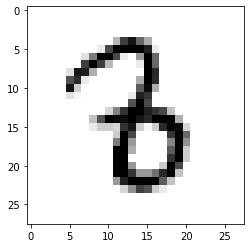



46 [ Predicted Value: 9, Actual Value: 4 ]


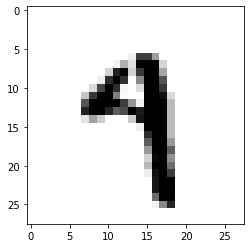



47 [ Predicted Value: 7, Actual Value: 0 ]


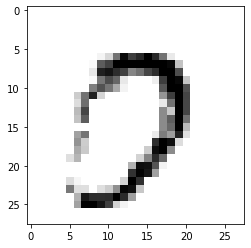



48 [ Predicted Value: 1, Actual Value: 7 ]


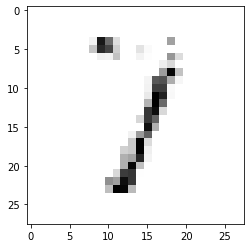



49 [ Predicted Value: 2, Actual Value: 7 ]


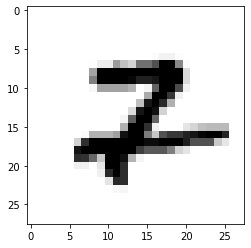



50 [ Predicted Value: 2, Actual Value: 3 ]


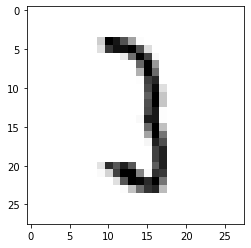



51 [ Predicted Value: 2, Actual Value: 7 ]


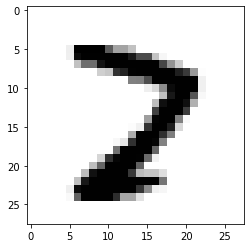



52 [ Predicted Value: 9, Actual Value: 4 ]


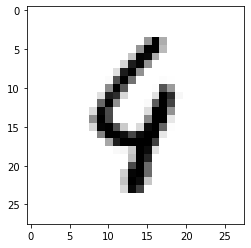

In [32]:
print('\n#########################With L2 Optimisation######################################\n')

train_losses_l2_d, train_acc_l2_d, test_losses_l2_d, test_acc_l2_d = trainModel('_l2', L1_Flag =False, L2_Flag = True, alpha = al )

##With L1 and L2 Optimisations

  0%|          | 0/938 [00:00<?, ?it/s]


################With Both L1 and L2 Optimisations##################################

alpha =  0.005
EPOCH _l1_l2 0


Loss=5.131369113922119 Batch_id=937 Accuracy=90.40: 100%|██████████| 938/938 [00:18<00:00, 50.92it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0678, Accuracy: 9792/10000 (97.92%)

EPOCH _l1_l2 1


Loss=5.676629543304443 Batch_id=937 Accuracy=97.36: 100%|██████████| 938/938 [00:17<00:00, 54.05it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0473, Accuracy: 9851/10000 (98.51%)

EPOCH _l1_l2 2


Loss=6.137932777404785 Batch_id=937 Accuracy=98.05: 100%|██████████| 938/938 [00:17<00:00, 53.04it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0431, Accuracy: 9858/10000 (98.58%)

EPOCH _l1_l2 3


Loss=6.505096435546875 Batch_id=937 Accuracy=98.14: 100%|██████████| 938/938 [00:17<00:00, 53.38it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0327, Accuracy: 9900/10000 (99.00%)

EPOCH _l1_l2 4


Loss=6.743564605712891 Batch_id=937 Accuracy=98.36: 100%|██████████| 938/938 [00:17<00:00, 53.82it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9906/10000 (99.06%)

EPOCH _l1_l2 5


Loss=6.994184970855713 Batch_id=937 Accuracy=98.52: 100%|██████████| 938/938 [00:17<00:00, 52.38it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9906/10000 (99.06%)

EPOCH _l1_l2 6


Loss=7.225126266479492 Batch_id=937 Accuracy=98.55: 100%|██████████| 938/938 [00:17<00:00, 53.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9910/10000 (99.10%)

EPOCH _l1_l2 7


Loss=7.437201023101807 Batch_id=937 Accuracy=98.57: 100%|██████████| 938/938 [00:17<00:00, 54.03it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9892/10000 (98.92%)

EPOCH _l1_l2 8


Loss=7.634316921234131 Batch_id=937 Accuracy=98.62: 100%|██████████| 938/938 [00:17<00:00, 53.28it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Accuracy: 9894/10000 (98.94%)

EPOCH _l1_l2 9


Loss=7.832716464996338 Batch_id=937 Accuracy=98.67: 100%|██████████| 938/938 [00:17<00:00, 53.51it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9911/10000 (99.11%)

EPOCH _l1_l2 10


Loss=7.998312950134277 Batch_id=937 Accuracy=98.75: 100%|██████████| 938/938 [00:17<00:00, 54.18it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9923/10000 (99.23%)

EPOCH _l1_l2 11


Loss=8.147146224975586 Batch_id=937 Accuracy=98.82: 100%|██████████| 938/938 [00:17<00:00, 63.25it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9917/10000 (99.17%)

EPOCH _l1_l2 12


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9903/10000 (99.03%)

EPOCH _l1_l2 13


Loss=8.444716453552246 Batch_id=937 Accuracy=98.79: 100%|██████████| 938/938 [00:17<00:00, 53.89it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9930/10000 (99.30%)

EPOCH _l1_l2 14


Loss=8.582771301269531 Batch_id=937 Accuracy=98.87: 100%|██████████| 938/938 [00:17<00:00, 63.28it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9935/10000 (99.35%)

EPOCH _l1_l2 15


Loss=8.694098472595215 Batch_id=937 Accuracy=98.93: 100%|██████████| 938/938 [00:17<00:00, 53.48it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9942/10000 (99.42%)

EPOCH _l1_l2 16


Loss=8.95297622680664 Batch_id=937 Accuracy=98.92: 100%|██████████| 938/938 [00:17<00:00, 54.17it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9934/10000 (99.34%)

EPOCH _l1_l2 17


Loss=8.964266777038574 Batch_id=937 Accuracy=98.97: 100%|██████████| 938/938 [00:17<00:00, 53.65it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9938/10000 (99.38%)

EPOCH _l1_l2 18


Loss=9.071551322937012 Batch_id=937 Accuracy=98.90: 100%|██████████| 938/938 [00:17<00:00, 53.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9931/10000 (99.31%)

EPOCH _l1_l2 19


Loss=9.183433532714844 Batch_id=937 Accuracy=98.96: 100%|██████████| 938/938 [00:17<00:00, 53.13it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9935/10000 (99.35%)

EPOCH _l1_l2 20


Loss=9.384115219116211 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [00:17<00:00, 53.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9927/10000 (99.27%)

EPOCH _l1_l2 21


Loss=9.459244728088379 Batch_id=937 Accuracy=98.95: 100%|██████████| 938/938 [00:17<00:00, 53.78it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9926/10000 (99.26%)

EPOCH _l1_l2 22


Loss=9.51764965057373 Batch_id=937 Accuracy=98.95: 100%|██████████| 938/938 [00:17<00:00, 53.52it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9924/10000 (99.24%)

EPOCH _l1_l2 23


Loss=9.640267372131348 Batch_id=937 Accuracy=98.98: 100%|██████████| 938/938 [00:17<00:00, 53.24it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9936/10000 (99.36%)

EPOCH _l1_l2 24


Loss=9.721573829650879 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [00:17<00:00, 53.65it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9928/10000 (99.28%)

EPOCH _l1_l2 25


Loss=9.92396354675293 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [00:17<00:00, 54.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9931/10000 (99.31%)

EPOCH _l1_l2 26


Loss=10.057502746582031 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:17<00:00, 53.91it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9925/10000 (99.25%)

EPOCH _l1_l2 27


Loss=10.050594329833984 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:17<00:00, 53.55it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9936/10000 (99.36%)

EPOCH _l1_l2 28


Loss=10.126232147216797 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:17<00:00, 53.65it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9930/10000 (99.30%)

EPOCH _l1_l2 29


Loss=10.251477241516113 Batch_id=937 Accuracy=99.09: 100%|██████████| 938/938 [00:17<00:00, 52.69it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9921/10000 (99.21%)

EPOCH _l1_l2 30


Loss=10.28647232055664 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:17<00:00, 53.34it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9938/10000 (99.38%)

EPOCH _l1_l2 31


Loss=10.399736404418945 Batch_id=937 Accuracy=99.09: 100%|██████████| 938/938 [00:17<00:00, 52.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9942/10000 (99.42%)

EPOCH _l1_l2 32


Loss=10.451118469238281 Batch_id=937 Accuracy=99.16: 100%|██████████| 938/938 [00:17<00:00, 57.73it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9926/10000 (99.26%)

EPOCH _l1_l2 33


Loss=10.591693878173828 Batch_id=937 Accuracy=99.18: 100%|██████████| 938/938 [00:18<00:00, 51.51it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9933/10000 (99.33%)

EPOCH _l1_l2 34


Loss=10.828598022460938 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [00:17<00:00, 53.18it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9930/10000 (99.30%)

EPOCH _l1_l2 35


Loss=10.805017471313477 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:18<00:00, 50.60it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9930/10000 (99.30%)

EPOCH _l1_l2 36


Loss=10.799927711486816 Batch_id=937 Accuracy=99.13: 100%|██████████| 938/938 [00:17<00:00, 52.23it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9934/10000 (99.34%)

EPOCH _l1_l2 37


Loss=10.952237129211426 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:18<00:00, 51.93it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9935/10000 (99.35%)

EPOCH _l1_l2 38


Loss=10.941767692565918 Batch_id=937 Accuracy=99.09: 100%|██████████| 938/938 [00:17<00:00, 52.37it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9941/10000 (99.41%)

EPOCH _l1_l2 39


Loss=11.037346839904785 Batch_id=937 Accuracy=99.15: 100%|██████████| 938/938 [00:18<00:00, 51.16it/s]



Test set: Average loss: 0.0185, Accuracy: 9943/10000 (99.43%)


@@@@@@@@@@@@@MISCLASSIFIED IMAGES@@@@@@@@@@@@@@@@@@@@@@@@@@@



1 [ Predicted Value: 9, Actual Value: 4 ]


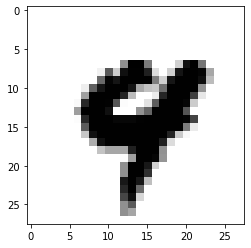



2 [ Predicted Value: 4, Actual Value: 9 ]


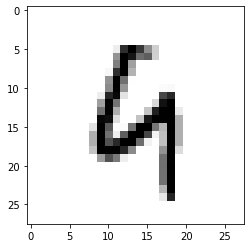



3 [ Predicted Value: 3, Actual Value: 5 ]


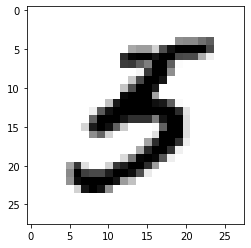



4 [ Predicted Value: 2, Actual Value: 7 ]


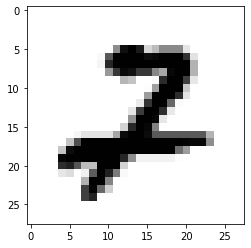



5 [ Predicted Value: 9, Actual Value: 8 ]


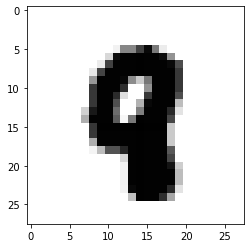



6 [ Predicted Value: 5, Actual Value: 6 ]


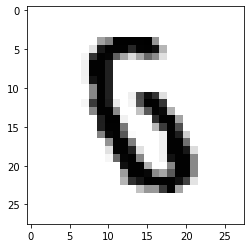



7 [ Predicted Value: 2, Actual Value: 1 ]


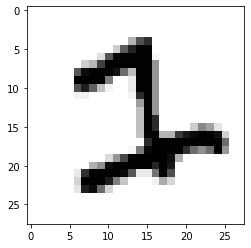



8 [ Predicted Value: 5, Actual Value: 8 ]


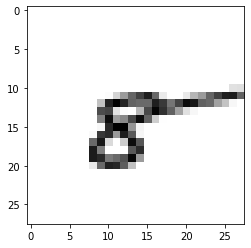



9 [ Predicted Value: 1, Actual Value: 7 ]


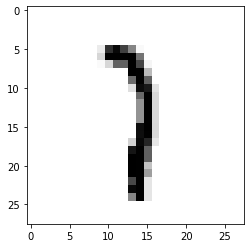



10 [ Predicted Value: 2, Actual Value: 6 ]


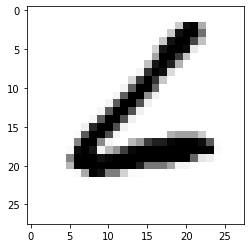



11 [ Predicted Value: 1, Actual Value: 7 ]


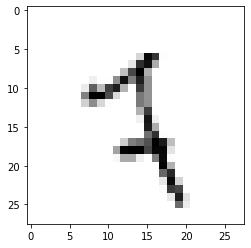



12 [ Predicted Value: 8, Actual Value: 6 ]


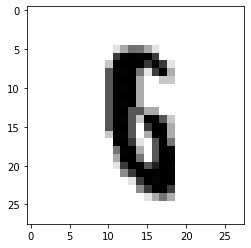



13 [ Predicted Value: 5, Actual Value: 6 ]


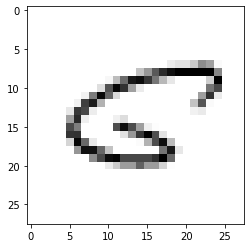



14 [ Predicted Value: 3, Actual Value: 5 ]


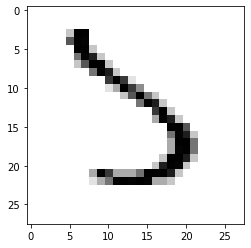



15 [ Predicted Value: 3, Actual Value: 5 ]


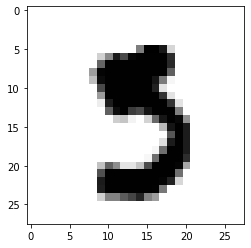



16 [ Predicted Value: 1, Actual Value: 7 ]


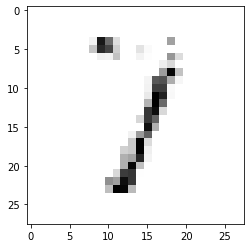



17 [ Predicted Value: 1, Actual Value: 6 ]


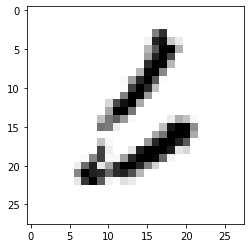



18 [ Predicted Value: 0, Actual Value: 6 ]


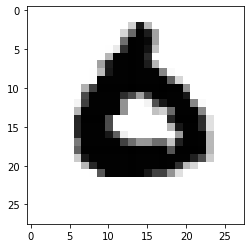



19 [ Predicted Value: 5, Actual Value: 3 ]


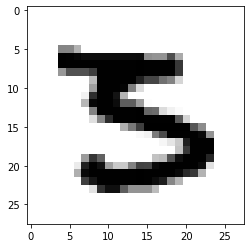



20 [ Predicted Value: 1, Actual Value: 4 ]


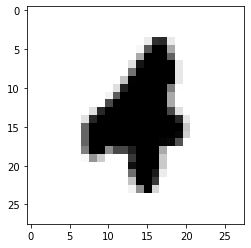



21 [ Predicted Value: 3, Actual Value: 5 ]


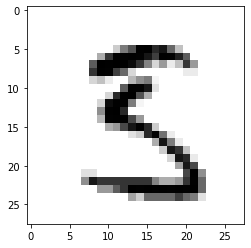



22 [ Predicted Value: 2, Actual Value: 7 ]


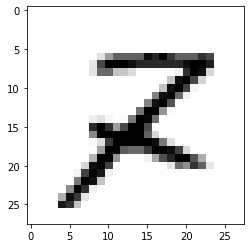



23 [ Predicted Value: 4, Actual Value: 6 ]


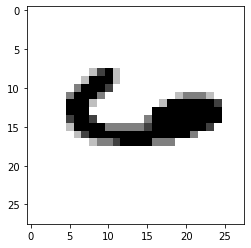



24 [ Predicted Value: 4, Actual Value: 9 ]


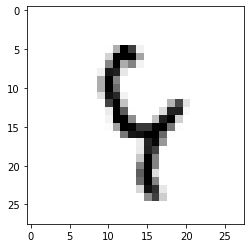



25 [ Predicted Value: 7, Actual Value: 9 ]


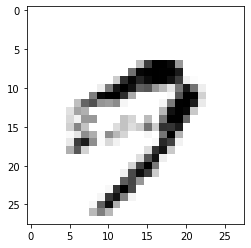



26 [ Predicted Value: 6, Actual Value: 0 ]


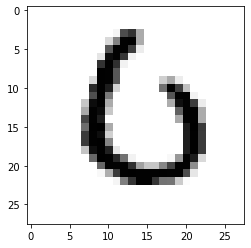



27 [ Predicted Value: 7, Actual Value: 2 ]


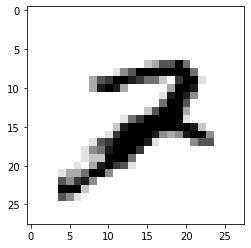



28 [ Predicted Value: 7, Actual Value: 2 ]


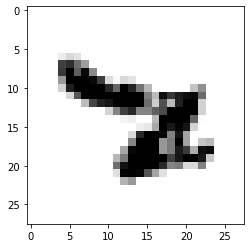



29 [ Predicted Value: 1, Actual Value: 6 ]


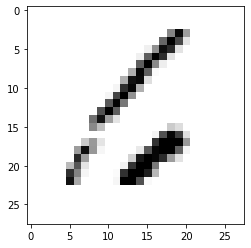



30 [ Predicted Value: 0, Actual Value: 2 ]


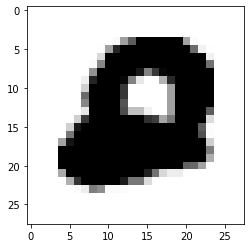



31 [ Predicted Value: 8, Actual Value: 3 ]


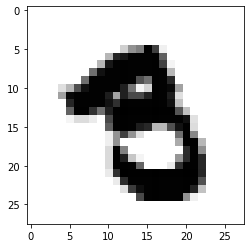



32 [ Predicted Value: 4, Actual Value: 6 ]


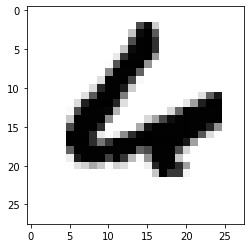



33 [ Predicted Value: 1, Actual Value: 6 ]


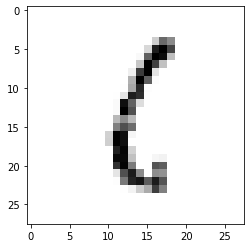



34 [ Predicted Value: 0, Actual Value: 5 ]


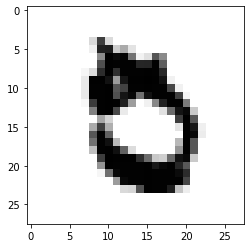



35 [ Predicted Value: 3, Actual Value: 8 ]


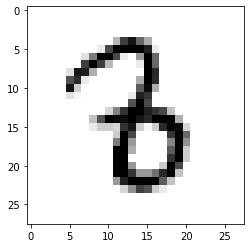



36 [ Predicted Value: 9, Actual Value: 4 ]


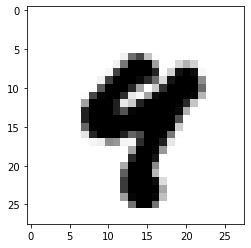



37 [ Predicted Value: 2, Actual Value: 7 ]


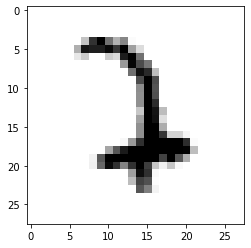



38 [ Predicted Value: 7, Actual Value: 8 ]


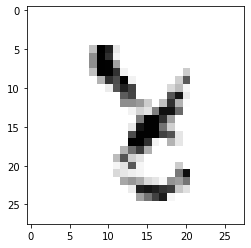



39 [ Predicted Value: 1, Actual Value: 4 ]


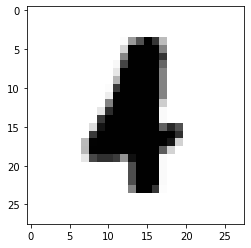



40 [ Predicted Value: 9, Actual Value: 4 ]


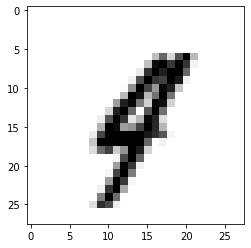



41 [ Predicted Value: 9, Actual Value: 4 ]


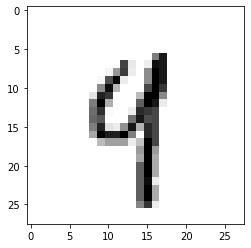



42 [ Predicted Value: 9, Actual Value: 4 ]


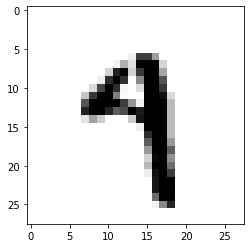



43 [ Predicted Value: 6, Actual Value: 5 ]


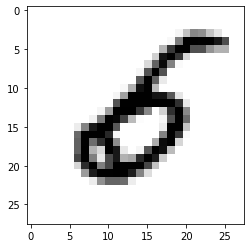



44 [ Predicted Value: 6, Actual Value: 5 ]


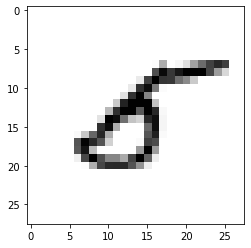



45 [ Predicted Value: 2, Actual Value: 6 ]


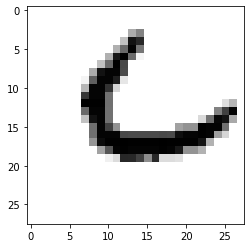



46 [ Predicted Value: 2, Actual Value: 3 ]


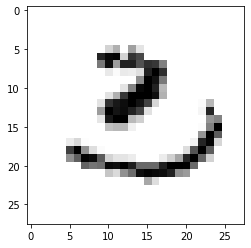



47 [ Predicted Value: 4, Actual Value: 9 ]


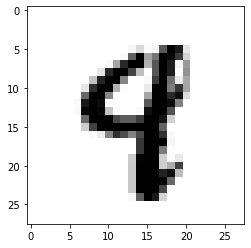



48 [ Predicted Value: 7, Actual Value: 9 ]


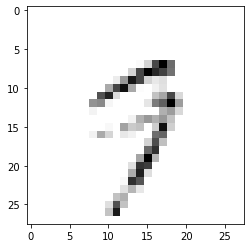



49 [ Predicted Value: 3, Actual Value: 5 ]


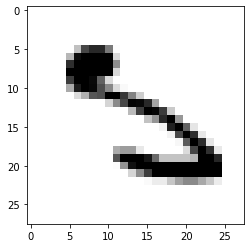



50 [ Predicted Value: 1, Actual Value: 6 ]


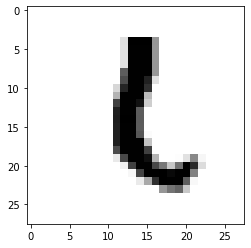



51 [ Predicted Value: 5, Actual Value: 3 ]


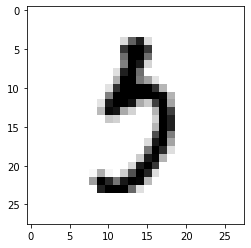



52 [ Predicted Value: 7, Actual Value: 2 ]


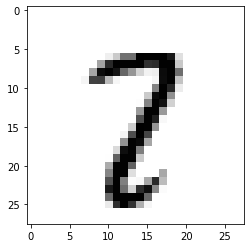



53 [ Predicted Value: 7, Actual Value: 9 ]


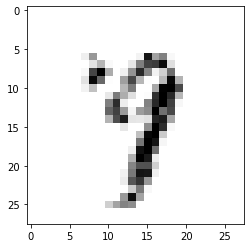



54 [ Predicted Value: 9, Actual Value: 4 ]


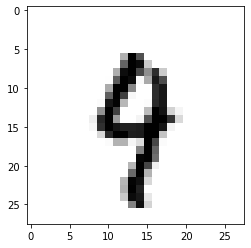



55 [ Predicted Value: 9, Actual Value: 4 ]


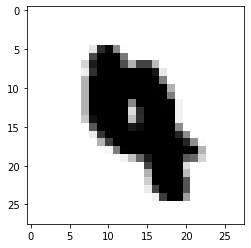



56 [ Predicted Value: 9, Actual Value: 4 ]


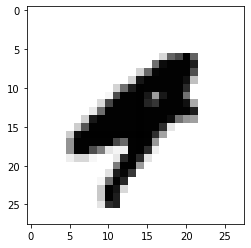



57 [ Predicted Value: 7, Actual Value: 2 ]


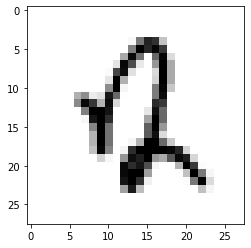

In [33]:
print('\n################With Both L1 and L2 Optimisations##################################\n')

train_losses_l1_l2_d, train_acc_l1_l2_d, test_losses_l1_l2_d, test_acc_l1_l2_d = trainModel('_l1_l2', L1_Flag =True, L2_Flag = True, alpha = al )


##Validation Accuracy and Loss Plots


*****************Test Plots for lambda = 0.005*********************



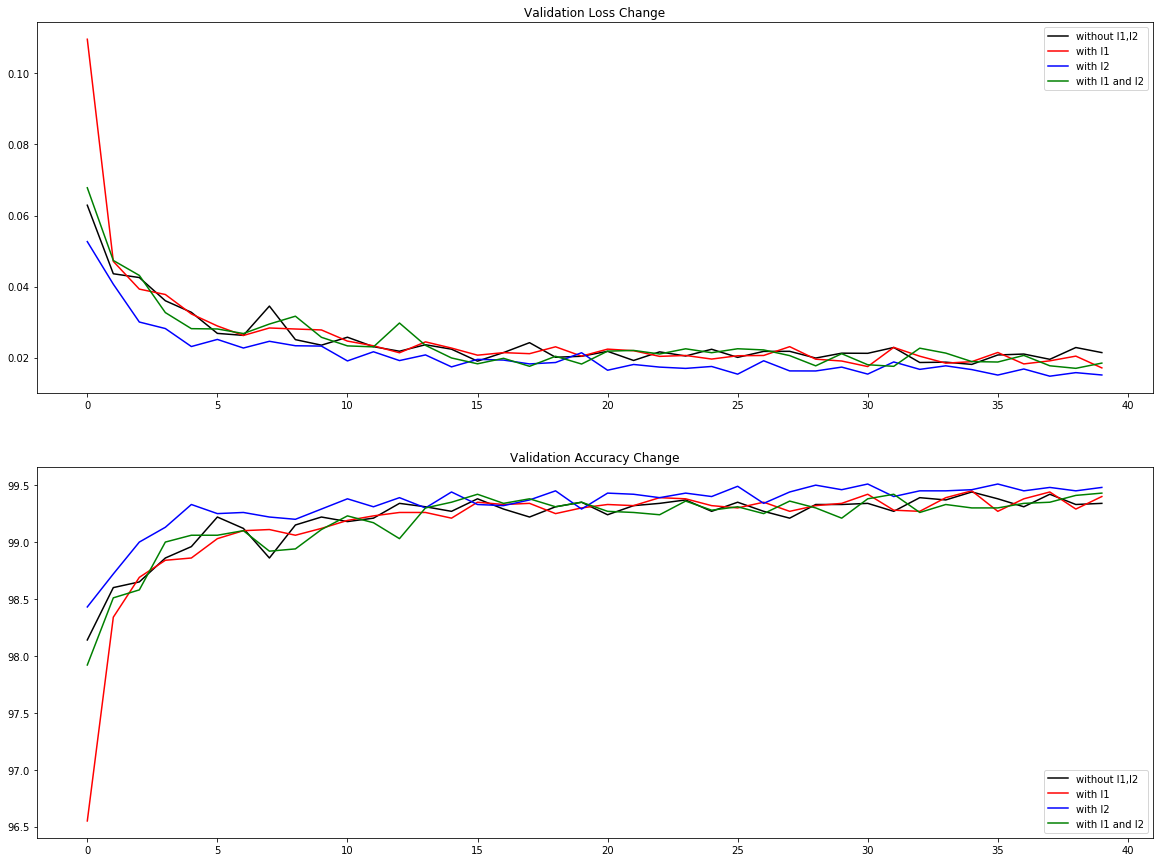

In [34]:
print('\n*****************Test Plots for lambda = {}*********************\n'.format(al))
plotGraphsTest(test_losses_0, test_losses_l1_d, test_losses_l2_d, test_losses_l1_l2_d, test_acc_0, test_acc_l1_d, test_acc_l2_d, test_acc_l1_l2_d)

##Train Accuracy and Loss Plot


*****************Train Plots for lambda = 0.005*********************



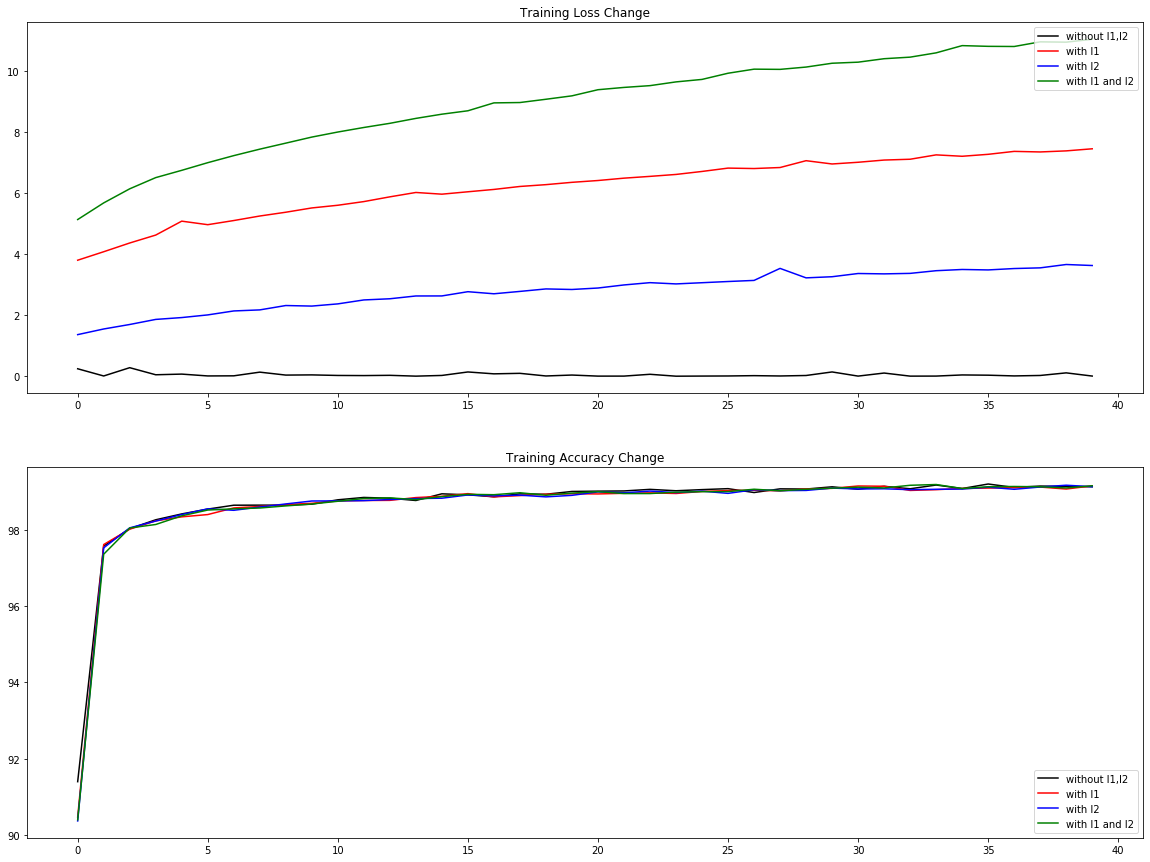

In [35]:
print('\n*****************Train Plots for lambda = {}*********************\n'.format(al))
plotGraphsTrain(train_losses_0, train_losses_l1_d, train_losses_l2_d, train_losses_l1_l2_d, train_acc_0, train_acc_l1_d, train_acc_l2_d, train_acc_l1_l2_d)